# Whale Detection Challenge : Preprocess

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [12]:
import scipy.stats
import numpy as np
import aifc
import matplotlib.pyplot as plt
from matplotlib import mlab, cm
import matplotlib.ticker as plticker
import matplotlib
import pathlib
import os
import cv2
import librosa
import librosa.display
import time
import skimage

ModuleNotFoundError: No module named 'librosa'

## Preprocess Section

### Preprocessing 0 : contrast-enhanced spectrograms

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


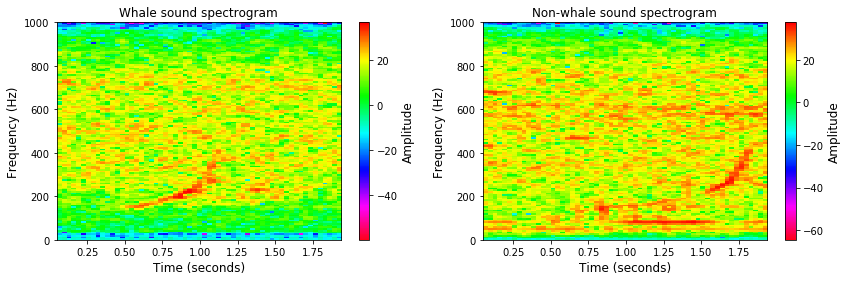

In [10]:
path_data = './data/'
# ReadAIFF function
def ReadAIFF(file):
#Reads the frames from the audio clip and returns the uncompressed data '
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

def plot_sbs_spectrogram(filename_whale, filename_non_whale):
    whale = ReadAIFF(filename_whale)
    nonwhale = ReadAIFF(filename_non_whale)
    plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    plt.specgram(whale, **params);
    ax1.set_title('Whale sound spectrogram', fontsize = 12)
    ax1.set_xlabel('Time (seconds)', fontsize = 12)
    ax1.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    ax2 = plt.subplot(122)
    plt.specgram(nonwhale, **params);
    ax2.set_title('Non-whale sound spectrogram', fontsize = 12)
    ax2.set_xlabel('Time (seconds)', fontsize = 12)
    ax2.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)
    plt.show()
   
# Compare several examples:
plot_sbs_spectrogram(path_data+'train/train6.aiff', path_data+'train/train1.aiff')

In [11]:
# transform all aiffs to np.ndarray and save
def to_spec_and_enhance(filename):
    data = ReadAIFF(filename)
    my_cmap = matplotlib.cm.get_cmap('hsv_r');
    params = {'NFFT':256, 'Fs':2000, 'noverlap':192, 'cmap' : my_cmap}
    spectrum,freq,t,im =plt.specgram(data, **params)
    image_enhanced = scipy.stats.zscore(spectrum, axis=None)
    image_enhanced = 255*(image_enhanced - image_enhanced.min()) / (image_enhanced.max() - image_enhanced.min())
    image_enhanced = image_enhanced.astype(np.uint8)
    #print(image_enhanced)
    #print(np.amin(image_enhanced))
    #print(np.amax(image_enhanced))
    image_enhanced = cv2.equalizeHist(image_enhanced)
    #print(type(np.transpose(spectrum)))
    #print(np.transpose(spectrum).shape)
    return np.transpose(image_enhanced)

### Preprocessing 1 : noise removal

In [6]:
# Convolution and then filter
def noiseFilter(image_array, inner=3, vouter=59, houter=32, maxM=50, norm=True):
    P=image_array
    Q=P.copy()
    Q=cv2.fastNlMeansDenoising(Q)
    m,n=Q.shape
    if(norm):
        mval,sval=np.mean(Q[:maxM,:]),np.std(Q[:maxM,:])
        # Extreme values are capped to mean ± 1.5 std
        fact_=1.5
        upper=mval+fact_*sval   
        lower=mval-fact_*sval
        Q[Q>upper]=upper
        Q[Q<lower]=lower
    wInner=np.ones(inner)
    vOuter=np.ones(vouter)
    hOuter=np.ones(houter)
    #convolution
    #for i in range(n):
    #    Q[:,i]=Q[:,i]-(np.convolve(Q[:,i],vOuter,'same')-np.convolve(Q[:,i],wInner,'same'))/(vouter-inner)
    #for i in range(m):
    #    Q[i,:]=Q[i,:]-(np.convolve(Q[i,:],hOuter,'same')-np.convolve(Q[i,:],wInner,'same'))/(houter-inner)

    return Q[:maxM,:]

###  Preprocessing 2 : filters

###  Preprocessing 3 : PCEN 

In [7]:
# please install librosa first
# pip install librosa

# We recommend scaling the spec data to the range [-2**31, 2**31[ 
# we use magnitude spectrum instead of a power spectrum.

def PCEN(image_array):
    db_img = image_array      
    print(np.max(db_img))
    # it uses amp_img instead of db
    amp_img = librosa.db_to_amplitude(db_img)
    amp_img = amp_img/np.max(amp_img)
#     print(np.max(amp_img))
    
# #     log_S = librosa.amplitude_to_db(S, ref=np.max)
#     # scale the value to the maximum range
    pcen_img = librosa.pcen(amp_img * (2**31))
    plt.figure()
    plt.subplot(2,1,1)
    librosa.display.specshow(db_img, x_axis='time', y_axis='mel')
    plt.title('log amplitude (dB)')
    plt.colorbar()
    plt.subplot(2,1,2)
    librosa.display.specshow(pcen_img, x_axis='time', y_axis='mel')
    plt.title('Per-channel energy normalization')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return pcen_img



### Preprocessing 4 : template matching

###  Preprocessing 5 : clipping

### Save proprocess data

In [ ]:
train_dir = './data/train/'
test_dir = './data/test/'
train_spec_dir = './data/train_spec/'
test_spec_dir = './data/test_spec/'
def save_transformed_data(src_dir,dst_dir):
    cnt=1
    for filename in os.listdir(src_dir):
        if filename.endswith(".aiff"): 
            print("%s %d",src_dir,cnt)
            cnt+=1
            #print(filename)
            src_path=os.path.join(src_dir,filename)
            dst_path=os.path.join(dst_dir,filename[:-5]+".png")
            #print(src_path)
            #print(dst_path)
            processed = to_spec_and_enhance(src_path)
            processed = noiseFilter(processed)
            processed = PCEN(processed)
            processed = skimage.transform.resize(processed, (224,224))
            matplotlib.image.imsave(dst_path,processed)
start_time = time.time()     
save_transformed_data(train_dir,train_spec_dir)
save_transformed_data(test_dir,test_spec_dir)
elapsed_time = time.time() - start_time
print(elapsed_time)

%s %d ./data/train/ 1
%s %d ./data/train/ 2
%s %d ./data/train/ 3
%s %d ./data/train/ 4
%s %d ./data/train/ 5
%s %d ./data/train/ 6
%s %d ./data/train/ 7
%s %d ./data/train/ 8
%s %d ./data/train/ 9
%s %d ./data/train/ 10
%s %d ./data/train/ 11
%s %d ./data/train/ 12
%s %d ./data/train/ 13
%s %d ./data/train/ 14
%s %d ./data/train/ 15
%s %d ./data/train/ 16
%s %d ./data/train/ 17
%s %d ./data/train/ 18
%s %d ./data/train/ 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


%s %d ./data/train/ 20
%s %d ./data/train/ 21
%s %d ./data/train/ 22
%s %d ./data/train/ 23
%s %d ./data/train/ 24
%s %d ./data/train/ 25
%s %d ./data/train/ 26
%s %d ./data/train/ 27
%s %d ./data/train/ 28
%s %d ./data/train/ 29
%s %d ./data/train/ 30
%s %d ./data/train/ 31
%s %d ./data/train/ 32
%s %d ./data/train/ 33
%s %d ./data/train/ 34
%s %d ./data/train/ 35
%s %d ./data/train/ 36
%s %d ./data/train/ 37
%s %d ./data/train/ 38
%s %d ./data/train/ 39
%s %d ./data/train/ 40
%s %d ./data/train/ 41
%s %d ./data/train/ 42
%s %d ./data/train/ 43
%s %d ./data/train/ 44
%s %d ./data/train/ 45
%s %d ./data/train/ 46
%s %d ./data/train/ 47
%s %d ./data/train/ 48
%s %d ./data/train/ 49
%s %d ./data/train/ 50
%s %d ./data/train/ 51
%s %d ./data/train/ 52
%s %d ./data/train/ 53
%s %d ./data/train/ 54
%s %d ./data/train/ 55
%s %d ./data/train/ 56
%s %d ./data/train/ 57
%s %d ./data/train/ 58
%s %d ./data/train/ 59
%s %d ./data/train/ 60
%s %d ./data/train/ 61
%s %d ./data/train/ 62
%s %d ./dat

%s %d ./data/train/ 377
%s %d ./data/train/ 378
%s %d ./data/train/ 379
%s %d ./data/train/ 380
%s %d ./data/train/ 381
%s %d ./data/train/ 382
%s %d ./data/train/ 383
%s %d ./data/train/ 384
%s %d ./data/train/ 385
%s %d ./data/train/ 386
%s %d ./data/train/ 387
%s %d ./data/train/ 388
%s %d ./data/train/ 389
%s %d ./data/train/ 390
%s %d ./data/train/ 391
%s %d ./data/train/ 392
%s %d ./data/train/ 393
%s %d ./data/train/ 394
%s %d ./data/train/ 395
%s %d ./data/train/ 396
%s %d ./data/train/ 397
%s %d ./data/train/ 398
%s %d ./data/train/ 399
%s %d ./data/train/ 400
%s %d ./data/train/ 401
%s %d ./data/train/ 402
%s %d ./data/train/ 403
%s %d ./data/train/ 404
%s %d ./data/train/ 405
%s %d ./data/train/ 406
%s %d ./data/train/ 407
%s %d ./data/train/ 408
%s %d ./data/train/ 409
%s %d ./data/train/ 410
%s %d ./data/train/ 411
%s %d ./data/train/ 412
%s %d ./data/train/ 413
%s %d ./data/train/ 414
%s %d ./data/train/ 415
%s %d ./data/train/ 416
%s %d ./data/train/ 417
%s %d ./data/tra

%s %d ./data/train/ 734
%s %d ./data/train/ 735
%s %d ./data/train/ 736
%s %d ./data/train/ 737
%s %d ./data/train/ 738
%s %d ./data/train/ 739
%s %d ./data/train/ 740
%s %d ./data/train/ 741
%s %d ./data/train/ 742
%s %d ./data/train/ 743
%s %d ./data/train/ 744
%s %d ./data/train/ 745
%s %d ./data/train/ 746
%s %d ./data/train/ 747
%s %d ./data/train/ 748
%s %d ./data/train/ 749
%s %d ./data/train/ 750
%s %d ./data/train/ 751
%s %d ./data/train/ 752
%s %d ./data/train/ 753
%s %d ./data/train/ 754
%s %d ./data/train/ 755
%s %d ./data/train/ 756
%s %d ./data/train/ 757
%s %d ./data/train/ 758
%s %d ./data/train/ 759
%s %d ./data/train/ 760
%s %d ./data/train/ 761
%s %d ./data/train/ 762
%s %d ./data/train/ 763
%s %d ./data/train/ 764
%s %d ./data/train/ 765
%s %d ./data/train/ 766
%s %d ./data/train/ 767
%s %d ./data/train/ 768
%s %d ./data/train/ 769
%s %d ./data/train/ 770
%s %d ./data/train/ 771
%s %d ./data/train/ 772
%s %d ./data/train/ 773
%s %d ./data/train/ 774
%s %d ./data/tra

%s %d ./data/train/ 1074
%s %d ./data/train/ 1075
%s %d ./data/train/ 1076
%s %d ./data/train/ 1077
%s %d ./data/train/ 1078
%s %d ./data/train/ 1079
%s %d ./data/train/ 1080
%s %d ./data/train/ 1081
%s %d ./data/train/ 1082
%s %d ./data/train/ 1083
%s %d ./data/train/ 1084
%s %d ./data/train/ 1085
%s %d ./data/train/ 1086
%s %d ./data/train/ 1087
%s %d ./data/train/ 1088
%s %d ./data/train/ 1089
%s %d ./data/train/ 1090
%s %d ./data/train/ 1091
%s %d ./data/train/ 1092
%s %d ./data/train/ 1093
%s %d ./data/train/ 1094
%s %d ./data/train/ 1095
%s %d ./data/train/ 1096
%s %d ./data/train/ 1097
%s %d ./data/train/ 1098
%s %d ./data/train/ 1099
%s %d ./data/train/ 1100
%s %d ./data/train/ 1101
%s %d ./data/train/ 1102
%s %d ./data/train/ 1103
%s %d ./data/train/ 1104
%s %d ./data/train/ 1105
%s %d ./data/train/ 1106
%s %d ./data/train/ 1107
%s %d ./data/train/ 1108
%s %d ./data/train/ 1109
%s %d ./data/train/ 1110
%s %d ./data/train/ 1111
%s %d ./data/train/ 1112
%s %d ./data/train/ 1113


%s %d ./data/train/ 1407
%s %d ./data/train/ 1408
%s %d ./data/train/ 1409
%s %d ./data/train/ 1410
%s %d ./data/train/ 1411
%s %d ./data/train/ 1412
%s %d ./data/train/ 1413
%s %d ./data/train/ 1414
%s %d ./data/train/ 1415
%s %d ./data/train/ 1416
%s %d ./data/train/ 1417
%s %d ./data/train/ 1418
%s %d ./data/train/ 1419
%s %d ./data/train/ 1420
%s %d ./data/train/ 1421
%s %d ./data/train/ 1422
%s %d ./data/train/ 1423
%s %d ./data/train/ 1424
%s %d ./data/train/ 1425
%s %d ./data/train/ 1426
%s %d ./data/train/ 1427
%s %d ./data/train/ 1428
%s %d ./data/train/ 1429
%s %d ./data/train/ 1430
%s %d ./data/train/ 1431
%s %d ./data/train/ 1432
%s %d ./data/train/ 1433
%s %d ./data/train/ 1434
%s %d ./data/train/ 1435
%s %d ./data/train/ 1436
%s %d ./data/train/ 1437
%s %d ./data/train/ 1438
%s %d ./data/train/ 1439
%s %d ./data/train/ 1440
%s %d ./data/train/ 1441
%s %d ./data/train/ 1442
%s %d ./data/train/ 1443
%s %d ./data/train/ 1444
%s %d ./data/train/ 1445
%s %d ./data/train/ 1446


%s %d ./data/train/ 1740
%s %d ./data/train/ 1741
%s %d ./data/train/ 1742
%s %d ./data/train/ 1743
%s %d ./data/train/ 1744
%s %d ./data/train/ 1745
%s %d ./data/train/ 1746
%s %d ./data/train/ 1747
%s %d ./data/train/ 1748
%s %d ./data/train/ 1749
%s %d ./data/train/ 1750
%s %d ./data/train/ 1751
%s %d ./data/train/ 1752
%s %d ./data/train/ 1753
%s %d ./data/train/ 1754
%s %d ./data/train/ 1755
%s %d ./data/train/ 1756
%s %d ./data/train/ 1757
%s %d ./data/train/ 1758
%s %d ./data/train/ 1759
%s %d ./data/train/ 1760
%s %d ./data/train/ 1761
%s %d ./data/train/ 1762
%s %d ./data/train/ 1763
%s %d ./data/train/ 1764
%s %d ./data/train/ 1765
%s %d ./data/train/ 1766
%s %d ./data/train/ 1767
%s %d ./data/train/ 1768
%s %d ./data/train/ 1769
%s %d ./data/train/ 1770
%s %d ./data/train/ 1771
%s %d ./data/train/ 1772
%s %d ./data/train/ 1773
%s %d ./data/train/ 1774
%s %d ./data/train/ 1775
%s %d ./data/train/ 1776
%s %d ./data/train/ 1777
%s %d ./data/train/ 1778
%s %d ./data/train/ 1779


%s %d ./data/train/ 2079
%s %d ./data/train/ 2080
%s %d ./data/train/ 2081
%s %d ./data/train/ 2082
%s %d ./data/train/ 2083
%s %d ./data/train/ 2084
%s %d ./data/train/ 2085
%s %d ./data/train/ 2086
%s %d ./data/train/ 2087
%s %d ./data/train/ 2088
%s %d ./data/train/ 2089
%s %d ./data/train/ 2090
%s %d ./data/train/ 2091
%s %d ./data/train/ 2092
%s %d ./data/train/ 2093
%s %d ./data/train/ 2094
%s %d ./data/train/ 2095
%s %d ./data/train/ 2096
%s %d ./data/train/ 2097
%s %d ./data/train/ 2098
%s %d ./data/train/ 2099
%s %d ./data/train/ 2100
%s %d ./data/train/ 2101
%s %d ./data/train/ 2102
%s %d ./data/train/ 2103
%s %d ./data/train/ 2104
%s %d ./data/train/ 2105
%s %d ./data/train/ 2106
%s %d ./data/train/ 2107
%s %d ./data/train/ 2108
%s %d ./data/train/ 2109
%s %d ./data/train/ 2110
%s %d ./data/train/ 2111
%s %d ./data/train/ 2112
%s %d ./data/train/ 2113
%s %d ./data/train/ 2114
%s %d ./data/train/ 2115
%s %d ./data/train/ 2116
%s %d ./data/train/ 2117
%s %d ./data/train/ 2118


%s %d ./data/train/ 2422
%s %d ./data/train/ 2423
%s %d ./data/train/ 2424
%s %d ./data/train/ 2425
%s %d ./data/train/ 2426
%s %d ./data/train/ 2427
%s %d ./data/train/ 2428
%s %d ./data/train/ 2429
%s %d ./data/train/ 2430
%s %d ./data/train/ 2431
%s %d ./data/train/ 2432
%s %d ./data/train/ 2433
%s %d ./data/train/ 2434
%s %d ./data/train/ 2435
%s %d ./data/train/ 2436
%s %d ./data/train/ 2437
%s %d ./data/train/ 2438
%s %d ./data/train/ 2439
%s %d ./data/train/ 2440
%s %d ./data/train/ 2441
%s %d ./data/train/ 2442
%s %d ./data/train/ 2443
%s %d ./data/train/ 2444
%s %d ./data/train/ 2445
%s %d ./data/train/ 2446
%s %d ./data/train/ 2447
%s %d ./data/train/ 2448
%s %d ./data/train/ 2449
%s %d ./data/train/ 2450
%s %d ./data/train/ 2451
%s %d ./data/train/ 2452
%s %d ./data/train/ 2453
%s %d ./data/train/ 2454
%s %d ./data/train/ 2455
%s %d ./data/train/ 2456
%s %d ./data/train/ 2457
%s %d ./data/train/ 2458
%s %d ./data/train/ 2459
%s %d ./data/train/ 2460
%s %d ./data/train/ 2461


%s %d ./data/train/ 2763
%s %d ./data/train/ 2764
%s %d ./data/train/ 2765
%s %d ./data/train/ 2766
%s %d ./data/train/ 2767
%s %d ./data/train/ 2768
%s %d ./data/train/ 2769
%s %d ./data/train/ 2770
%s %d ./data/train/ 2771
%s %d ./data/train/ 2772
%s %d ./data/train/ 2773
%s %d ./data/train/ 2774
%s %d ./data/train/ 2775
%s %d ./data/train/ 2776
%s %d ./data/train/ 2777
%s %d ./data/train/ 2778
%s %d ./data/train/ 2779
%s %d ./data/train/ 2780
%s %d ./data/train/ 2781
%s %d ./data/train/ 2782
%s %d ./data/train/ 2783
%s %d ./data/train/ 2784
%s %d ./data/train/ 2785
%s %d ./data/train/ 2786
%s %d ./data/train/ 2787
%s %d ./data/train/ 2788
%s %d ./data/train/ 2789
%s %d ./data/train/ 2790
%s %d ./data/train/ 2791
%s %d ./data/train/ 2792
%s %d ./data/train/ 2793
%s %d ./data/train/ 2794
%s %d ./data/train/ 2795
%s %d ./data/train/ 2796
%s %d ./data/train/ 2797
%s %d ./data/train/ 2798
%s %d ./data/train/ 2799
%s %d ./data/train/ 2800
%s %d ./data/train/ 2801
%s %d ./data/train/ 2802


%s %d ./data/train/ 3100
%s %d ./data/train/ 3101
%s %d ./data/train/ 3102
%s %d ./data/train/ 3103
%s %d ./data/train/ 3104
%s %d ./data/train/ 3105
%s %d ./data/train/ 3106
%s %d ./data/train/ 3107
%s %d ./data/train/ 3108
%s %d ./data/train/ 3109
%s %d ./data/train/ 3110
%s %d ./data/train/ 3111
%s %d ./data/train/ 3112
%s %d ./data/train/ 3113
%s %d ./data/train/ 3114
%s %d ./data/train/ 3115
%s %d ./data/train/ 3116
%s %d ./data/train/ 3117
%s %d ./data/train/ 3118
%s %d ./data/train/ 3119
%s %d ./data/train/ 3120
%s %d ./data/train/ 3121
%s %d ./data/train/ 3122
%s %d ./data/train/ 3123
%s %d ./data/train/ 3124
%s %d ./data/train/ 3125
%s %d ./data/train/ 3126
%s %d ./data/train/ 3127
%s %d ./data/train/ 3128
%s %d ./data/train/ 3129
%s %d ./data/train/ 3130
%s %d ./data/train/ 3131
%s %d ./data/train/ 3132
%s %d ./data/train/ 3133
%s %d ./data/train/ 3134
%s %d ./data/train/ 3135
%s %d ./data/train/ 3136
%s %d ./data/train/ 3137
%s %d ./data/train/ 3138
%s %d ./data/train/ 3139


%s %d ./data/train/ 3428
%s %d ./data/train/ 3429
%s %d ./data/train/ 3430
%s %d ./data/train/ 3431
%s %d ./data/train/ 3432
%s %d ./data/train/ 3433
%s %d ./data/train/ 3434
%s %d ./data/train/ 3435
%s %d ./data/train/ 3436
%s %d ./data/train/ 3437
%s %d ./data/train/ 3438
%s %d ./data/train/ 3439
%s %d ./data/train/ 3440
%s %d ./data/train/ 3441
%s %d ./data/train/ 3442
%s %d ./data/train/ 3443
%s %d ./data/train/ 3444
%s %d ./data/train/ 3445
%s %d ./data/train/ 3446
%s %d ./data/train/ 3447
%s %d ./data/train/ 3448
%s %d ./data/train/ 3449
%s %d ./data/train/ 3450
%s %d ./data/train/ 3451
%s %d ./data/train/ 3452
%s %d ./data/train/ 3453
%s %d ./data/train/ 3454
%s %d ./data/train/ 3455
%s %d ./data/train/ 3456
%s %d ./data/train/ 3457
%s %d ./data/train/ 3458
%s %d ./data/train/ 3459
%s %d ./data/train/ 3460
%s %d ./data/train/ 3461
%s %d ./data/train/ 3462
%s %d ./data/train/ 3463
%s %d ./data/train/ 3464
%s %d ./data/train/ 3465
%s %d ./data/train/ 3466
%s %d ./data/train/ 3467


%s %d ./data/train/ 3765
%s %d ./data/train/ 3766
%s %d ./data/train/ 3767
%s %d ./data/train/ 3768
%s %d ./data/train/ 3769
%s %d ./data/train/ 3770
%s %d ./data/train/ 3771
%s %d ./data/train/ 3772
%s %d ./data/train/ 3773
%s %d ./data/train/ 3774
%s %d ./data/train/ 3775
%s %d ./data/train/ 3776
%s %d ./data/train/ 3777
%s %d ./data/train/ 3778
%s %d ./data/train/ 3779
%s %d ./data/train/ 3780
%s %d ./data/train/ 3781
%s %d ./data/train/ 3782
%s %d ./data/train/ 3783
%s %d ./data/train/ 3784
%s %d ./data/train/ 3785
%s %d ./data/train/ 3786
%s %d ./data/train/ 3787
%s %d ./data/train/ 3788
%s %d ./data/train/ 3789
%s %d ./data/train/ 3790
%s %d ./data/train/ 3791
%s %d ./data/train/ 3792
%s %d ./data/train/ 3793
%s %d ./data/train/ 3794
%s %d ./data/train/ 3795
%s %d ./data/train/ 3796
%s %d ./data/train/ 3797
%s %d ./data/train/ 3798
%s %d ./data/train/ 3799
%s %d ./data/train/ 3800
%s %d ./data/train/ 3801
%s %d ./data/train/ 3802
%s %d ./data/train/ 3803
%s %d ./data/train/ 3804


%s %d ./data/train/ 4095
%s %d ./data/train/ 4096
%s %d ./data/train/ 4097
%s %d ./data/train/ 4098
%s %d ./data/train/ 4099
%s %d ./data/train/ 4100
%s %d ./data/train/ 4101
%s %d ./data/train/ 4102
%s %d ./data/train/ 4103
%s %d ./data/train/ 4104
%s %d ./data/train/ 4105
%s %d ./data/train/ 4106
%s %d ./data/train/ 4107
%s %d ./data/train/ 4108
%s %d ./data/train/ 4109
%s %d ./data/train/ 4110
%s %d ./data/train/ 4111
%s %d ./data/train/ 4112
%s %d ./data/train/ 4113
%s %d ./data/train/ 4114
%s %d ./data/train/ 4115
%s %d ./data/train/ 4116
%s %d ./data/train/ 4117
%s %d ./data/train/ 4118
%s %d ./data/train/ 4119
%s %d ./data/train/ 4120
%s %d ./data/train/ 4121
%s %d ./data/train/ 4122
%s %d ./data/train/ 4123
%s %d ./data/train/ 4124
%s %d ./data/train/ 4125
%s %d ./data/train/ 4126
%s %d ./data/train/ 4127
%s %d ./data/train/ 4128
%s %d ./data/train/ 4129
%s %d ./data/train/ 4130
%s %d ./data/train/ 4131
%s %d ./data/train/ 4132
%s %d ./data/train/ 4133
%s %d ./data/train/ 4134


%s %d ./data/train/ 4430
%s %d ./data/train/ 4431
%s %d ./data/train/ 4432
%s %d ./data/train/ 4433
%s %d ./data/train/ 4434
%s %d ./data/train/ 4435
%s %d ./data/train/ 4436
%s %d ./data/train/ 4437
%s %d ./data/train/ 4438
%s %d ./data/train/ 4439
%s %d ./data/train/ 4440
%s %d ./data/train/ 4441
%s %d ./data/train/ 4442
%s %d ./data/train/ 4443
%s %d ./data/train/ 4444
%s %d ./data/train/ 4445
%s %d ./data/train/ 4446
%s %d ./data/train/ 4447
%s %d ./data/train/ 4448
%s %d ./data/train/ 4449
%s %d ./data/train/ 4450
%s %d ./data/train/ 4451
%s %d ./data/train/ 4452
%s %d ./data/train/ 4453
%s %d ./data/train/ 4454
%s %d ./data/train/ 4455
%s %d ./data/train/ 4456
%s %d ./data/train/ 4457
%s %d ./data/train/ 4458
%s %d ./data/train/ 4459
%s %d ./data/train/ 4460
%s %d ./data/train/ 4461
%s %d ./data/train/ 4462
%s %d ./data/train/ 4463
%s %d ./data/train/ 4464
%s %d ./data/train/ 4465
%s %d ./data/train/ 4466
%s %d ./data/train/ 4467
%s %d ./data/train/ 4468
%s %d ./data/train/ 4469


%s %d ./data/train/ 4758
%s %d ./data/train/ 4759
%s %d ./data/train/ 4760
%s %d ./data/train/ 4761
%s %d ./data/train/ 4762
%s %d ./data/train/ 4763
%s %d ./data/train/ 4764
%s %d ./data/train/ 4765
%s %d ./data/train/ 4766
%s %d ./data/train/ 4767
%s %d ./data/train/ 4768
%s %d ./data/train/ 4769
%s %d ./data/train/ 4770
%s %d ./data/train/ 4771
%s %d ./data/train/ 4772
%s %d ./data/train/ 4773
%s %d ./data/train/ 4774
%s %d ./data/train/ 4775
%s %d ./data/train/ 4776
%s %d ./data/train/ 4777
%s %d ./data/train/ 4778
%s %d ./data/train/ 4779
%s %d ./data/train/ 4780
%s %d ./data/train/ 4781
%s %d ./data/train/ 4782
%s %d ./data/train/ 4783
%s %d ./data/train/ 4784
%s %d ./data/train/ 4785
%s %d ./data/train/ 4786
%s %d ./data/train/ 4787
%s %d ./data/train/ 4788
%s %d ./data/train/ 4789
%s %d ./data/train/ 4790
%s %d ./data/train/ 4791
%s %d ./data/train/ 4792
%s %d ./data/train/ 4793
%s %d ./data/train/ 4794
%s %d ./data/train/ 4795
%s %d ./data/train/ 4796
%s %d ./data/train/ 4797


%s %d ./data/train/ 5094
%s %d ./data/train/ 5095
%s %d ./data/train/ 5096
%s %d ./data/train/ 5097
%s %d ./data/train/ 5098
%s %d ./data/train/ 5099
%s %d ./data/train/ 5100
%s %d ./data/train/ 5101
%s %d ./data/train/ 5102
%s %d ./data/train/ 5103
%s %d ./data/train/ 5104
%s %d ./data/train/ 5105
%s %d ./data/train/ 5106
%s %d ./data/train/ 5107
%s %d ./data/train/ 5108
%s %d ./data/train/ 5109
%s %d ./data/train/ 5110
%s %d ./data/train/ 5111
%s %d ./data/train/ 5112
%s %d ./data/train/ 5113
%s %d ./data/train/ 5114
%s %d ./data/train/ 5115
%s %d ./data/train/ 5116
%s %d ./data/train/ 5117
%s %d ./data/train/ 5118
%s %d ./data/train/ 5119
%s %d ./data/train/ 5120
%s %d ./data/train/ 5121
%s %d ./data/train/ 5122
%s %d ./data/train/ 5123
%s %d ./data/train/ 5124
%s %d ./data/train/ 5125
%s %d ./data/train/ 5126
%s %d ./data/train/ 5127
%s %d ./data/train/ 5128
%s %d ./data/train/ 5129
%s %d ./data/train/ 5130
%s %d ./data/train/ 5131
%s %d ./data/train/ 5132
%s %d ./data/train/ 5133


%s %d ./data/train/ 5438
%s %d ./data/train/ 5439
%s %d ./data/train/ 5440
%s %d ./data/train/ 5441
%s %d ./data/train/ 5442
%s %d ./data/train/ 5443
%s %d ./data/train/ 5444
%s %d ./data/train/ 5445
%s %d ./data/train/ 5446
%s %d ./data/train/ 5447
%s %d ./data/train/ 5448
%s %d ./data/train/ 5449
%s %d ./data/train/ 5450
%s %d ./data/train/ 5451
%s %d ./data/train/ 5452
%s %d ./data/train/ 5453
%s %d ./data/train/ 5454
%s %d ./data/train/ 5455
%s %d ./data/train/ 5456
%s %d ./data/train/ 5457
%s %d ./data/train/ 5458
%s %d ./data/train/ 5459
%s %d ./data/train/ 5460
%s %d ./data/train/ 5461
%s %d ./data/train/ 5462
%s %d ./data/train/ 5463
%s %d ./data/train/ 5464
%s %d ./data/train/ 5465
%s %d ./data/train/ 5466
%s %d ./data/train/ 5467
%s %d ./data/train/ 5468
%s %d ./data/train/ 5469
%s %d ./data/train/ 5470
%s %d ./data/train/ 5471
%s %d ./data/train/ 5472
%s %d ./data/train/ 5473
%s %d ./data/train/ 5474
%s %d ./data/train/ 5475
%s %d ./data/train/ 5476
%s %d ./data/train/ 5477


%s %d ./data/train/ 5772
%s %d ./data/train/ 5773
%s %d ./data/train/ 5774
%s %d ./data/train/ 5775
%s %d ./data/train/ 5776
%s %d ./data/train/ 5777
%s %d ./data/train/ 5778
%s %d ./data/train/ 5779
%s %d ./data/train/ 5780
%s %d ./data/train/ 5781
%s %d ./data/train/ 5782
%s %d ./data/train/ 5783
%s %d ./data/train/ 5784
%s %d ./data/train/ 5785
%s %d ./data/train/ 5786
%s %d ./data/train/ 5787
%s %d ./data/train/ 5788
%s %d ./data/train/ 5789
%s %d ./data/train/ 5790
%s %d ./data/train/ 5791
%s %d ./data/train/ 5792
%s %d ./data/train/ 5793
%s %d ./data/train/ 5794
%s %d ./data/train/ 5795
%s %d ./data/train/ 5796
%s %d ./data/train/ 5797
%s %d ./data/train/ 5798
%s %d ./data/train/ 5799
%s %d ./data/train/ 5800
%s %d ./data/train/ 5801
%s %d ./data/train/ 5802
%s %d ./data/train/ 5803
%s %d ./data/train/ 5804
%s %d ./data/train/ 5805
%s %d ./data/train/ 5806
%s %d ./data/train/ 5807
%s %d ./data/train/ 5808
%s %d ./data/train/ 5809
%s %d ./data/train/ 5810
%s %d ./data/train/ 5811


%s %d ./data/train/ 6102
%s %d ./data/train/ 6103
%s %d ./data/train/ 6104
%s %d ./data/train/ 6105
%s %d ./data/train/ 6106
%s %d ./data/train/ 6107
%s %d ./data/train/ 6108
%s %d ./data/train/ 6109
%s %d ./data/train/ 6110
%s %d ./data/train/ 6111
%s %d ./data/train/ 6112
%s %d ./data/train/ 6113
%s %d ./data/train/ 6114
%s %d ./data/train/ 6115
%s %d ./data/train/ 6116
%s %d ./data/train/ 6117
%s %d ./data/train/ 6118
%s %d ./data/train/ 6119
%s %d ./data/train/ 6120
%s %d ./data/train/ 6121
%s %d ./data/train/ 6122
%s %d ./data/train/ 6123
%s %d ./data/train/ 6124
%s %d ./data/train/ 6125
%s %d ./data/train/ 6126
%s %d ./data/train/ 6127
%s %d ./data/train/ 6128
%s %d ./data/train/ 6129
%s %d ./data/train/ 6130
%s %d ./data/train/ 6131
%s %d ./data/train/ 6132
%s %d ./data/train/ 6133
%s %d ./data/train/ 6134
%s %d ./data/train/ 6135
%s %d ./data/train/ 6136
%s %d ./data/train/ 6137
%s %d ./data/train/ 6138
%s %d ./data/train/ 6139
%s %d ./data/train/ 6140
%s %d ./data/train/ 6141


%s %d ./data/train/ 6438
%s %d ./data/train/ 6439
%s %d ./data/train/ 6440
%s %d ./data/train/ 6441
%s %d ./data/train/ 6442
%s %d ./data/train/ 6443
%s %d ./data/train/ 6444
%s %d ./data/train/ 6445
%s %d ./data/train/ 6446
%s %d ./data/train/ 6447
%s %d ./data/train/ 6448
%s %d ./data/train/ 6449
%s %d ./data/train/ 6450
%s %d ./data/train/ 6451
%s %d ./data/train/ 6452
%s %d ./data/train/ 6453
%s %d ./data/train/ 6454
%s %d ./data/train/ 6455
%s %d ./data/train/ 6456
%s %d ./data/train/ 6457
%s %d ./data/train/ 6458
%s %d ./data/train/ 6459
%s %d ./data/train/ 6460
%s %d ./data/train/ 6461
%s %d ./data/train/ 6462
%s %d ./data/train/ 6463
%s %d ./data/train/ 6464
%s %d ./data/train/ 6465
%s %d ./data/train/ 6466
%s %d ./data/train/ 6467
%s %d ./data/train/ 6468
%s %d ./data/train/ 6469
%s %d ./data/train/ 6470
%s %d ./data/train/ 6471
%s %d ./data/train/ 6472
%s %d ./data/train/ 6473
%s %d ./data/train/ 6474
%s %d ./data/train/ 6475
%s %d ./data/train/ 6476
%s %d ./data/train/ 6477


%s %d ./data/train/ 6775
%s %d ./data/train/ 6776
%s %d ./data/train/ 6777
%s %d ./data/train/ 6778
%s %d ./data/train/ 6779
%s %d ./data/train/ 6780
%s %d ./data/train/ 6781
%s %d ./data/train/ 6782
%s %d ./data/train/ 6783
%s %d ./data/train/ 6784
%s %d ./data/train/ 6785
%s %d ./data/train/ 6786
%s %d ./data/train/ 6787
%s %d ./data/train/ 6788
%s %d ./data/train/ 6789
%s %d ./data/train/ 6790
%s %d ./data/train/ 6791
%s %d ./data/train/ 6792
%s %d ./data/train/ 6793
%s %d ./data/train/ 6794
%s %d ./data/train/ 6795
%s %d ./data/train/ 6796
%s %d ./data/train/ 6797
%s %d ./data/train/ 6798
%s %d ./data/train/ 6799
%s %d ./data/train/ 6800
%s %d ./data/train/ 6801
%s %d ./data/train/ 6802
%s %d ./data/train/ 6803
%s %d ./data/train/ 6804
%s %d ./data/train/ 6805
%s %d ./data/train/ 6806
%s %d ./data/train/ 6807
%s %d ./data/train/ 6808
%s %d ./data/train/ 6809
%s %d ./data/train/ 6810
%s %d ./data/train/ 6811
%s %d ./data/train/ 6812
%s %d ./data/train/ 6813
%s %d ./data/train/ 6814


%s %d ./data/train/ 7114
%s %d ./data/train/ 7115
%s %d ./data/train/ 7116
%s %d ./data/train/ 7117
%s %d ./data/train/ 7118
%s %d ./data/train/ 7119
%s %d ./data/train/ 7120
%s %d ./data/train/ 7121
%s %d ./data/train/ 7122
%s %d ./data/train/ 7123
%s %d ./data/train/ 7124
%s %d ./data/train/ 7125
%s %d ./data/train/ 7126
%s %d ./data/train/ 7127
%s %d ./data/train/ 7128
%s %d ./data/train/ 7129
%s %d ./data/train/ 7130
%s %d ./data/train/ 7131
%s %d ./data/train/ 7132
%s %d ./data/train/ 7133
%s %d ./data/train/ 7134
%s %d ./data/train/ 7135
%s %d ./data/train/ 7136
%s %d ./data/train/ 7137
%s %d ./data/train/ 7138
%s %d ./data/train/ 7139
%s %d ./data/train/ 7140
%s %d ./data/train/ 7141
%s %d ./data/train/ 7142
%s %d ./data/train/ 7143
%s %d ./data/train/ 7144
%s %d ./data/train/ 7145
%s %d ./data/train/ 7146
%s %d ./data/train/ 7147
%s %d ./data/train/ 7148
%s %d ./data/train/ 7149
%s %d ./data/train/ 7150
%s %d ./data/train/ 7151
%s %d ./data/train/ 7152
%s %d ./data/train/ 7153


%s %d ./data/train/ 7444
%s %d ./data/train/ 7445
%s %d ./data/train/ 7446
%s %d ./data/train/ 7447
%s %d ./data/train/ 7448
%s %d ./data/train/ 7449
%s %d ./data/train/ 7450
%s %d ./data/train/ 7451
%s %d ./data/train/ 7452
%s %d ./data/train/ 7453
%s %d ./data/train/ 7454
%s %d ./data/train/ 7455
%s %d ./data/train/ 7456
%s %d ./data/train/ 7457
%s %d ./data/train/ 7458
%s %d ./data/train/ 7459
%s %d ./data/train/ 7460
%s %d ./data/train/ 7461
%s %d ./data/train/ 7462
%s %d ./data/train/ 7463
%s %d ./data/train/ 7464
%s %d ./data/train/ 7465
%s %d ./data/train/ 7466
%s %d ./data/train/ 7467
%s %d ./data/train/ 7468
%s %d ./data/train/ 7469
%s %d ./data/train/ 7470
%s %d ./data/train/ 7471
%s %d ./data/train/ 7472
%s %d ./data/train/ 7473
%s %d ./data/train/ 7474
%s %d ./data/train/ 7475
%s %d ./data/train/ 7476
%s %d ./data/train/ 7477
%s %d ./data/train/ 7478
%s %d ./data/train/ 7479
%s %d ./data/train/ 7480
%s %d ./data/train/ 7481
%s %d ./data/train/ 7482
%s %d ./data/train/ 7483


%s %d ./data/train/ 7776
%s %d ./data/train/ 7777
%s %d ./data/train/ 7778
%s %d ./data/train/ 7779
%s %d ./data/train/ 7780
%s %d ./data/train/ 7781
%s %d ./data/train/ 7782
%s %d ./data/train/ 7783
%s %d ./data/train/ 7784
%s %d ./data/train/ 7785
%s %d ./data/train/ 7786
%s %d ./data/train/ 7787
%s %d ./data/train/ 7788
%s %d ./data/train/ 7789
%s %d ./data/train/ 7790
%s %d ./data/train/ 7791
%s %d ./data/train/ 7792
%s %d ./data/train/ 7793
%s %d ./data/train/ 7794
%s %d ./data/train/ 7795
%s %d ./data/train/ 7796
%s %d ./data/train/ 7797
%s %d ./data/train/ 7798
%s %d ./data/train/ 7799
%s %d ./data/train/ 7800
%s %d ./data/train/ 7801
%s %d ./data/train/ 7802
%s %d ./data/train/ 7803
%s %d ./data/train/ 7804
%s %d ./data/train/ 7805
%s %d ./data/train/ 7806
%s %d ./data/train/ 7807
%s %d ./data/train/ 7808
%s %d ./data/train/ 7809
%s %d ./data/train/ 7810
%s %d ./data/train/ 7811
%s %d ./data/train/ 7812
%s %d ./data/train/ 7813
%s %d ./data/train/ 7814
%s %d ./data/train/ 7815


%s %d ./data/train/ 8108
%s %d ./data/train/ 8109
%s %d ./data/train/ 8110
%s %d ./data/train/ 8111
%s %d ./data/train/ 8112
%s %d ./data/train/ 8113
%s %d ./data/train/ 8114
%s %d ./data/train/ 8115
%s %d ./data/train/ 8116
%s %d ./data/train/ 8117
%s %d ./data/train/ 8118
%s %d ./data/train/ 8119
%s %d ./data/train/ 8120
%s %d ./data/train/ 8121
%s %d ./data/train/ 8122
%s %d ./data/train/ 8123
%s %d ./data/train/ 8124
%s %d ./data/train/ 8125
%s %d ./data/train/ 8126
%s %d ./data/train/ 8127
%s %d ./data/train/ 8128
%s %d ./data/train/ 8129
%s %d ./data/train/ 8130
%s %d ./data/train/ 8131
%s %d ./data/train/ 8132
%s %d ./data/train/ 8133
%s %d ./data/train/ 8134
%s %d ./data/train/ 8135
%s %d ./data/train/ 8136
%s %d ./data/train/ 8137
%s %d ./data/train/ 8138
%s %d ./data/train/ 8139
%s %d ./data/train/ 8140
%s %d ./data/train/ 8141
%s %d ./data/train/ 8142
%s %d ./data/train/ 8143
%s %d ./data/train/ 8144
%s %d ./data/train/ 8145
%s %d ./data/train/ 8146
%s %d ./data/train/ 8147


%s %d ./data/train/ 8441
%s %d ./data/train/ 8442
%s %d ./data/train/ 8443
%s %d ./data/train/ 8444
%s %d ./data/train/ 8445
%s %d ./data/train/ 8446
%s %d ./data/train/ 8447
%s %d ./data/train/ 8448
%s %d ./data/train/ 8449
%s %d ./data/train/ 8450
%s %d ./data/train/ 8451
%s %d ./data/train/ 8452
%s %d ./data/train/ 8453
%s %d ./data/train/ 8454
%s %d ./data/train/ 8455
%s %d ./data/train/ 8456
%s %d ./data/train/ 8457
%s %d ./data/train/ 8458
%s %d ./data/train/ 8459
%s %d ./data/train/ 8460
%s %d ./data/train/ 8461
%s %d ./data/train/ 8462
%s %d ./data/train/ 8463
%s %d ./data/train/ 8464
%s %d ./data/train/ 8465
%s %d ./data/train/ 8466
%s %d ./data/train/ 8467
%s %d ./data/train/ 8468
%s %d ./data/train/ 8469
%s %d ./data/train/ 8470
%s %d ./data/train/ 8471
%s %d ./data/train/ 8472
%s %d ./data/train/ 8473
%s %d ./data/train/ 8474
%s %d ./data/train/ 8475
%s %d ./data/train/ 8476
%s %d ./data/train/ 8477
%s %d ./data/train/ 8478
%s %d ./data/train/ 8479
%s %d ./data/train/ 8480


%s %d ./data/train/ 8769
%s %d ./data/train/ 8770
%s %d ./data/train/ 8771
%s %d ./data/train/ 8772
%s %d ./data/train/ 8773
%s %d ./data/train/ 8774
%s %d ./data/train/ 8775
%s %d ./data/train/ 8776
%s %d ./data/train/ 8777
%s %d ./data/train/ 8778
%s %d ./data/train/ 8779
%s %d ./data/train/ 8780
%s %d ./data/train/ 8781
%s %d ./data/train/ 8782
%s %d ./data/train/ 8783
%s %d ./data/train/ 8784
%s %d ./data/train/ 8785
%s %d ./data/train/ 8786
%s %d ./data/train/ 8787
%s %d ./data/train/ 8788
%s %d ./data/train/ 8789
%s %d ./data/train/ 8790
%s %d ./data/train/ 8791
%s %d ./data/train/ 8792
%s %d ./data/train/ 8793
%s %d ./data/train/ 8794
%s %d ./data/train/ 8795
%s %d ./data/train/ 8796
%s %d ./data/train/ 8797
%s %d ./data/train/ 8798
%s %d ./data/train/ 8799
%s %d ./data/train/ 8800
%s %d ./data/train/ 8801
%s %d ./data/train/ 8802
%s %d ./data/train/ 8803
%s %d ./data/train/ 8804
%s %d ./data/train/ 8805
%s %d ./data/train/ 8806
%s %d ./data/train/ 8807
%s %d ./data/train/ 8808


%s %d ./data/train/ 9104
%s %d ./data/train/ 9105
%s %d ./data/train/ 9106
%s %d ./data/train/ 9107
%s %d ./data/train/ 9108
%s %d ./data/train/ 9109
%s %d ./data/train/ 9110
%s %d ./data/train/ 9111
%s %d ./data/train/ 9112
%s %d ./data/train/ 9113
%s %d ./data/train/ 9114
%s %d ./data/train/ 9115
%s %d ./data/train/ 9116
%s %d ./data/train/ 9117
%s %d ./data/train/ 9118
%s %d ./data/train/ 9119
%s %d ./data/train/ 9120
%s %d ./data/train/ 9121
%s %d ./data/train/ 9122
%s %d ./data/train/ 9123
%s %d ./data/train/ 9124
%s %d ./data/train/ 9125
%s %d ./data/train/ 9126
%s %d ./data/train/ 9127
%s %d ./data/train/ 9128
%s %d ./data/train/ 9129
%s %d ./data/train/ 9130
%s %d ./data/train/ 9131
%s %d ./data/train/ 9132
%s %d ./data/train/ 9133
%s %d ./data/train/ 9134
%s %d ./data/train/ 9135
%s %d ./data/train/ 9136
%s %d ./data/train/ 9137
%s %d ./data/train/ 9138
%s %d ./data/train/ 9139
%s %d ./data/train/ 9140
%s %d ./data/train/ 9141
%s %d ./data/train/ 9142
%s %d ./data/train/ 9143


%s %d ./data/train/ 9435
%s %d ./data/train/ 9436
%s %d ./data/train/ 9437
%s %d ./data/train/ 9438
%s %d ./data/train/ 9439
%s %d ./data/train/ 9440
%s %d ./data/train/ 9441
%s %d ./data/train/ 9442
%s %d ./data/train/ 9443
%s %d ./data/train/ 9444
%s %d ./data/train/ 9445
%s %d ./data/train/ 9446
%s %d ./data/train/ 9447
%s %d ./data/train/ 9448
%s %d ./data/train/ 9449
%s %d ./data/train/ 9450
%s %d ./data/train/ 9451
%s %d ./data/train/ 9452
%s %d ./data/train/ 9453
%s %d ./data/train/ 9454
%s %d ./data/train/ 9455
%s %d ./data/train/ 9456
%s %d ./data/train/ 9457
%s %d ./data/train/ 9458
%s %d ./data/train/ 9459
%s %d ./data/train/ 9460
%s %d ./data/train/ 9461
%s %d ./data/train/ 9462
%s %d ./data/train/ 9463
%s %d ./data/train/ 9464
%s %d ./data/train/ 9465
%s %d ./data/train/ 9466
%s %d ./data/train/ 9467
%s %d ./data/train/ 9468
%s %d ./data/train/ 9469
%s %d ./data/train/ 9470
%s %d ./data/train/ 9471
%s %d ./data/train/ 9472
%s %d ./data/train/ 9473
%s %d ./data/train/ 9474


%s %d ./data/train/ 9765
%s %d ./data/train/ 9766
%s %d ./data/train/ 9767
%s %d ./data/train/ 9768
%s %d ./data/train/ 9769
%s %d ./data/train/ 9770
%s %d ./data/train/ 9771
%s %d ./data/train/ 9772
%s %d ./data/train/ 9773
%s %d ./data/train/ 9774
%s %d ./data/train/ 9775
%s %d ./data/train/ 9776
%s %d ./data/train/ 9777
%s %d ./data/train/ 9778
%s %d ./data/train/ 9779
%s %d ./data/train/ 9780
%s %d ./data/train/ 9781
%s %d ./data/train/ 9782
%s %d ./data/train/ 9783
%s %d ./data/train/ 9784
%s %d ./data/train/ 9785
%s %d ./data/train/ 9786
%s %d ./data/train/ 9787
%s %d ./data/train/ 9788
%s %d ./data/train/ 9789
%s %d ./data/train/ 9790
%s %d ./data/train/ 9791
%s %d ./data/train/ 9792
%s %d ./data/train/ 9793
%s %d ./data/train/ 9794
%s %d ./data/train/ 9795
%s %d ./data/train/ 9796
%s %d ./data/train/ 9797
%s %d ./data/train/ 9798
%s %d ./data/train/ 9799
%s %d ./data/train/ 9800
%s %d ./data/train/ 9801
%s %d ./data/train/ 9802
%s %d ./data/train/ 9803
%s %d ./data/train/ 9804


%s %d ./data/train/ 10096
%s %d ./data/train/ 10097
%s %d ./data/train/ 10098
%s %d ./data/train/ 10099
%s %d ./data/train/ 10100
%s %d ./data/train/ 10101
%s %d ./data/train/ 10102
%s %d ./data/train/ 10103
%s %d ./data/train/ 10104
%s %d ./data/train/ 10105
%s %d ./data/train/ 10106
%s %d ./data/train/ 10107
%s %d ./data/train/ 10108
%s %d ./data/train/ 10109
%s %d ./data/train/ 10110
%s %d ./data/train/ 10111
%s %d ./data/train/ 10112
%s %d ./data/train/ 10113
%s %d ./data/train/ 10114
%s %d ./data/train/ 10115
%s %d ./data/train/ 10116
%s %d ./data/train/ 10117
%s %d ./data/train/ 10118
%s %d ./data/train/ 10119
%s %d ./data/train/ 10120
%s %d ./data/train/ 10121
%s %d ./data/train/ 10122
%s %d ./data/train/ 10123
%s %d ./data/train/ 10124
%s %d ./data/train/ 10125
%s %d ./data/train/ 10126
%s %d ./data/train/ 10127
%s %d ./data/train/ 10128
%s %d ./data/train/ 10129
%s %d ./data/train/ 10130
%s %d ./data/train/ 10131
%s %d ./data/train/ 10132
%s %d ./data/train/ 10133
%s %d ./data

%s %d ./data/train/ 10422
%s %d ./data/train/ 10423
%s %d ./data/train/ 10424
%s %d ./data/train/ 10425
%s %d ./data/train/ 10426
%s %d ./data/train/ 10427
%s %d ./data/train/ 10428
%s %d ./data/train/ 10429
%s %d ./data/train/ 10430
%s %d ./data/train/ 10431
%s %d ./data/train/ 10432
%s %d ./data/train/ 10433
%s %d ./data/train/ 10434
%s %d ./data/train/ 10435
%s %d ./data/train/ 10436
%s %d ./data/train/ 10437
%s %d ./data/train/ 10438
%s %d ./data/train/ 10439
%s %d ./data/train/ 10440
%s %d ./data/train/ 10441
%s %d ./data/train/ 10442
%s %d ./data/train/ 10443
%s %d ./data/train/ 10444
%s %d ./data/train/ 10445
%s %d ./data/train/ 10446
%s %d ./data/train/ 10447
%s %d ./data/train/ 10448
%s %d ./data/train/ 10449
%s %d ./data/train/ 10450
%s %d ./data/train/ 10451
%s %d ./data/train/ 10452
%s %d ./data/train/ 10453
%s %d ./data/train/ 10454
%s %d ./data/train/ 10455
%s %d ./data/train/ 10456
%s %d ./data/train/ 10457
%s %d ./data/train/ 10458
%s %d ./data/train/ 10459
%s %d ./data

%s %d ./data/train/ 10743
%s %d ./data/train/ 10744
%s %d ./data/train/ 10745
%s %d ./data/train/ 10746
%s %d ./data/train/ 10747
%s %d ./data/train/ 10748
%s %d ./data/train/ 10749
%s %d ./data/train/ 10750
%s %d ./data/train/ 10751
%s %d ./data/train/ 10752
%s %d ./data/train/ 10753
%s %d ./data/train/ 10754
%s %d ./data/train/ 10755
%s %d ./data/train/ 10756
%s %d ./data/train/ 10757
%s %d ./data/train/ 10758
%s %d ./data/train/ 10759
%s %d ./data/train/ 10760
%s %d ./data/train/ 10761
%s %d ./data/train/ 10762
%s %d ./data/train/ 10763
%s %d ./data/train/ 10764
%s %d ./data/train/ 10765
%s %d ./data/train/ 10766
%s %d ./data/train/ 10767
%s %d ./data/train/ 10768
%s %d ./data/train/ 10769
%s %d ./data/train/ 10770
%s %d ./data/train/ 10771
%s %d ./data/train/ 10772
%s %d ./data/train/ 10773
%s %d ./data/train/ 10774
%s %d ./data/train/ 10775
%s %d ./data/train/ 10776
%s %d ./data/train/ 10777
%s %d ./data/train/ 10778
%s %d ./data/train/ 10779
%s %d ./data/train/ 10780
%s %d ./data

%s %d ./data/train/ 11064
%s %d ./data/train/ 11065
%s %d ./data/train/ 11066
%s %d ./data/train/ 11067
%s %d ./data/train/ 11068
%s %d ./data/train/ 11069
%s %d ./data/train/ 11070
%s %d ./data/train/ 11071
%s %d ./data/train/ 11072
%s %d ./data/train/ 11073
%s %d ./data/train/ 11074
%s %d ./data/train/ 11075
%s %d ./data/train/ 11076
%s %d ./data/train/ 11077
%s %d ./data/train/ 11078
%s %d ./data/train/ 11079
%s %d ./data/train/ 11080
%s %d ./data/train/ 11081
%s %d ./data/train/ 11082
%s %d ./data/train/ 11083
%s %d ./data/train/ 11084
%s %d ./data/train/ 11085
%s %d ./data/train/ 11086
%s %d ./data/train/ 11087
%s %d ./data/train/ 11088
%s %d ./data/train/ 11089
%s %d ./data/train/ 11090
%s %d ./data/train/ 11091
%s %d ./data/train/ 11092
%s %d ./data/train/ 11093
%s %d ./data/train/ 11094
%s %d ./data/train/ 11095
%s %d ./data/train/ 11096
%s %d ./data/train/ 11097
%s %d ./data/train/ 11098
%s %d ./data/train/ 11099
%s %d ./data/train/ 11100
%s %d ./data/train/ 11101
%s %d ./data

%s %d ./data/train/ 11381
%s %d ./data/train/ 11382
%s %d ./data/train/ 11383
%s %d ./data/train/ 11384
%s %d ./data/train/ 11385
%s %d ./data/train/ 11386
%s %d ./data/train/ 11387
%s %d ./data/train/ 11388
%s %d ./data/train/ 11389
%s %d ./data/train/ 11390
%s %d ./data/train/ 11391
%s %d ./data/train/ 11392
%s %d ./data/train/ 11393
%s %d ./data/train/ 11394
%s %d ./data/train/ 11395
%s %d ./data/train/ 11396
%s %d ./data/train/ 11397
%s %d ./data/train/ 11398
%s %d ./data/train/ 11399
%s %d ./data/train/ 11400
%s %d ./data/train/ 11401
%s %d ./data/train/ 11402
%s %d ./data/train/ 11403
%s %d ./data/train/ 11404
%s %d ./data/train/ 11405
%s %d ./data/train/ 11406
%s %d ./data/train/ 11407
%s %d ./data/train/ 11408
%s %d ./data/train/ 11409
%s %d ./data/train/ 11410
%s %d ./data/train/ 11411
%s %d ./data/train/ 11412
%s %d ./data/train/ 11413
%s %d ./data/train/ 11414
%s %d ./data/train/ 11415
%s %d ./data/train/ 11416
%s %d ./data/train/ 11417
%s %d ./data/train/ 11418
%s %d ./data

%s %d ./data/train/ 11700
%s %d ./data/train/ 11701
%s %d ./data/train/ 11702
%s %d ./data/train/ 11703
%s %d ./data/train/ 11704
%s %d ./data/train/ 11705
%s %d ./data/train/ 11706
%s %d ./data/train/ 11707
%s %d ./data/train/ 11708
%s %d ./data/train/ 11709
%s %d ./data/train/ 11710
%s %d ./data/train/ 11711
%s %d ./data/train/ 11712
%s %d ./data/train/ 11713
%s %d ./data/train/ 11714
%s %d ./data/train/ 11715
%s %d ./data/train/ 11716
%s %d ./data/train/ 11717
%s %d ./data/train/ 11718
%s %d ./data/train/ 11719
%s %d ./data/train/ 11720
%s %d ./data/train/ 11721
%s %d ./data/train/ 11722
%s %d ./data/train/ 11723
%s %d ./data/train/ 11724
%s %d ./data/train/ 11725
%s %d ./data/train/ 11726
%s %d ./data/train/ 11727
%s %d ./data/train/ 11728
%s %d ./data/train/ 11729
%s %d ./data/train/ 11730
%s %d ./data/train/ 11731
%s %d ./data/train/ 11732
%s %d ./data/train/ 11733
%s %d ./data/train/ 11734
%s %d ./data/train/ 11735
%s %d ./data/train/ 11736
%s %d ./data/train/ 11737
%s %d ./data

%s %d ./data/train/ 12026
%s %d ./data/train/ 12027
%s %d ./data/train/ 12028
%s %d ./data/train/ 12029
%s %d ./data/train/ 12030
%s %d ./data/train/ 12031
%s %d ./data/train/ 12032
%s %d ./data/train/ 12033
%s %d ./data/train/ 12034
%s %d ./data/train/ 12035
%s %d ./data/train/ 12036
%s %d ./data/train/ 12037
%s %d ./data/train/ 12038
%s %d ./data/train/ 12039
%s %d ./data/train/ 12040
%s %d ./data/train/ 12041
%s %d ./data/train/ 12042
%s %d ./data/train/ 12043
%s %d ./data/train/ 12044
%s %d ./data/train/ 12045
%s %d ./data/train/ 12046
%s %d ./data/train/ 12047
%s %d ./data/train/ 12048
%s %d ./data/train/ 12049
%s %d ./data/train/ 12050
%s %d ./data/train/ 12051
%s %d ./data/train/ 12052
%s %d ./data/train/ 12053
%s %d ./data/train/ 12054
%s %d ./data/train/ 12055
%s %d ./data/train/ 12056
%s %d ./data/train/ 12057
%s %d ./data/train/ 12058
%s %d ./data/train/ 12059
%s %d ./data/train/ 12060
%s %d ./data/train/ 12061
%s %d ./data/train/ 12062
%s %d ./data/train/ 12063
%s %d ./data

%s %d ./data/train/ 12348
%s %d ./data/train/ 12349
%s %d ./data/train/ 12350
%s %d ./data/train/ 12351
%s %d ./data/train/ 12352
%s %d ./data/train/ 12353
%s %d ./data/train/ 12354
%s %d ./data/train/ 12355
%s %d ./data/train/ 12356
%s %d ./data/train/ 12357
%s %d ./data/train/ 12358
%s %d ./data/train/ 12359
%s %d ./data/train/ 12360
%s %d ./data/train/ 12361
%s %d ./data/train/ 12362
%s %d ./data/train/ 12363
%s %d ./data/train/ 12364
%s %d ./data/train/ 12365
%s %d ./data/train/ 12366
%s %d ./data/train/ 12367
%s %d ./data/train/ 12368
%s %d ./data/train/ 12369
%s %d ./data/train/ 12370
%s %d ./data/train/ 12371
%s %d ./data/train/ 12372
%s %d ./data/train/ 12373
%s %d ./data/train/ 12374
%s %d ./data/train/ 12375
%s %d ./data/train/ 12376
%s %d ./data/train/ 12377
%s %d ./data/train/ 12378
%s %d ./data/train/ 12379
%s %d ./data/train/ 12380
%s %d ./data/train/ 12381
%s %d ./data/train/ 12382
%s %d ./data/train/ 12383
%s %d ./data/train/ 12384
%s %d ./data/train/ 12385
%s %d ./data

%s %d ./data/train/ 12667
%s %d ./data/train/ 12668
%s %d ./data/train/ 12669
%s %d ./data/train/ 12670
%s %d ./data/train/ 12671
%s %d ./data/train/ 12672
%s %d ./data/train/ 12673
%s %d ./data/train/ 12674
%s %d ./data/train/ 12675
%s %d ./data/train/ 12676
%s %d ./data/train/ 12677
%s %d ./data/train/ 12678
%s %d ./data/train/ 12679
%s %d ./data/train/ 12680
%s %d ./data/train/ 12681
%s %d ./data/train/ 12682
%s %d ./data/train/ 12683
%s %d ./data/train/ 12684
%s %d ./data/train/ 12685
%s %d ./data/train/ 12686
%s %d ./data/train/ 12687
%s %d ./data/train/ 12688
%s %d ./data/train/ 12689
%s %d ./data/train/ 12690
%s %d ./data/train/ 12691
%s %d ./data/train/ 12692
%s %d ./data/train/ 12693
%s %d ./data/train/ 12694
%s %d ./data/train/ 12695
%s %d ./data/train/ 12696
%s %d ./data/train/ 12697
%s %d ./data/train/ 12698
%s %d ./data/train/ 12699
%s %d ./data/train/ 12700
%s %d ./data/train/ 12701
%s %d ./data/train/ 12702
%s %d ./data/train/ 12703
%s %d ./data/train/ 12704
%s %d ./data

%s %d ./data/train/ 12985
%s %d ./data/train/ 12986
%s %d ./data/train/ 12987
%s %d ./data/train/ 12988
%s %d ./data/train/ 12989
%s %d ./data/train/ 12990
%s %d ./data/train/ 12991
%s %d ./data/train/ 12992
%s %d ./data/train/ 12993
%s %d ./data/train/ 12994
%s %d ./data/train/ 12995
%s %d ./data/train/ 12996
%s %d ./data/train/ 12997
%s %d ./data/train/ 12998
%s %d ./data/train/ 12999
%s %d ./data/train/ 13000
%s %d ./data/train/ 13001
%s %d ./data/train/ 13002
%s %d ./data/train/ 13003
%s %d ./data/train/ 13004
%s %d ./data/train/ 13005
%s %d ./data/train/ 13006
%s %d ./data/train/ 13007
%s %d ./data/train/ 13008
%s %d ./data/train/ 13009
%s %d ./data/train/ 13010
%s %d ./data/train/ 13011
%s %d ./data/train/ 13012
%s %d ./data/train/ 13013
%s %d ./data/train/ 13014
%s %d ./data/train/ 13015
%s %d ./data/train/ 13016
%s %d ./data/train/ 13017
%s %d ./data/train/ 13018
%s %d ./data/train/ 13019
%s %d ./data/train/ 13020
%s %d ./data/train/ 13021
%s %d ./data/train/ 13022
%s %d ./data

%s %d ./data/train/ 13302
%s %d ./data/train/ 13303
%s %d ./data/train/ 13304
%s %d ./data/train/ 13305
%s %d ./data/train/ 13306
%s %d ./data/train/ 13307
%s %d ./data/train/ 13308
%s %d ./data/train/ 13309
%s %d ./data/train/ 13310
%s %d ./data/train/ 13311
%s %d ./data/train/ 13312
%s %d ./data/train/ 13313
%s %d ./data/train/ 13314
%s %d ./data/train/ 13315
%s %d ./data/train/ 13316
%s %d ./data/train/ 13317
%s %d ./data/train/ 13318
%s %d ./data/train/ 13319
%s %d ./data/train/ 13320
%s %d ./data/train/ 13321
%s %d ./data/train/ 13322
%s %d ./data/train/ 13323
%s %d ./data/train/ 13324
%s %d ./data/train/ 13325
%s %d ./data/train/ 13326
%s %d ./data/train/ 13327
%s %d ./data/train/ 13328
%s %d ./data/train/ 13329
%s %d ./data/train/ 13330
%s %d ./data/train/ 13331
%s %d ./data/train/ 13332
%s %d ./data/train/ 13333
%s %d ./data/train/ 13334
%s %d ./data/train/ 13335
%s %d ./data/train/ 13336
%s %d ./data/train/ 13337
%s %d ./data/train/ 13338
%s %d ./data/train/ 13339
%s %d ./data

%s %d ./data/train/ 13623
%s %d ./data/train/ 13624
%s %d ./data/train/ 13625
%s %d ./data/train/ 13626
%s %d ./data/train/ 13627
%s %d ./data/train/ 13628
%s %d ./data/train/ 13629
%s %d ./data/train/ 13630
%s %d ./data/train/ 13631
%s %d ./data/train/ 13632
%s %d ./data/train/ 13633
%s %d ./data/train/ 13634
%s %d ./data/train/ 13635
%s %d ./data/train/ 13636
%s %d ./data/train/ 13637
%s %d ./data/train/ 13638
%s %d ./data/train/ 13639
%s %d ./data/train/ 13640
%s %d ./data/train/ 13641
%s %d ./data/train/ 13642
%s %d ./data/train/ 13643
%s %d ./data/train/ 13644
%s %d ./data/train/ 13645
%s %d ./data/train/ 13646
%s %d ./data/train/ 13647
%s %d ./data/train/ 13648
%s %d ./data/train/ 13649
%s %d ./data/train/ 13650
%s %d ./data/train/ 13651
%s %d ./data/train/ 13652
%s %d ./data/train/ 13653
%s %d ./data/train/ 13654
%s %d ./data/train/ 13655
%s %d ./data/train/ 13656
%s %d ./data/train/ 13657
%s %d ./data/train/ 13658
%s %d ./data/train/ 13659
%s %d ./data/train/ 13660
%s %d ./data

%s %d ./data/train/ 13939
%s %d ./data/train/ 13940
%s %d ./data/train/ 13941
%s %d ./data/train/ 13942
%s %d ./data/train/ 13943
%s %d ./data/train/ 13944
%s %d ./data/train/ 13945
%s %d ./data/train/ 13946
%s %d ./data/train/ 13947
%s %d ./data/train/ 13948
%s %d ./data/train/ 13949
%s %d ./data/train/ 13950
%s %d ./data/train/ 13951
%s %d ./data/train/ 13952
%s %d ./data/train/ 13953
%s %d ./data/train/ 13954
%s %d ./data/train/ 13955
%s %d ./data/train/ 13956
%s %d ./data/train/ 13957
%s %d ./data/train/ 13958
%s %d ./data/train/ 13959
%s %d ./data/train/ 13960
%s %d ./data/train/ 13961
%s %d ./data/train/ 13962
%s %d ./data/train/ 13963
%s %d ./data/train/ 13964
%s %d ./data/train/ 13965
%s %d ./data/train/ 13966
%s %d ./data/train/ 13967
%s %d ./data/train/ 13968
%s %d ./data/train/ 13969
%s %d ./data/train/ 13970
%s %d ./data/train/ 13971
%s %d ./data/train/ 13972
%s %d ./data/train/ 13973
%s %d ./data/train/ 13974
%s %d ./data/train/ 13975
%s %d ./data/train/ 13976
%s %d ./data

%s %d ./data/train/ 14257
%s %d ./data/train/ 14258
%s %d ./data/train/ 14259
%s %d ./data/train/ 14260
%s %d ./data/train/ 14261
%s %d ./data/train/ 14262
%s %d ./data/train/ 14263
%s %d ./data/train/ 14264
%s %d ./data/train/ 14265
%s %d ./data/train/ 14266
%s %d ./data/train/ 14267
%s %d ./data/train/ 14268
%s %d ./data/train/ 14269
%s %d ./data/train/ 14270
%s %d ./data/train/ 14271
%s %d ./data/train/ 14272
%s %d ./data/train/ 14273
%s %d ./data/train/ 14274
%s %d ./data/train/ 14275
%s %d ./data/train/ 14276
%s %d ./data/train/ 14277
%s %d ./data/train/ 14278
%s %d ./data/train/ 14279
%s %d ./data/train/ 14280
%s %d ./data/train/ 14281
%s %d ./data/train/ 14282
%s %d ./data/train/ 14283
%s %d ./data/train/ 14284
%s %d ./data/train/ 14285
%s %d ./data/train/ 14286
%s %d ./data/train/ 14287
%s %d ./data/train/ 14288
%s %d ./data/train/ 14289
%s %d ./data/train/ 14290
%s %d ./data/train/ 14291
%s %d ./data/train/ 14292
%s %d ./data/train/ 14293
%s %d ./data/train/ 14294
%s %d ./data

%s %d ./data/train/ 14575
%s %d ./data/train/ 14576
%s %d ./data/train/ 14577
%s %d ./data/train/ 14578
%s %d ./data/train/ 14579
%s %d ./data/train/ 14580
%s %d ./data/train/ 14581
%s %d ./data/train/ 14582
%s %d ./data/train/ 14583
%s %d ./data/train/ 14584
%s %d ./data/train/ 14585
%s %d ./data/train/ 14586
%s %d ./data/train/ 14587
%s %d ./data/train/ 14588
%s %d ./data/train/ 14589
%s %d ./data/train/ 14590
%s %d ./data/train/ 14591
%s %d ./data/train/ 14592
%s %d ./data/train/ 14593
%s %d ./data/train/ 14594
%s %d ./data/train/ 14595
%s %d ./data/train/ 14596
%s %d ./data/train/ 14597
%s %d ./data/train/ 14598
%s %d ./data/train/ 14599
%s %d ./data/train/ 14600
%s %d ./data/train/ 14601
%s %d ./data/train/ 14602
%s %d ./data/train/ 14603
%s %d ./data/train/ 14604
%s %d ./data/train/ 14605
%s %d ./data/train/ 14606
%s %d ./data/train/ 14607
%s %d ./data/train/ 14608
%s %d ./data/train/ 14609
%s %d ./data/train/ 14610
%s %d ./data/train/ 14611
%s %d ./data/train/ 14612
%s %d ./data

%s %d ./data/train/ 14897
%s %d ./data/train/ 14898
%s %d ./data/train/ 14899
%s %d ./data/train/ 14900
%s %d ./data/train/ 14901
%s %d ./data/train/ 14902
%s %d ./data/train/ 14903
%s %d ./data/train/ 14904
%s %d ./data/train/ 14905
%s %d ./data/train/ 14906
%s %d ./data/train/ 14907
%s %d ./data/train/ 14908
%s %d ./data/train/ 14909
%s %d ./data/train/ 14910
%s %d ./data/train/ 14911
%s %d ./data/train/ 14912
%s %d ./data/train/ 14913
%s %d ./data/train/ 14914
%s %d ./data/train/ 14915
%s %d ./data/train/ 14916
%s %d ./data/train/ 14917
%s %d ./data/train/ 14918
%s %d ./data/train/ 14919
%s %d ./data/train/ 14920
%s %d ./data/train/ 14921
%s %d ./data/train/ 14922
%s %d ./data/train/ 14923
%s %d ./data/train/ 14924
%s %d ./data/train/ 14925
%s %d ./data/train/ 14926
%s %d ./data/train/ 14927
%s %d ./data/train/ 14928
%s %d ./data/train/ 14929
%s %d ./data/train/ 14930
%s %d ./data/train/ 14931
%s %d ./data/train/ 14932
%s %d ./data/train/ 14933
%s %d ./data/train/ 14934
%s %d ./data

%s %d ./data/train/ 15216
%s %d ./data/train/ 15217
%s %d ./data/train/ 15218
%s %d ./data/train/ 15219
%s %d ./data/train/ 15220
%s %d ./data/train/ 15221
%s %d ./data/train/ 15222
%s %d ./data/train/ 15223
%s %d ./data/train/ 15224
%s %d ./data/train/ 15225
%s %d ./data/train/ 15226
%s %d ./data/train/ 15227
%s %d ./data/train/ 15228
%s %d ./data/train/ 15229
%s %d ./data/train/ 15230
%s %d ./data/train/ 15231
%s %d ./data/train/ 15232
%s %d ./data/train/ 15233
%s %d ./data/train/ 15234
%s %d ./data/train/ 15235
%s %d ./data/train/ 15236
%s %d ./data/train/ 15237
%s %d ./data/train/ 15238
%s %d ./data/train/ 15239
%s %d ./data/train/ 15240
%s %d ./data/train/ 15241
%s %d ./data/train/ 15242
%s %d ./data/train/ 15243
%s %d ./data/train/ 15244
%s %d ./data/train/ 15245
%s %d ./data/train/ 15246
%s %d ./data/train/ 15247
%s %d ./data/train/ 15248
%s %d ./data/train/ 15249
%s %d ./data/train/ 15250
%s %d ./data/train/ 15251
%s %d ./data/train/ 15252
%s %d ./data/train/ 15253
%s %d ./data

%s %d ./data/train/ 15532
%s %d ./data/train/ 15533
%s %d ./data/train/ 15534
%s %d ./data/train/ 15535
%s %d ./data/train/ 15536
%s %d ./data/train/ 15537
%s %d ./data/train/ 15538
%s %d ./data/train/ 15539
%s %d ./data/train/ 15540
%s %d ./data/train/ 15541
%s %d ./data/train/ 15542
%s %d ./data/train/ 15543
%s %d ./data/train/ 15544
%s %d ./data/train/ 15545
%s %d ./data/train/ 15546
%s %d ./data/train/ 15547
%s %d ./data/train/ 15548
%s %d ./data/train/ 15549
%s %d ./data/train/ 15550
%s %d ./data/train/ 15551
%s %d ./data/train/ 15552
%s %d ./data/train/ 15553
%s %d ./data/train/ 15554
%s %d ./data/train/ 15555
%s %d ./data/train/ 15556
%s %d ./data/train/ 15557
%s %d ./data/train/ 15558
%s %d ./data/train/ 15559
%s %d ./data/train/ 15560
%s %d ./data/train/ 15561
%s %d ./data/train/ 15562
%s %d ./data/train/ 15563
%s %d ./data/train/ 15564
%s %d ./data/train/ 15565
%s %d ./data/train/ 15566
%s %d ./data/train/ 15567
%s %d ./data/train/ 15568
%s %d ./data/train/ 15569
%s %d ./data

%s %d ./data/train/ 15850
%s %d ./data/train/ 15851
%s %d ./data/train/ 15852
%s %d ./data/train/ 15853
%s %d ./data/train/ 15854
%s %d ./data/train/ 15855
%s %d ./data/train/ 15856
%s %d ./data/train/ 15857
%s %d ./data/train/ 15858
%s %d ./data/train/ 15859
%s %d ./data/train/ 15860
%s %d ./data/train/ 15861
%s %d ./data/train/ 15862
%s %d ./data/train/ 15863
%s %d ./data/train/ 15864
%s %d ./data/train/ 15865
%s %d ./data/train/ 15866
%s %d ./data/train/ 15867
%s %d ./data/train/ 15868
%s %d ./data/train/ 15869
%s %d ./data/train/ 15870
%s %d ./data/train/ 15871
%s %d ./data/train/ 15872
%s %d ./data/train/ 15873
%s %d ./data/train/ 15874
%s %d ./data/train/ 15875
%s %d ./data/train/ 15876
%s %d ./data/train/ 15877
%s %d ./data/train/ 15878
%s %d ./data/train/ 15879
%s %d ./data/train/ 15880
%s %d ./data/train/ 15881
%s %d ./data/train/ 15882
%s %d ./data/train/ 15883
%s %d ./data/train/ 15884
%s %d ./data/train/ 15885
%s %d ./data/train/ 15886
%s %d ./data/train/ 15887
%s %d ./data

%s %d ./data/train/ 16166
%s %d ./data/train/ 16167
%s %d ./data/train/ 16168
%s %d ./data/train/ 16169
%s %d ./data/train/ 16170
%s %d ./data/train/ 16171
%s %d ./data/train/ 16172
%s %d ./data/train/ 16173
%s %d ./data/train/ 16174
%s %d ./data/train/ 16175
%s %d ./data/train/ 16176
%s %d ./data/train/ 16177
%s %d ./data/train/ 16178
%s %d ./data/train/ 16179
%s %d ./data/train/ 16180
%s %d ./data/train/ 16181
%s %d ./data/train/ 16182
%s %d ./data/train/ 16183
%s %d ./data/train/ 16184
%s %d ./data/train/ 16185
%s %d ./data/train/ 16186
%s %d ./data/train/ 16187
%s %d ./data/train/ 16188
%s %d ./data/train/ 16189
%s %d ./data/train/ 16190
%s %d ./data/train/ 16191
%s %d ./data/train/ 16192
%s %d ./data/train/ 16193
%s %d ./data/train/ 16194
%s %d ./data/train/ 16195
%s %d ./data/train/ 16196
%s %d ./data/train/ 16197
%s %d ./data/train/ 16198
%s %d ./data/train/ 16199
%s %d ./data/train/ 16200
%s %d ./data/train/ 16201
%s %d ./data/train/ 16202
%s %d ./data/train/ 16203
%s %d ./data

%s %d ./data/train/ 16488
%s %d ./data/train/ 16489
%s %d ./data/train/ 16490
%s %d ./data/train/ 16491
%s %d ./data/train/ 16492
%s %d ./data/train/ 16493
%s %d ./data/train/ 16494
%s %d ./data/train/ 16495
%s %d ./data/train/ 16496
%s %d ./data/train/ 16497
%s %d ./data/train/ 16498
%s %d ./data/train/ 16499
%s %d ./data/train/ 16500
%s %d ./data/train/ 16501
%s %d ./data/train/ 16502
%s %d ./data/train/ 16503
%s %d ./data/train/ 16504
%s %d ./data/train/ 16505
%s %d ./data/train/ 16506
%s %d ./data/train/ 16507
%s %d ./data/train/ 16508
%s %d ./data/train/ 16509
%s %d ./data/train/ 16510
%s %d ./data/train/ 16511
%s %d ./data/train/ 16512
%s %d ./data/train/ 16513
%s %d ./data/train/ 16514
%s %d ./data/train/ 16515
%s %d ./data/train/ 16516
%s %d ./data/train/ 16517
%s %d ./data/train/ 16518
%s %d ./data/train/ 16519
%s %d ./data/train/ 16520
%s %d ./data/train/ 16521
%s %d ./data/train/ 16522
%s %d ./data/train/ 16523
%s %d ./data/train/ 16524
%s %d ./data/train/ 16525
%s %d ./data

%s %d ./data/train/ 16810
%s %d ./data/train/ 16811
%s %d ./data/train/ 16812
%s %d ./data/train/ 16813
%s %d ./data/train/ 16814
%s %d ./data/train/ 16815
%s %d ./data/train/ 16816
%s %d ./data/train/ 16817
%s %d ./data/train/ 16818
%s %d ./data/train/ 16819
%s %d ./data/train/ 16820
%s %d ./data/train/ 16821
%s %d ./data/train/ 16822
%s %d ./data/train/ 16823
%s %d ./data/train/ 16824
%s %d ./data/train/ 16825
%s %d ./data/train/ 16826
%s %d ./data/train/ 16827
%s %d ./data/train/ 16828
%s %d ./data/train/ 16829
%s %d ./data/train/ 16830
%s %d ./data/train/ 16831
%s %d ./data/train/ 16832
%s %d ./data/train/ 16833
%s %d ./data/train/ 16834
%s %d ./data/train/ 16835
%s %d ./data/train/ 16836
%s %d ./data/train/ 16837
%s %d ./data/train/ 16838
%s %d ./data/train/ 16839
%s %d ./data/train/ 16840
%s %d ./data/train/ 16841
%s %d ./data/train/ 16842
%s %d ./data/train/ 16843
%s %d ./data/train/ 16844
%s %d ./data/train/ 16845
%s %d ./data/train/ 16846
%s %d ./data/train/ 16847
%s %d ./data

%s %d ./data/train/ 17133
%s %d ./data/train/ 17134
%s %d ./data/train/ 17135
%s %d ./data/train/ 17136
%s %d ./data/train/ 17137
%s %d ./data/train/ 17138
%s %d ./data/train/ 17139
%s %d ./data/train/ 17140
%s %d ./data/train/ 17141
%s %d ./data/train/ 17142
%s %d ./data/train/ 17143
%s %d ./data/train/ 17144
%s %d ./data/train/ 17145
%s %d ./data/train/ 17146
%s %d ./data/train/ 17147
%s %d ./data/train/ 17148
%s %d ./data/train/ 17149
%s %d ./data/train/ 17150
%s %d ./data/train/ 17151
%s %d ./data/train/ 17152
%s %d ./data/train/ 17153
%s %d ./data/train/ 17154
%s %d ./data/train/ 17155
%s %d ./data/train/ 17156
%s %d ./data/train/ 17157
%s %d ./data/train/ 17158
%s %d ./data/train/ 17159
%s %d ./data/train/ 17160
%s %d ./data/train/ 17161
%s %d ./data/train/ 17162
%s %d ./data/train/ 17163
%s %d ./data/train/ 17164
%s %d ./data/train/ 17165
%s %d ./data/train/ 17166
%s %d ./data/train/ 17167
%s %d ./data/train/ 17168
%s %d ./data/train/ 17169
%s %d ./data/train/ 17170
%s %d ./data

%s %d ./data/train/ 17451
%s %d ./data/train/ 17452
%s %d ./data/train/ 17453
%s %d ./data/train/ 17454
%s %d ./data/train/ 17455
%s %d ./data/train/ 17456
%s %d ./data/train/ 17457
%s %d ./data/train/ 17458
%s %d ./data/train/ 17459
%s %d ./data/train/ 17460
%s %d ./data/train/ 17461
%s %d ./data/train/ 17462
%s %d ./data/train/ 17463
%s %d ./data/train/ 17464
%s %d ./data/train/ 17465
%s %d ./data/train/ 17466
%s %d ./data/train/ 17467
%s %d ./data/train/ 17468
%s %d ./data/train/ 17469
%s %d ./data/train/ 17470
%s %d ./data/train/ 17471
%s %d ./data/train/ 17472
%s %d ./data/train/ 17473
%s %d ./data/train/ 17474
%s %d ./data/train/ 17475
%s %d ./data/train/ 17476
%s %d ./data/train/ 17477
%s %d ./data/train/ 17478
%s %d ./data/train/ 17479
%s %d ./data/train/ 17480
%s %d ./data/train/ 17481
%s %d ./data/train/ 17482
%s %d ./data/train/ 17483
%s %d ./data/train/ 17484
%s %d ./data/train/ 17485
%s %d ./data/train/ 17486
%s %d ./data/train/ 17487
%s %d ./data/train/ 17488
%s %d ./data

%s %d ./data/train/ 17771
%s %d ./data/train/ 17772
%s %d ./data/train/ 17773
%s %d ./data/train/ 17774
%s %d ./data/train/ 17775
%s %d ./data/train/ 17776
%s %d ./data/train/ 17777
%s %d ./data/train/ 17778
%s %d ./data/train/ 17779
%s %d ./data/train/ 17780
%s %d ./data/train/ 17781
%s %d ./data/train/ 17782
%s %d ./data/train/ 17783
%s %d ./data/train/ 17784
%s %d ./data/train/ 17785
%s %d ./data/train/ 17786
%s %d ./data/train/ 17787
%s %d ./data/train/ 17788
%s %d ./data/train/ 17789
%s %d ./data/train/ 17790
%s %d ./data/train/ 17791
%s %d ./data/train/ 17792
%s %d ./data/train/ 17793
%s %d ./data/train/ 17794
%s %d ./data/train/ 17795
%s %d ./data/train/ 17796
%s %d ./data/train/ 17797
%s %d ./data/train/ 17798
%s %d ./data/train/ 17799
%s %d ./data/train/ 17800
%s %d ./data/train/ 17801
%s %d ./data/train/ 17802
%s %d ./data/train/ 17803
%s %d ./data/train/ 17804
%s %d ./data/train/ 17805
%s %d ./data/train/ 17806
%s %d ./data/train/ 17807
%s %d ./data/train/ 17808
%s %d ./data

%s %d ./data/train/ 18089
%s %d ./data/train/ 18090
%s %d ./data/train/ 18091
%s %d ./data/train/ 18092
%s %d ./data/train/ 18093
%s %d ./data/train/ 18094
%s %d ./data/train/ 18095
%s %d ./data/train/ 18096
%s %d ./data/train/ 18097
%s %d ./data/train/ 18098
%s %d ./data/train/ 18099
%s %d ./data/train/ 18100
%s %d ./data/train/ 18101
%s %d ./data/train/ 18102
%s %d ./data/train/ 18103
%s %d ./data/train/ 18104
%s %d ./data/train/ 18105
%s %d ./data/train/ 18106
%s %d ./data/train/ 18107
%s %d ./data/train/ 18108
%s %d ./data/train/ 18109
%s %d ./data/train/ 18110
%s %d ./data/train/ 18111
%s %d ./data/train/ 18112
%s %d ./data/train/ 18113
%s %d ./data/train/ 18114
%s %d ./data/train/ 18115
%s %d ./data/train/ 18116
%s %d ./data/train/ 18117
%s %d ./data/train/ 18118
%s %d ./data/train/ 18119
%s %d ./data/train/ 18120
%s %d ./data/train/ 18121
%s %d ./data/train/ 18122
%s %d ./data/train/ 18123
%s %d ./data/train/ 18124
%s %d ./data/train/ 18125
%s %d ./data/train/ 18126
%s %d ./data

%s %d ./data/train/ 18405
%s %d ./data/train/ 18406
%s %d ./data/train/ 18407
%s %d ./data/train/ 18408
%s %d ./data/train/ 18409
%s %d ./data/train/ 18410
%s %d ./data/train/ 18411
%s %d ./data/train/ 18412
%s %d ./data/train/ 18413
%s %d ./data/train/ 18414
%s %d ./data/train/ 18415
%s %d ./data/train/ 18416
%s %d ./data/train/ 18417
%s %d ./data/train/ 18418
%s %d ./data/train/ 18419
%s %d ./data/train/ 18420
%s %d ./data/train/ 18421
%s %d ./data/train/ 18422
%s %d ./data/train/ 18423
%s %d ./data/train/ 18424
%s %d ./data/train/ 18425
%s %d ./data/train/ 18426
%s %d ./data/train/ 18427
%s %d ./data/train/ 18428
%s %d ./data/train/ 18429
%s %d ./data/train/ 18430
%s %d ./data/train/ 18431
%s %d ./data/train/ 18432
%s %d ./data/train/ 18433
%s %d ./data/train/ 18434
%s %d ./data/train/ 18435
%s %d ./data/train/ 18436
%s %d ./data/train/ 18437
%s %d ./data/train/ 18438
%s %d ./data/train/ 18439
%s %d ./data/train/ 18440
%s %d ./data/train/ 18441
%s %d ./data/train/ 18442
%s %d ./data

%s %d ./data/train/ 18724
%s %d ./data/train/ 18725
%s %d ./data/train/ 18726
%s %d ./data/train/ 18727
%s %d ./data/train/ 18728
%s %d ./data/train/ 18729
%s %d ./data/train/ 18730
%s %d ./data/train/ 18731
%s %d ./data/train/ 18732
%s %d ./data/train/ 18733
%s %d ./data/train/ 18734
%s %d ./data/train/ 18735
%s %d ./data/train/ 18736
%s %d ./data/train/ 18737
%s %d ./data/train/ 18738
%s %d ./data/train/ 18739
%s %d ./data/train/ 18740
%s %d ./data/train/ 18741
%s %d ./data/train/ 18742
%s %d ./data/train/ 18743
%s %d ./data/train/ 18744
%s %d ./data/train/ 18745
%s %d ./data/train/ 18746
%s %d ./data/train/ 18747
%s %d ./data/train/ 18748
%s %d ./data/train/ 18749
%s %d ./data/train/ 18750
%s %d ./data/train/ 18751
%s %d ./data/train/ 18752
%s %d ./data/train/ 18753
%s %d ./data/train/ 18754
%s %d ./data/train/ 18755
%s %d ./data/train/ 18756
%s %d ./data/train/ 18757
%s %d ./data/train/ 18758
%s %d ./data/train/ 18759
%s %d ./data/train/ 18760
%s %d ./data/train/ 18761
%s %d ./data

%s %d ./data/train/ 19044
%s %d ./data/train/ 19045
%s %d ./data/train/ 19046
%s %d ./data/train/ 19047
%s %d ./data/train/ 19048
%s %d ./data/train/ 19049
%s %d ./data/train/ 19050
%s %d ./data/train/ 19051
%s %d ./data/train/ 19052
%s %d ./data/train/ 19053
%s %d ./data/train/ 19054
%s %d ./data/train/ 19055
%s %d ./data/train/ 19056
%s %d ./data/train/ 19057
%s %d ./data/train/ 19058
%s %d ./data/train/ 19059
%s %d ./data/train/ 19060
%s %d ./data/train/ 19061
%s %d ./data/train/ 19062
%s %d ./data/train/ 19063
%s %d ./data/train/ 19064
%s %d ./data/train/ 19065
%s %d ./data/train/ 19066
%s %d ./data/train/ 19067
%s %d ./data/train/ 19068
%s %d ./data/train/ 19069
%s %d ./data/train/ 19070
%s %d ./data/train/ 19071
%s %d ./data/train/ 19072
%s %d ./data/train/ 19073
%s %d ./data/train/ 19074
%s %d ./data/train/ 19075
%s %d ./data/train/ 19076
%s %d ./data/train/ 19077
%s %d ./data/train/ 19078
%s %d ./data/train/ 19079
%s %d ./data/train/ 19080
%s %d ./data/train/ 19081
%s %d ./data

%s %d ./data/train/ 19366
%s %d ./data/train/ 19367
%s %d ./data/train/ 19368
%s %d ./data/train/ 19369
%s %d ./data/train/ 19370
%s %d ./data/train/ 19371
%s %d ./data/train/ 19372
%s %d ./data/train/ 19373
%s %d ./data/train/ 19374
%s %d ./data/train/ 19375
%s %d ./data/train/ 19376
%s %d ./data/train/ 19377
%s %d ./data/train/ 19378
%s %d ./data/train/ 19379
%s %d ./data/train/ 19380
%s %d ./data/train/ 19381
%s %d ./data/train/ 19382
%s %d ./data/train/ 19383
%s %d ./data/train/ 19384
%s %d ./data/train/ 19385
%s %d ./data/train/ 19386
%s %d ./data/train/ 19387
%s %d ./data/train/ 19388
%s %d ./data/train/ 19389
%s %d ./data/train/ 19390
%s %d ./data/train/ 19391
%s %d ./data/train/ 19392
%s %d ./data/train/ 19393
%s %d ./data/train/ 19394
%s %d ./data/train/ 19395
%s %d ./data/train/ 19396
%s %d ./data/train/ 19397
%s %d ./data/train/ 19398
%s %d ./data/train/ 19399
%s %d ./data/train/ 19400
%s %d ./data/train/ 19401
%s %d ./data/train/ 19402
%s %d ./data/train/ 19403
%s %d ./data

%s %d ./data/train/ 19687
%s %d ./data/train/ 19688
%s %d ./data/train/ 19689
%s %d ./data/train/ 19690
%s %d ./data/train/ 19691
%s %d ./data/train/ 19692
%s %d ./data/train/ 19693
%s %d ./data/train/ 19694
%s %d ./data/train/ 19695
%s %d ./data/train/ 19696
%s %d ./data/train/ 19697
%s %d ./data/train/ 19698
%s %d ./data/train/ 19699
%s %d ./data/train/ 19700
%s %d ./data/train/ 19701
%s %d ./data/train/ 19702
%s %d ./data/train/ 19703
%s %d ./data/train/ 19704
%s %d ./data/train/ 19705
%s %d ./data/train/ 19706
%s %d ./data/train/ 19707
%s %d ./data/train/ 19708
%s %d ./data/train/ 19709
%s %d ./data/train/ 19710
%s %d ./data/train/ 19711
%s %d ./data/train/ 19712
%s %d ./data/train/ 19713
%s %d ./data/train/ 19714
%s %d ./data/train/ 19715
%s %d ./data/train/ 19716
%s %d ./data/train/ 19717
%s %d ./data/train/ 19718
%s %d ./data/train/ 19719
%s %d ./data/train/ 19720
%s %d ./data/train/ 19721
%s %d ./data/train/ 19722
%s %d ./data/train/ 19723
%s %d ./data/train/ 19724
%s %d ./data

%s %d ./data/train/ 20003
%s %d ./data/train/ 20004
%s %d ./data/train/ 20005
%s %d ./data/train/ 20006
%s %d ./data/train/ 20007
%s %d ./data/train/ 20008
%s %d ./data/train/ 20009
%s %d ./data/train/ 20010
%s %d ./data/train/ 20011
%s %d ./data/train/ 20012
%s %d ./data/train/ 20013
%s %d ./data/train/ 20014
%s %d ./data/train/ 20015
%s %d ./data/train/ 20016
%s %d ./data/train/ 20017
%s %d ./data/train/ 20018
%s %d ./data/train/ 20019
%s %d ./data/train/ 20020
%s %d ./data/train/ 20021
%s %d ./data/train/ 20022
%s %d ./data/train/ 20023
%s %d ./data/train/ 20024
%s %d ./data/train/ 20025
%s %d ./data/train/ 20026
%s %d ./data/train/ 20027
%s %d ./data/train/ 20028
%s %d ./data/train/ 20029
%s %d ./data/train/ 20030
%s %d ./data/train/ 20031
%s %d ./data/train/ 20032
%s %d ./data/train/ 20033
%s %d ./data/train/ 20034
%s %d ./data/train/ 20035
%s %d ./data/train/ 20036
%s %d ./data/train/ 20037
%s %d ./data/train/ 20038
%s %d ./data/train/ 20039
%s %d ./data/train/ 20040
%s %d ./data

%s %d ./data/train/ 20320
%s %d ./data/train/ 20321
%s %d ./data/train/ 20322
%s %d ./data/train/ 20323
%s %d ./data/train/ 20324
%s %d ./data/train/ 20325
%s %d ./data/train/ 20326
%s %d ./data/train/ 20327
%s %d ./data/train/ 20328
%s %d ./data/train/ 20329
%s %d ./data/train/ 20330
%s %d ./data/train/ 20331
%s %d ./data/train/ 20332
%s %d ./data/train/ 20333
%s %d ./data/train/ 20334
%s %d ./data/train/ 20335
%s %d ./data/train/ 20336
%s %d ./data/train/ 20337
%s %d ./data/train/ 20338
%s %d ./data/train/ 20339
%s %d ./data/train/ 20340
%s %d ./data/train/ 20341
%s %d ./data/train/ 20342
%s %d ./data/train/ 20343
%s %d ./data/train/ 20344
%s %d ./data/train/ 20345
%s %d ./data/train/ 20346
%s %d ./data/train/ 20347
%s %d ./data/train/ 20348
%s %d ./data/train/ 20349
%s %d ./data/train/ 20350
%s %d ./data/train/ 20351
%s %d ./data/train/ 20352
%s %d ./data/train/ 20353
%s %d ./data/train/ 20354
%s %d ./data/train/ 20355
%s %d ./data/train/ 20356
%s %d ./data/train/ 20357
%s %d ./data

%s %d ./data/train/ 20641
%s %d ./data/train/ 20642
%s %d ./data/train/ 20643
%s %d ./data/train/ 20644
%s %d ./data/train/ 20645
%s %d ./data/train/ 20646
%s %d ./data/train/ 20647
%s %d ./data/train/ 20648
%s %d ./data/train/ 20649
%s %d ./data/train/ 20650
%s %d ./data/train/ 20651
%s %d ./data/train/ 20652
%s %d ./data/train/ 20653
%s %d ./data/train/ 20654
%s %d ./data/train/ 20655
%s %d ./data/train/ 20656
%s %d ./data/train/ 20657
%s %d ./data/train/ 20658
%s %d ./data/train/ 20659
%s %d ./data/train/ 20660
%s %d ./data/train/ 20661
%s %d ./data/train/ 20662
%s %d ./data/train/ 20663
%s %d ./data/train/ 20664
%s %d ./data/train/ 20665
%s %d ./data/train/ 20666
%s %d ./data/train/ 20667
%s %d ./data/train/ 20668
%s %d ./data/train/ 20669
%s %d ./data/train/ 20670
%s %d ./data/train/ 20671
%s %d ./data/train/ 20672
%s %d ./data/train/ 20673
%s %d ./data/train/ 20674
%s %d ./data/train/ 20675
%s %d ./data/train/ 20676
%s %d ./data/train/ 20677
%s %d ./data/train/ 20678
%s %d ./data

%s %d ./data/train/ 20958
%s %d ./data/train/ 20959
%s %d ./data/train/ 20960
%s %d ./data/train/ 20961
%s %d ./data/train/ 20962
%s %d ./data/train/ 20963
%s %d ./data/train/ 20964
%s %d ./data/train/ 20965
%s %d ./data/train/ 20966
%s %d ./data/train/ 20967
%s %d ./data/train/ 20968
%s %d ./data/train/ 20969
%s %d ./data/train/ 20970
%s %d ./data/train/ 20971
%s %d ./data/train/ 20972
%s %d ./data/train/ 20973
%s %d ./data/train/ 20974
%s %d ./data/train/ 20975
%s %d ./data/train/ 20976
%s %d ./data/train/ 20977
%s %d ./data/train/ 20978
%s %d ./data/train/ 20979
%s %d ./data/train/ 20980
%s %d ./data/train/ 20981
%s %d ./data/train/ 20982
%s %d ./data/train/ 20983
%s %d ./data/train/ 20984
%s %d ./data/train/ 20985
%s %d ./data/train/ 20986
%s %d ./data/train/ 20987
%s %d ./data/train/ 20988
%s %d ./data/train/ 20989
%s %d ./data/train/ 20990
%s %d ./data/train/ 20991
%s %d ./data/train/ 20992
%s %d ./data/train/ 20993
%s %d ./data/train/ 20994
%s %d ./data/train/ 20995
%s %d ./data

%s %d ./data/train/ 21275
%s %d ./data/train/ 21276
%s %d ./data/train/ 21277
%s %d ./data/train/ 21278
%s %d ./data/train/ 21279
%s %d ./data/train/ 21280
%s %d ./data/train/ 21281
%s %d ./data/train/ 21282
%s %d ./data/train/ 21283
%s %d ./data/train/ 21284
%s %d ./data/train/ 21285
%s %d ./data/train/ 21286
%s %d ./data/train/ 21287
%s %d ./data/train/ 21288
%s %d ./data/train/ 21289
%s %d ./data/train/ 21290
%s %d ./data/train/ 21291
%s %d ./data/train/ 21292
%s %d ./data/train/ 21293
%s %d ./data/train/ 21294
%s %d ./data/train/ 21295
%s %d ./data/train/ 21296
%s %d ./data/train/ 21297
%s %d ./data/train/ 21298
%s %d ./data/train/ 21299
%s %d ./data/train/ 21300
%s %d ./data/train/ 21301
%s %d ./data/train/ 21302
%s %d ./data/train/ 21303
%s %d ./data/train/ 21304
%s %d ./data/train/ 21305
%s %d ./data/train/ 21306
%s %d ./data/train/ 21307
%s %d ./data/train/ 21308
%s %d ./data/train/ 21309
%s %d ./data/train/ 21310
%s %d ./data/train/ 21311
%s %d ./data/train/ 21312
%s %d ./data

%s %d ./data/train/ 21595
%s %d ./data/train/ 21596
%s %d ./data/train/ 21597
%s %d ./data/train/ 21598
%s %d ./data/train/ 21599
%s %d ./data/train/ 21600
%s %d ./data/train/ 21601
%s %d ./data/train/ 21602
%s %d ./data/train/ 21603
%s %d ./data/train/ 21604
%s %d ./data/train/ 21605
%s %d ./data/train/ 21606
%s %d ./data/train/ 21607
%s %d ./data/train/ 21608
%s %d ./data/train/ 21609
%s %d ./data/train/ 21610
%s %d ./data/train/ 21611
%s %d ./data/train/ 21612
%s %d ./data/train/ 21613
%s %d ./data/train/ 21614
%s %d ./data/train/ 21615
%s %d ./data/train/ 21616
%s %d ./data/train/ 21617
%s %d ./data/train/ 21618
%s %d ./data/train/ 21619
%s %d ./data/train/ 21620
%s %d ./data/train/ 21621
%s %d ./data/train/ 21622
%s %d ./data/train/ 21623
%s %d ./data/train/ 21624
%s %d ./data/train/ 21625
%s %d ./data/train/ 21626
%s %d ./data/train/ 21627
%s %d ./data/train/ 21628
%s %d ./data/train/ 21629
%s %d ./data/train/ 21630
%s %d ./data/train/ 21631
%s %d ./data/train/ 21632
%s %d ./data

%s %d ./data/train/ 21914
%s %d ./data/train/ 21915
%s %d ./data/train/ 21916
%s %d ./data/train/ 21917
%s %d ./data/train/ 21918
%s %d ./data/train/ 21919
%s %d ./data/train/ 21920
%s %d ./data/train/ 21921
%s %d ./data/train/ 21922
%s %d ./data/train/ 21923
%s %d ./data/train/ 21924
%s %d ./data/train/ 21925
%s %d ./data/train/ 21926
%s %d ./data/train/ 21927
%s %d ./data/train/ 21928
%s %d ./data/train/ 21929
%s %d ./data/train/ 21930
%s %d ./data/train/ 21931
%s %d ./data/train/ 21932
%s %d ./data/train/ 21933
%s %d ./data/train/ 21934
%s %d ./data/train/ 21935
%s %d ./data/train/ 21936
%s %d ./data/train/ 21937
%s %d ./data/train/ 21938
%s %d ./data/train/ 21939
%s %d ./data/train/ 21940
%s %d ./data/train/ 21941
%s %d ./data/train/ 21942
%s %d ./data/train/ 21943
%s %d ./data/train/ 21944
%s %d ./data/train/ 21945
%s %d ./data/train/ 21946
%s %d ./data/train/ 21947
%s %d ./data/train/ 21948
%s %d ./data/train/ 21949
%s %d ./data/train/ 21950
%s %d ./data/train/ 21951
%s %d ./data

%s %d ./data/train/ 22234
%s %d ./data/train/ 22235
%s %d ./data/train/ 22236
%s %d ./data/train/ 22237
%s %d ./data/train/ 22238
%s %d ./data/train/ 22239
%s %d ./data/train/ 22240
%s %d ./data/train/ 22241
%s %d ./data/train/ 22242
%s %d ./data/train/ 22243
%s %d ./data/train/ 22244
%s %d ./data/train/ 22245
%s %d ./data/train/ 22246
%s %d ./data/train/ 22247
%s %d ./data/train/ 22248
%s %d ./data/train/ 22249
%s %d ./data/train/ 22250
%s %d ./data/train/ 22251
%s %d ./data/train/ 22252
%s %d ./data/train/ 22253
%s %d ./data/train/ 22254
%s %d ./data/train/ 22255
%s %d ./data/train/ 22256
%s %d ./data/train/ 22257
%s %d ./data/train/ 22258
%s %d ./data/train/ 22259
%s %d ./data/train/ 22260
%s %d ./data/train/ 22261
%s %d ./data/train/ 22262
%s %d ./data/train/ 22263
%s %d ./data/train/ 22264
%s %d ./data/train/ 22265
%s %d ./data/train/ 22266
%s %d ./data/train/ 22267
%s %d ./data/train/ 22268
%s %d ./data/train/ 22269
%s %d ./data/train/ 22270
%s %d ./data/train/ 22271
%s %d ./data

%s %d ./data/train/ 22550
%s %d ./data/train/ 22551
%s %d ./data/train/ 22552
%s %d ./data/train/ 22553
%s %d ./data/train/ 22554
%s %d ./data/train/ 22555
%s %d ./data/train/ 22556
%s %d ./data/train/ 22557
%s %d ./data/train/ 22558
%s %d ./data/train/ 22559
%s %d ./data/train/ 22560
%s %d ./data/train/ 22561
%s %d ./data/train/ 22562
%s %d ./data/train/ 22563
%s %d ./data/train/ 22564
%s %d ./data/train/ 22565
%s %d ./data/train/ 22566
%s %d ./data/train/ 22567
%s %d ./data/train/ 22568
%s %d ./data/train/ 22569
%s %d ./data/train/ 22570
%s %d ./data/train/ 22571
%s %d ./data/train/ 22572
%s %d ./data/train/ 22573
%s %d ./data/train/ 22574
%s %d ./data/train/ 22575
%s %d ./data/train/ 22576
%s %d ./data/train/ 22577
%s %d ./data/train/ 22578
%s %d ./data/train/ 22579
%s %d ./data/train/ 22580
%s %d ./data/train/ 22581
%s %d ./data/train/ 22582
%s %d ./data/train/ 22583
%s %d ./data/train/ 22584
%s %d ./data/train/ 22585
%s %d ./data/train/ 22586
%s %d ./data/train/ 22587
%s %d ./data

%s %d ./data/train/ 22871
%s %d ./data/train/ 22872
%s %d ./data/train/ 22873
%s %d ./data/train/ 22874
%s %d ./data/train/ 22875
%s %d ./data/train/ 22876
%s %d ./data/train/ 22877
%s %d ./data/train/ 22878
%s %d ./data/train/ 22879
%s %d ./data/train/ 22880
%s %d ./data/train/ 22881
%s %d ./data/train/ 22882
%s %d ./data/train/ 22883
%s %d ./data/train/ 22884
%s %d ./data/train/ 22885
%s %d ./data/train/ 22886
%s %d ./data/train/ 22887
%s %d ./data/train/ 22888
%s %d ./data/train/ 22889
%s %d ./data/train/ 22890
%s %d ./data/train/ 22891
%s %d ./data/train/ 22892
%s %d ./data/train/ 22893
%s %d ./data/train/ 22894
%s %d ./data/train/ 22895
%s %d ./data/train/ 22896
%s %d ./data/train/ 22897
%s %d ./data/train/ 22898
%s %d ./data/train/ 22899
%s %d ./data/train/ 22900
%s %d ./data/train/ 22901
%s %d ./data/train/ 22902
%s %d ./data/train/ 22903
%s %d ./data/train/ 22904
%s %d ./data/train/ 22905
%s %d ./data/train/ 22906
%s %d ./data/train/ 22907
%s %d ./data/train/ 22908
%s %d ./data

%s %d ./data/train/ 23188
%s %d ./data/train/ 23189
%s %d ./data/train/ 23190
%s %d ./data/train/ 23191
%s %d ./data/train/ 23192
%s %d ./data/train/ 23193
%s %d ./data/train/ 23194
%s %d ./data/train/ 23195
%s %d ./data/train/ 23196
%s %d ./data/train/ 23197
%s %d ./data/train/ 23198
%s %d ./data/train/ 23199
%s %d ./data/train/ 23200
%s %d ./data/train/ 23201
%s %d ./data/train/ 23202
%s %d ./data/train/ 23203
%s %d ./data/train/ 23204
%s %d ./data/train/ 23205
%s %d ./data/train/ 23206
%s %d ./data/train/ 23207
%s %d ./data/train/ 23208
%s %d ./data/train/ 23209
%s %d ./data/train/ 23210
%s %d ./data/train/ 23211
%s %d ./data/train/ 23212
%s %d ./data/train/ 23213
%s %d ./data/train/ 23214
%s %d ./data/train/ 23215
%s %d ./data/train/ 23216
%s %d ./data/train/ 23217
%s %d ./data/train/ 23218
%s %d ./data/train/ 23219
%s %d ./data/train/ 23220
%s %d ./data/train/ 23221
%s %d ./data/train/ 23222
%s %d ./data/train/ 23223
%s %d ./data/train/ 23224
%s %d ./data/train/ 23225
%s %d ./data

%s %d ./data/train/ 23505
%s %d ./data/train/ 23506
%s %d ./data/train/ 23507
%s %d ./data/train/ 23508
%s %d ./data/train/ 23509
%s %d ./data/train/ 23510
%s %d ./data/train/ 23511
%s %d ./data/train/ 23512
%s %d ./data/train/ 23513
%s %d ./data/train/ 23514
%s %d ./data/train/ 23515
%s %d ./data/train/ 23516
%s %d ./data/train/ 23517
%s %d ./data/train/ 23518
%s %d ./data/train/ 23519
%s %d ./data/train/ 23520
%s %d ./data/train/ 23521
%s %d ./data/train/ 23522
%s %d ./data/train/ 23523
%s %d ./data/train/ 23524
%s %d ./data/train/ 23525
%s %d ./data/train/ 23526
%s %d ./data/train/ 23527
%s %d ./data/train/ 23528
%s %d ./data/train/ 23529
%s %d ./data/train/ 23530
%s %d ./data/train/ 23531
%s %d ./data/train/ 23532
%s %d ./data/train/ 23533
%s %d ./data/train/ 23534
%s %d ./data/train/ 23535
%s %d ./data/train/ 23536
%s %d ./data/train/ 23537
%s %d ./data/train/ 23538
%s %d ./data/train/ 23539
%s %d ./data/train/ 23540
%s %d ./data/train/ 23541
%s %d ./data/train/ 23542
%s %d ./data

%s %d ./data/train/ 23825
%s %d ./data/train/ 23826
%s %d ./data/train/ 23827
%s %d ./data/train/ 23828
%s %d ./data/train/ 23829
%s %d ./data/train/ 23830
%s %d ./data/train/ 23831
%s %d ./data/train/ 23832
%s %d ./data/train/ 23833
%s %d ./data/train/ 23834
%s %d ./data/train/ 23835
%s %d ./data/train/ 23836
%s %d ./data/train/ 23837
%s %d ./data/train/ 23838
%s %d ./data/train/ 23839
%s %d ./data/train/ 23840
%s %d ./data/train/ 23841
%s %d ./data/train/ 23842
%s %d ./data/train/ 23843
%s %d ./data/train/ 23844
%s %d ./data/train/ 23845
%s %d ./data/train/ 23846
%s %d ./data/train/ 23847
%s %d ./data/train/ 23848
%s %d ./data/train/ 23849
%s %d ./data/train/ 23850
%s %d ./data/train/ 23851
%s %d ./data/train/ 23852
%s %d ./data/train/ 23853
%s %d ./data/train/ 23854
%s %d ./data/train/ 23855
%s %d ./data/train/ 23856
%s %d ./data/train/ 23857
%s %d ./data/train/ 23858
%s %d ./data/train/ 23859
%s %d ./data/train/ 23860
%s %d ./data/train/ 23861
%s %d ./data/train/ 23862
%s %d ./data

%s %d ./data/train/ 24143
%s %d ./data/train/ 24144
%s %d ./data/train/ 24145
%s %d ./data/train/ 24146
%s %d ./data/train/ 24147
%s %d ./data/train/ 24148
%s %d ./data/train/ 24149
%s %d ./data/train/ 24150
%s %d ./data/train/ 24151
%s %d ./data/train/ 24152
%s %d ./data/train/ 24153
%s %d ./data/train/ 24154
%s %d ./data/train/ 24155
%s %d ./data/train/ 24156
%s %d ./data/train/ 24157
%s %d ./data/train/ 24158
%s %d ./data/train/ 24159
%s %d ./data/train/ 24160
%s %d ./data/train/ 24161
%s %d ./data/train/ 24162
%s %d ./data/train/ 24163
%s %d ./data/train/ 24164
%s %d ./data/train/ 24165
%s %d ./data/train/ 24166
%s %d ./data/train/ 24167
%s %d ./data/train/ 24168
%s %d ./data/train/ 24169
%s %d ./data/train/ 24170
%s %d ./data/train/ 24171
%s %d ./data/train/ 24172
%s %d ./data/train/ 24173
%s %d ./data/train/ 24174
%s %d ./data/train/ 24175
%s %d ./data/train/ 24176
%s %d ./data/train/ 24177
%s %d ./data/train/ 24178
%s %d ./data/train/ 24179
%s %d ./data/train/ 24180
%s %d ./data

%s %d ./data/train/ 24461
%s %d ./data/train/ 24462
%s %d ./data/train/ 24463
%s %d ./data/train/ 24464
%s %d ./data/train/ 24465
%s %d ./data/train/ 24466
%s %d ./data/train/ 24467
%s %d ./data/train/ 24468
%s %d ./data/train/ 24469
%s %d ./data/train/ 24470
%s %d ./data/train/ 24471
%s %d ./data/train/ 24472
%s %d ./data/train/ 24473
%s %d ./data/train/ 24474
%s %d ./data/train/ 24475
%s %d ./data/train/ 24476
%s %d ./data/train/ 24477
%s %d ./data/train/ 24478
%s %d ./data/train/ 24479
%s %d ./data/train/ 24480
%s %d ./data/train/ 24481
%s %d ./data/train/ 24482
%s %d ./data/train/ 24483
%s %d ./data/train/ 24484
%s %d ./data/train/ 24485
%s %d ./data/train/ 24486
%s %d ./data/train/ 24487
%s %d ./data/train/ 24488
%s %d ./data/train/ 24489
%s %d ./data/train/ 24490
%s %d ./data/train/ 24491
%s %d ./data/train/ 24492
%s %d ./data/train/ 24493
%s %d ./data/train/ 24494
%s %d ./data/train/ 24495
%s %d ./data/train/ 24496
%s %d ./data/train/ 24497
%s %d ./data/train/ 24498
%s %d ./data

%s %d ./data/train/ 24782
%s %d ./data/train/ 24783
%s %d ./data/train/ 24784
%s %d ./data/train/ 24785
%s %d ./data/train/ 24786
%s %d ./data/train/ 24787
%s %d ./data/train/ 24788
%s %d ./data/train/ 24789
%s %d ./data/train/ 24790
%s %d ./data/train/ 24791
%s %d ./data/train/ 24792
%s %d ./data/train/ 24793
%s %d ./data/train/ 24794
%s %d ./data/train/ 24795
%s %d ./data/train/ 24796
%s %d ./data/train/ 24797
%s %d ./data/train/ 24798
%s %d ./data/train/ 24799
%s %d ./data/train/ 24800
%s %d ./data/train/ 24801
%s %d ./data/train/ 24802
%s %d ./data/train/ 24803
%s %d ./data/train/ 24804
%s %d ./data/train/ 24805
%s %d ./data/train/ 24806
%s %d ./data/train/ 24807
%s %d ./data/train/ 24808
%s %d ./data/train/ 24809
%s %d ./data/train/ 24810
%s %d ./data/train/ 24811
%s %d ./data/train/ 24812
%s %d ./data/train/ 24813
%s %d ./data/train/ 24814
%s %d ./data/train/ 24815
%s %d ./data/train/ 24816
%s %d ./data/train/ 24817
%s %d ./data/train/ 24818
%s %d ./data/train/ 24819
%s %d ./data

%s %d ./data/train/ 25101
%s %d ./data/train/ 25102
%s %d ./data/train/ 25103
%s %d ./data/train/ 25104
%s %d ./data/train/ 25105
%s %d ./data/train/ 25106
%s %d ./data/train/ 25107
%s %d ./data/train/ 25108
%s %d ./data/train/ 25109
%s %d ./data/train/ 25110
%s %d ./data/train/ 25111
%s %d ./data/train/ 25112
%s %d ./data/train/ 25113
%s %d ./data/train/ 25114
%s %d ./data/train/ 25115
%s %d ./data/train/ 25116
%s %d ./data/train/ 25117
%s %d ./data/train/ 25118
%s %d ./data/train/ 25119
%s %d ./data/train/ 25120
%s %d ./data/train/ 25121
%s %d ./data/train/ 25122
%s %d ./data/train/ 25123
%s %d ./data/train/ 25124
%s %d ./data/train/ 25125
%s %d ./data/train/ 25126
%s %d ./data/train/ 25127
%s %d ./data/train/ 25128
%s %d ./data/train/ 25129
%s %d ./data/train/ 25130
%s %d ./data/train/ 25131
%s %d ./data/train/ 25132
%s %d ./data/train/ 25133
%s %d ./data/train/ 25134
%s %d ./data/train/ 25135
%s %d ./data/train/ 25136
%s %d ./data/train/ 25137
%s %d ./data/train/ 25138
%s %d ./data

%s %d ./data/train/ 25419
%s %d ./data/train/ 25420
%s %d ./data/train/ 25421
%s %d ./data/train/ 25422
%s %d ./data/train/ 25423
%s %d ./data/train/ 25424
%s %d ./data/train/ 25425
%s %d ./data/train/ 25426
%s %d ./data/train/ 25427
%s %d ./data/train/ 25428
%s %d ./data/train/ 25429
%s %d ./data/train/ 25430
%s %d ./data/train/ 25431
%s %d ./data/train/ 25432
%s %d ./data/train/ 25433
%s %d ./data/train/ 25434
%s %d ./data/train/ 25435
%s %d ./data/train/ 25436
%s %d ./data/train/ 25437
%s %d ./data/train/ 25438
%s %d ./data/train/ 25439
%s %d ./data/train/ 25440
%s %d ./data/train/ 25441
%s %d ./data/train/ 25442
%s %d ./data/train/ 25443
%s %d ./data/train/ 25444
%s %d ./data/train/ 25445
%s %d ./data/train/ 25446
%s %d ./data/train/ 25447
%s %d ./data/train/ 25448
%s %d ./data/train/ 25449
%s %d ./data/train/ 25450
%s %d ./data/train/ 25451
%s %d ./data/train/ 25452
%s %d ./data/train/ 25453
%s %d ./data/train/ 25454
%s %d ./data/train/ 25455
%s %d ./data/train/ 25456
%s %d ./data

%s %d ./data/train/ 25735
%s %d ./data/train/ 25736
%s %d ./data/train/ 25737
%s %d ./data/train/ 25738
%s %d ./data/train/ 25739
%s %d ./data/train/ 25740
%s %d ./data/train/ 25741
%s %d ./data/train/ 25742
%s %d ./data/train/ 25743
%s %d ./data/train/ 25744
%s %d ./data/train/ 25745
%s %d ./data/train/ 25746
%s %d ./data/train/ 25747
%s %d ./data/train/ 25748
%s %d ./data/train/ 25749
%s %d ./data/train/ 25750
%s %d ./data/train/ 25751
%s %d ./data/train/ 25752
%s %d ./data/train/ 25753
%s %d ./data/train/ 25754
%s %d ./data/train/ 25755
%s %d ./data/train/ 25756
%s %d ./data/train/ 25757
%s %d ./data/train/ 25758
%s %d ./data/train/ 25759
%s %d ./data/train/ 25760
%s %d ./data/train/ 25761
%s %d ./data/train/ 25762
%s %d ./data/train/ 25763
%s %d ./data/train/ 25764
%s %d ./data/train/ 25765
%s %d ./data/train/ 25766
%s %d ./data/train/ 25767
%s %d ./data/train/ 25768
%s %d ./data/train/ 25769
%s %d ./data/train/ 25770
%s %d ./data/train/ 25771
%s %d ./data/train/ 25772
%s %d ./data

%s %d ./data/train/ 26054
%s %d ./data/train/ 26055
%s %d ./data/train/ 26056
%s %d ./data/train/ 26057
%s %d ./data/train/ 26058
%s %d ./data/train/ 26059
%s %d ./data/train/ 26060
%s %d ./data/train/ 26061
%s %d ./data/train/ 26062
%s %d ./data/train/ 26063
%s %d ./data/train/ 26064
%s %d ./data/train/ 26065
%s %d ./data/train/ 26066
%s %d ./data/train/ 26067
%s %d ./data/train/ 26068
%s %d ./data/train/ 26069
%s %d ./data/train/ 26070
%s %d ./data/train/ 26071
%s %d ./data/train/ 26072
%s %d ./data/train/ 26073
%s %d ./data/train/ 26074
%s %d ./data/train/ 26075
%s %d ./data/train/ 26076
%s %d ./data/train/ 26077
%s %d ./data/train/ 26078
%s %d ./data/train/ 26079
%s %d ./data/train/ 26080
%s %d ./data/train/ 26081
%s %d ./data/train/ 26082
%s %d ./data/train/ 26083
%s %d ./data/train/ 26084
%s %d ./data/train/ 26085
%s %d ./data/train/ 26086
%s %d ./data/train/ 26087
%s %d ./data/train/ 26088
%s %d ./data/train/ 26089
%s %d ./data/train/ 26090
%s %d ./data/train/ 26091
%s %d ./data

%s %d ./data/train/ 26374
%s %d ./data/train/ 26375
%s %d ./data/train/ 26376
%s %d ./data/train/ 26377
%s %d ./data/train/ 26378
%s %d ./data/train/ 26379
%s %d ./data/train/ 26380
%s %d ./data/train/ 26381
%s %d ./data/train/ 26382
%s %d ./data/train/ 26383
%s %d ./data/train/ 26384
%s %d ./data/train/ 26385
%s %d ./data/train/ 26386
%s %d ./data/train/ 26387
%s %d ./data/train/ 26388
%s %d ./data/train/ 26389
%s %d ./data/train/ 26390
%s %d ./data/train/ 26391
%s %d ./data/train/ 26392
%s %d ./data/train/ 26393
%s %d ./data/train/ 26394
%s %d ./data/train/ 26395
%s %d ./data/train/ 26396
%s %d ./data/train/ 26397
%s %d ./data/train/ 26398
%s %d ./data/train/ 26399
%s %d ./data/train/ 26400
%s %d ./data/train/ 26401
%s %d ./data/train/ 26402
%s %d ./data/train/ 26403
%s %d ./data/train/ 26404
%s %d ./data/train/ 26405
%s %d ./data/train/ 26406
%s %d ./data/train/ 26407
%s %d ./data/train/ 26408
%s %d ./data/train/ 26409
%s %d ./data/train/ 26410
%s %d ./data/train/ 26411
%s %d ./data

%s %d ./data/train/ 26693
%s %d ./data/train/ 26694
%s %d ./data/train/ 26695
%s %d ./data/train/ 26696
%s %d ./data/train/ 26697
%s %d ./data/train/ 26698
%s %d ./data/train/ 26699
%s %d ./data/train/ 26700
%s %d ./data/train/ 26701
%s %d ./data/train/ 26702
%s %d ./data/train/ 26703
%s %d ./data/train/ 26704
%s %d ./data/train/ 26705
%s %d ./data/train/ 26706
%s %d ./data/train/ 26707
%s %d ./data/train/ 26708
%s %d ./data/train/ 26709
%s %d ./data/train/ 26710
%s %d ./data/train/ 26711
%s %d ./data/train/ 26712
%s %d ./data/train/ 26713
%s %d ./data/train/ 26714
%s %d ./data/train/ 26715
%s %d ./data/train/ 26716
%s %d ./data/train/ 26717
%s %d ./data/train/ 26718
%s %d ./data/train/ 26719
%s %d ./data/train/ 26720
%s %d ./data/train/ 26721
%s %d ./data/train/ 26722
%s %d ./data/train/ 26723
%s %d ./data/train/ 26724
%s %d ./data/train/ 26725
%s %d ./data/train/ 26726
%s %d ./data/train/ 26727
%s %d ./data/train/ 26728
%s %d ./data/train/ 26729
%s %d ./data/train/ 26730
%s %d ./data

%s %d ./data/train/ 27009
%s %d ./data/train/ 27010
%s %d ./data/train/ 27011
%s %d ./data/train/ 27012
%s %d ./data/train/ 27013
%s %d ./data/train/ 27014
%s %d ./data/train/ 27015
%s %d ./data/train/ 27016
%s %d ./data/train/ 27017
%s %d ./data/train/ 27018
%s %d ./data/train/ 27019
%s %d ./data/train/ 27020
%s %d ./data/train/ 27021
%s %d ./data/train/ 27022
%s %d ./data/train/ 27023
%s %d ./data/train/ 27024
%s %d ./data/train/ 27025
%s %d ./data/train/ 27026
%s %d ./data/train/ 27027
%s %d ./data/train/ 27028
%s %d ./data/train/ 27029
%s %d ./data/train/ 27030
%s %d ./data/train/ 27031
%s %d ./data/train/ 27032
%s %d ./data/train/ 27033
%s %d ./data/train/ 27034
%s %d ./data/train/ 27035
%s %d ./data/train/ 27036
%s %d ./data/train/ 27037
%s %d ./data/train/ 27038
%s %d ./data/train/ 27039
%s %d ./data/train/ 27040
%s %d ./data/train/ 27041
%s %d ./data/train/ 27042
%s %d ./data/train/ 27043
%s %d ./data/train/ 27044
%s %d ./data/train/ 27045
%s %d ./data/train/ 27046
%s %d ./data

%s %d ./data/train/ 27329
%s %d ./data/train/ 27330
%s %d ./data/train/ 27331
%s %d ./data/train/ 27332
%s %d ./data/train/ 27333
%s %d ./data/train/ 27334
%s %d ./data/train/ 27335
%s %d ./data/train/ 27336
%s %d ./data/train/ 27337
%s %d ./data/train/ 27338
%s %d ./data/train/ 27339
%s %d ./data/train/ 27340
%s %d ./data/train/ 27341
%s %d ./data/train/ 27342
%s %d ./data/train/ 27343
%s %d ./data/train/ 27344
%s %d ./data/train/ 27345
%s %d ./data/train/ 27346
%s %d ./data/train/ 27347
%s %d ./data/train/ 27348
%s %d ./data/train/ 27349
%s %d ./data/train/ 27350
%s %d ./data/train/ 27351
%s %d ./data/train/ 27352
%s %d ./data/train/ 27353
%s %d ./data/train/ 27354
%s %d ./data/train/ 27355
%s %d ./data/train/ 27356
%s %d ./data/train/ 27357
%s %d ./data/train/ 27358
%s %d ./data/train/ 27359
%s %d ./data/train/ 27360
%s %d ./data/train/ 27361
%s %d ./data/train/ 27362
%s %d ./data/train/ 27363
%s %d ./data/train/ 27364
%s %d ./data/train/ 27365
%s %d ./data/train/ 27366
%s %d ./data

%s %d ./data/train/ 27645
%s %d ./data/train/ 27646
%s %d ./data/train/ 27647
%s %d ./data/train/ 27648
%s %d ./data/train/ 27649
%s %d ./data/train/ 27650
%s %d ./data/train/ 27651
%s %d ./data/train/ 27652
%s %d ./data/train/ 27653
%s %d ./data/train/ 27654
%s %d ./data/train/ 27655
%s %d ./data/train/ 27656
%s %d ./data/train/ 27657
%s %d ./data/train/ 27658
%s %d ./data/train/ 27659
%s %d ./data/train/ 27660
%s %d ./data/train/ 27661
%s %d ./data/train/ 27662
%s %d ./data/train/ 27663
%s %d ./data/train/ 27664
%s %d ./data/train/ 27665
%s %d ./data/train/ 27666
%s %d ./data/train/ 27667
%s %d ./data/train/ 27668
%s %d ./data/train/ 27669
%s %d ./data/train/ 27670
%s %d ./data/train/ 27671
%s %d ./data/train/ 27672
%s %d ./data/train/ 27673
%s %d ./data/train/ 27674
%s %d ./data/train/ 27675
%s %d ./data/train/ 27676
%s %d ./data/train/ 27677
%s %d ./data/train/ 27678
%s %d ./data/train/ 27679
%s %d ./data/train/ 27680
%s %d ./data/train/ 27681
%s %d ./data/train/ 27682
%s %d ./data

%s %d ./data/train/ 27964
%s %d ./data/train/ 27965
%s %d ./data/train/ 27966
%s %d ./data/train/ 27967
%s %d ./data/train/ 27968
%s %d ./data/train/ 27969
%s %d ./data/train/ 27970
%s %d ./data/train/ 27971
%s %d ./data/train/ 27972
%s %d ./data/train/ 27973
%s %d ./data/train/ 27974
%s %d ./data/train/ 27975
%s %d ./data/train/ 27976
%s %d ./data/train/ 27977
%s %d ./data/train/ 27978
%s %d ./data/train/ 27979
%s %d ./data/train/ 27980
%s %d ./data/train/ 27981
%s %d ./data/train/ 27982
%s %d ./data/train/ 27983
%s %d ./data/train/ 27984
%s %d ./data/train/ 27985
%s %d ./data/train/ 27986
%s %d ./data/train/ 27987
%s %d ./data/train/ 27988
%s %d ./data/train/ 27989
%s %d ./data/train/ 27990
%s %d ./data/train/ 27991
%s %d ./data/train/ 27992
%s %d ./data/train/ 27993
%s %d ./data/train/ 27994
%s %d ./data/train/ 27995
%s %d ./data/train/ 27996
%s %d ./data/train/ 27997
%s %d ./data/train/ 27998
%s %d ./data/train/ 27999
%s %d ./data/train/ 28000
%s %d ./data/train/ 28001
%s %d ./data

%s %d ./data/train/ 28282
%s %d ./data/train/ 28283
%s %d ./data/train/ 28284
%s %d ./data/train/ 28285
%s %d ./data/train/ 28286
%s %d ./data/train/ 28287
%s %d ./data/train/ 28288
%s %d ./data/train/ 28289
%s %d ./data/train/ 28290
%s %d ./data/train/ 28291
%s %d ./data/train/ 28292
%s %d ./data/train/ 28293
%s %d ./data/train/ 28294
%s %d ./data/train/ 28295
%s %d ./data/train/ 28296
%s %d ./data/train/ 28297
%s %d ./data/train/ 28298
%s %d ./data/train/ 28299
%s %d ./data/train/ 28300
%s %d ./data/train/ 28301
%s %d ./data/train/ 28302
%s %d ./data/train/ 28303
%s %d ./data/train/ 28304
%s %d ./data/train/ 28305
%s %d ./data/train/ 28306
%s %d ./data/train/ 28307
%s %d ./data/train/ 28308
%s %d ./data/train/ 28309
%s %d ./data/train/ 28310
%s %d ./data/train/ 28311
%s %d ./data/train/ 28312
%s %d ./data/train/ 28313
%s %d ./data/train/ 28314
%s %d ./data/train/ 28315
%s %d ./data/train/ 28316
%s %d ./data/train/ 28317
%s %d ./data/train/ 28318
%s %d ./data/train/ 28319
%s %d ./data

%s %d ./data/train/ 28601
%s %d ./data/train/ 28602
%s %d ./data/train/ 28603
%s %d ./data/train/ 28604
%s %d ./data/train/ 28605
%s %d ./data/train/ 28606
%s %d ./data/train/ 28607
%s %d ./data/train/ 28608
%s %d ./data/train/ 28609
%s %d ./data/train/ 28610
%s %d ./data/train/ 28611
%s %d ./data/train/ 28612
%s %d ./data/train/ 28613
%s %d ./data/train/ 28614
%s %d ./data/train/ 28615
%s %d ./data/train/ 28616
%s %d ./data/train/ 28617
%s %d ./data/train/ 28618
%s %d ./data/train/ 28619
%s %d ./data/train/ 28620
%s %d ./data/train/ 28621
%s %d ./data/train/ 28622
%s %d ./data/train/ 28623
%s %d ./data/train/ 28624
%s %d ./data/train/ 28625
%s %d ./data/train/ 28626
%s %d ./data/train/ 28627
%s %d ./data/train/ 28628
%s %d ./data/train/ 28629
%s %d ./data/train/ 28630
%s %d ./data/train/ 28631
%s %d ./data/train/ 28632
%s %d ./data/train/ 28633
%s %d ./data/train/ 28634
%s %d ./data/train/ 28635
%s %d ./data/train/ 28636
%s %d ./data/train/ 28637
%s %d ./data/train/ 28638
%s %d ./data

%s %d ./data/train/ 28917
%s %d ./data/train/ 28918
%s %d ./data/train/ 28919
%s %d ./data/train/ 28920
%s %d ./data/train/ 28921
%s %d ./data/train/ 28922
%s %d ./data/train/ 28923
%s %d ./data/train/ 28924
%s %d ./data/train/ 28925
%s %d ./data/train/ 28926
%s %d ./data/train/ 28927
%s %d ./data/train/ 28928
%s %d ./data/train/ 28929
%s %d ./data/train/ 28930
%s %d ./data/train/ 28931
%s %d ./data/train/ 28932
%s %d ./data/train/ 28933
%s %d ./data/train/ 28934
%s %d ./data/train/ 28935
%s %d ./data/train/ 28936
%s %d ./data/train/ 28937
%s %d ./data/train/ 28938
%s %d ./data/train/ 28939
%s %d ./data/train/ 28940
%s %d ./data/train/ 28941
%s %d ./data/train/ 28942
%s %d ./data/train/ 28943
%s %d ./data/train/ 28944
%s %d ./data/train/ 28945
%s %d ./data/train/ 28946
%s %d ./data/train/ 28947
%s %d ./data/train/ 28948
%s %d ./data/train/ 28949
%s %d ./data/train/ 28950
%s %d ./data/train/ 28951
%s %d ./data/train/ 28952
%s %d ./data/train/ 28953
%s %d ./data/train/ 28954
%s %d ./data

%s %d ./data/train/ 29233
%s %d ./data/train/ 29234
%s %d ./data/train/ 29235
%s %d ./data/train/ 29236
%s %d ./data/train/ 29237
%s %d ./data/train/ 29238
%s %d ./data/train/ 29239
%s %d ./data/train/ 29240
%s %d ./data/train/ 29241
%s %d ./data/train/ 29242
%s %d ./data/train/ 29243
%s %d ./data/train/ 29244
%s %d ./data/train/ 29245
%s %d ./data/train/ 29246
%s %d ./data/train/ 29247
%s %d ./data/train/ 29248
%s %d ./data/train/ 29249
%s %d ./data/train/ 29250
%s %d ./data/train/ 29251
%s %d ./data/train/ 29252
%s %d ./data/train/ 29253
%s %d ./data/train/ 29254
%s %d ./data/train/ 29255
%s %d ./data/train/ 29256
%s %d ./data/train/ 29257
%s %d ./data/train/ 29258
%s %d ./data/train/ 29259
%s %d ./data/train/ 29260
%s %d ./data/train/ 29261
%s %d ./data/train/ 29262
%s %d ./data/train/ 29263
%s %d ./data/train/ 29264
%s %d ./data/train/ 29265
%s %d ./data/train/ 29266
%s %d ./data/train/ 29267
%s %d ./data/train/ 29268
%s %d ./data/train/ 29269
%s %d ./data/train/ 29270
%s %d ./data

%s %d ./data/train/ 29552
%s %d ./data/train/ 29553
%s %d ./data/train/ 29554
%s %d ./data/train/ 29555
%s %d ./data/train/ 29556
%s %d ./data/train/ 29557
%s %d ./data/train/ 29558
%s %d ./data/train/ 29559
%s %d ./data/train/ 29560
%s %d ./data/train/ 29561
%s %d ./data/train/ 29562
%s %d ./data/train/ 29563
%s %d ./data/train/ 29564
%s %d ./data/train/ 29565
%s %d ./data/train/ 29566
%s %d ./data/train/ 29567
%s %d ./data/train/ 29568
%s %d ./data/train/ 29569
%s %d ./data/train/ 29570
%s %d ./data/train/ 29571
%s %d ./data/train/ 29572
%s %d ./data/train/ 29573
%s %d ./data/train/ 29574
%s %d ./data/train/ 29575
%s %d ./data/train/ 29576
%s %d ./data/train/ 29577
%s %d ./data/train/ 29578
%s %d ./data/train/ 29579
%s %d ./data/train/ 29580
%s %d ./data/train/ 29581
%s %d ./data/train/ 29582
%s %d ./data/train/ 29583
%s %d ./data/train/ 29584
%s %d ./data/train/ 29585
%s %d ./data/train/ 29586
%s %d ./data/train/ 29587
%s %d ./data/train/ 29588
%s %d ./data/train/ 29589
%s %d ./data

%s %d ./data/train/ 29872
%s %d ./data/train/ 29873
%s %d ./data/train/ 29874
%s %d ./data/train/ 29875
%s %d ./data/train/ 29876
%s %d ./data/train/ 29877
%s %d ./data/train/ 29878
%s %d ./data/train/ 29879
%s %d ./data/train/ 29880
%s %d ./data/train/ 29881
%s %d ./data/train/ 29882
%s %d ./data/train/ 29883
%s %d ./data/train/ 29884
%s %d ./data/train/ 29885
%s %d ./data/train/ 29886
%s %d ./data/train/ 29887
%s %d ./data/train/ 29888
%s %d ./data/train/ 29889
%s %d ./data/train/ 29890
%s %d ./data/train/ 29891
%s %d ./data/train/ 29892
%s %d ./data/train/ 29893
%s %d ./data/train/ 29894
%s %d ./data/train/ 29895
%s %d ./data/train/ 29896
%s %d ./data/train/ 29897
%s %d ./data/train/ 29898
%s %d ./data/train/ 29899
%s %d ./data/train/ 29900
%s %d ./data/train/ 29901
%s %d ./data/train/ 29902
%s %d ./data/train/ 29903
%s %d ./data/train/ 29904
%s %d ./data/train/ 29905
%s %d ./data/train/ 29906
%s %d ./data/train/ 29907
%s %d ./data/train/ 29908
%s %d ./data/train/ 29909
%s %d ./data

%s %d ./data/test/ 219
%s %d ./data/test/ 220
%s %d ./data/test/ 221
%s %d ./data/test/ 222
%s %d ./data/test/ 223
%s %d ./data/test/ 224
%s %d ./data/test/ 225
%s %d ./data/test/ 226
%s %d ./data/test/ 227
%s %d ./data/test/ 228
%s %d ./data/test/ 229
%s %d ./data/test/ 230
%s %d ./data/test/ 231
%s %d ./data/test/ 232
%s %d ./data/test/ 233
%s %d ./data/test/ 234
%s %d ./data/test/ 235
%s %d ./data/test/ 236
%s %d ./data/test/ 237
%s %d ./data/test/ 238
%s %d ./data/test/ 239
%s %d ./data/test/ 240
%s %d ./data/test/ 241
%s %d ./data/test/ 242
%s %d ./data/test/ 243
%s %d ./data/test/ 244
%s %d ./data/test/ 245
%s %d ./data/test/ 246
%s %d ./data/test/ 247
%s %d ./data/test/ 248
%s %d ./data/test/ 249
%s %d ./data/test/ 250
%s %d ./data/test/ 251
%s %d ./data/test/ 252
%s %d ./data/test/ 253
%s %d ./data/test/ 254
%s %d ./data/test/ 255
%s %d ./data/test/ 256
%s %d ./data/test/ 257
%s %d ./data/test/ 258
%s %d ./data/test/ 259
%s %d ./data/test/ 260
%s %d ./data/test/ 261
%s %d ./dat

%s %d ./data/test/ 576
%s %d ./data/test/ 577
%s %d ./data/test/ 578
%s %d ./data/test/ 579
%s %d ./data/test/ 580
%s %d ./data/test/ 581
%s %d ./data/test/ 582
%s %d ./data/test/ 583
%s %d ./data/test/ 584
%s %d ./data/test/ 585
%s %d ./data/test/ 586
%s %d ./data/test/ 587
%s %d ./data/test/ 588
%s %d ./data/test/ 589
%s %d ./data/test/ 590
%s %d ./data/test/ 591
%s %d ./data/test/ 592
%s %d ./data/test/ 593
%s %d ./data/test/ 594
%s %d ./data/test/ 595
%s %d ./data/test/ 596
%s %d ./data/test/ 597
%s %d ./data/test/ 598
%s %d ./data/test/ 599
%s %d ./data/test/ 600
%s %d ./data/test/ 601
%s %d ./data/test/ 602
%s %d ./data/test/ 603
%s %d ./data/test/ 604
%s %d ./data/test/ 605
%s %d ./data/test/ 606
%s %d ./data/test/ 607
%s %d ./data/test/ 608
%s %d ./data/test/ 609
%s %d ./data/test/ 610
%s %d ./data/test/ 611
%s %d ./data/test/ 612
%s %d ./data/test/ 613
%s %d ./data/test/ 614
%s %d ./data/test/ 615
%s %d ./data/test/ 616
%s %d ./data/test/ 617
%s %d ./data/test/ 618
%s %d ./dat

%s %d ./data/test/ 935
%s %d ./data/test/ 936
%s %d ./data/test/ 937
%s %d ./data/test/ 938
%s %d ./data/test/ 939
%s %d ./data/test/ 940
%s %d ./data/test/ 941
%s %d ./data/test/ 942
%s %d ./data/test/ 943
%s %d ./data/test/ 944
%s %d ./data/test/ 945
%s %d ./data/test/ 946
%s %d ./data/test/ 947
%s %d ./data/test/ 948
%s %d ./data/test/ 949
%s %d ./data/test/ 950
%s %d ./data/test/ 951
%s %d ./data/test/ 952
%s %d ./data/test/ 953
%s %d ./data/test/ 954
%s %d ./data/test/ 955
%s %d ./data/test/ 956
%s %d ./data/test/ 957
%s %d ./data/test/ 958
%s %d ./data/test/ 959
%s %d ./data/test/ 960
%s %d ./data/test/ 961
%s %d ./data/test/ 962
%s %d ./data/test/ 963
%s %d ./data/test/ 964
%s %d ./data/test/ 965
%s %d ./data/test/ 966
%s %d ./data/test/ 967
%s %d ./data/test/ 968
%s %d ./data/test/ 969
%s %d ./data/test/ 970
%s %d ./data/test/ 971
%s %d ./data/test/ 972
%s %d ./data/test/ 973
%s %d ./data/test/ 974
%s %d ./data/test/ 975
%s %d ./data/test/ 976
%s %d ./data/test/ 977
%s %d ./dat

%s %d ./data/test/ 1280
%s %d ./data/test/ 1281
%s %d ./data/test/ 1282
%s %d ./data/test/ 1283
%s %d ./data/test/ 1284
%s %d ./data/test/ 1285
%s %d ./data/test/ 1286
%s %d ./data/test/ 1287
%s %d ./data/test/ 1288
%s %d ./data/test/ 1289
%s %d ./data/test/ 1290
%s %d ./data/test/ 1291
%s %d ./data/test/ 1292
%s %d ./data/test/ 1293
%s %d ./data/test/ 1294
%s %d ./data/test/ 1295
%s %d ./data/test/ 1296
%s %d ./data/test/ 1297
%s %d ./data/test/ 1298
%s %d ./data/test/ 1299
%s %d ./data/test/ 1300
%s %d ./data/test/ 1301
%s %d ./data/test/ 1302
%s %d ./data/test/ 1303
%s %d ./data/test/ 1304
%s %d ./data/test/ 1305
%s %d ./data/test/ 1306
%s %d ./data/test/ 1307
%s %d ./data/test/ 1308
%s %d ./data/test/ 1309
%s %d ./data/test/ 1310
%s %d ./data/test/ 1311
%s %d ./data/test/ 1312
%s %d ./data/test/ 1313
%s %d ./data/test/ 1314
%s %d ./data/test/ 1315
%s %d ./data/test/ 1316
%s %d ./data/test/ 1317
%s %d ./data/test/ 1318
%s %d ./data/test/ 1319
%s %d ./data/test/ 1320
%s %d ./data/tes

%s %d ./data/test/ 1622
%s %d ./data/test/ 1623
%s %d ./data/test/ 1624
%s %d ./data/test/ 1625
%s %d ./data/test/ 1626
%s %d ./data/test/ 1627
%s %d ./data/test/ 1628
%s %d ./data/test/ 1629
%s %d ./data/test/ 1630
%s %d ./data/test/ 1631
%s %d ./data/test/ 1632
%s %d ./data/test/ 1633
%s %d ./data/test/ 1634
%s %d ./data/test/ 1635
%s %d ./data/test/ 1636
%s %d ./data/test/ 1637
%s %d ./data/test/ 1638
%s %d ./data/test/ 1639
%s %d ./data/test/ 1640
%s %d ./data/test/ 1641
%s %d ./data/test/ 1642
%s %d ./data/test/ 1643
%s %d ./data/test/ 1644
%s %d ./data/test/ 1645
%s %d ./data/test/ 1646
%s %d ./data/test/ 1647
%s %d ./data/test/ 1648
%s %d ./data/test/ 1649
%s %d ./data/test/ 1650
%s %d ./data/test/ 1651
%s %d ./data/test/ 1652
%s %d ./data/test/ 1653
%s %d ./data/test/ 1654
%s %d ./data/test/ 1655
%s %d ./data/test/ 1656
%s %d ./data/test/ 1657
%s %d ./data/test/ 1658
%s %d ./data/test/ 1659
%s %d ./data/test/ 1660
%s %d ./data/test/ 1661
%s %d ./data/test/ 1662
%s %d ./data/tes

%s %d ./data/test/ 1964
%s %d ./data/test/ 1965
%s %d ./data/test/ 1966
%s %d ./data/test/ 1967
%s %d ./data/test/ 1968
%s %d ./data/test/ 1969
%s %d ./data/test/ 1970
%s %d ./data/test/ 1971
%s %d ./data/test/ 1972
%s %d ./data/test/ 1973
%s %d ./data/test/ 1974
%s %d ./data/test/ 1975
%s %d ./data/test/ 1976
%s %d ./data/test/ 1977
%s %d ./data/test/ 1978
%s %d ./data/test/ 1979
%s %d ./data/test/ 1980
%s %d ./data/test/ 1981
%s %d ./data/test/ 1982
%s %d ./data/test/ 1983
%s %d ./data/test/ 1984
%s %d ./data/test/ 1985
%s %d ./data/test/ 1986
%s %d ./data/test/ 1987
%s %d ./data/test/ 1988
%s %d ./data/test/ 1989
%s %d ./data/test/ 1990
%s %d ./data/test/ 1991
%s %d ./data/test/ 1992
%s %d ./data/test/ 1993
%s %d ./data/test/ 1994
%s %d ./data/test/ 1995
%s %d ./data/test/ 1996
%s %d ./data/test/ 1997
%s %d ./data/test/ 1998
%s %d ./data/test/ 1999
%s %d ./data/test/ 2000
%s %d ./data/test/ 2001
%s %d ./data/test/ 2002
%s %d ./data/test/ 2003
%s %d ./data/test/ 2004
%s %d ./data/tes

%s %d ./data/test/ 2306
%s %d ./data/test/ 2307
%s %d ./data/test/ 2308
%s %d ./data/test/ 2309
%s %d ./data/test/ 2310
%s %d ./data/test/ 2311
%s %d ./data/test/ 2312
%s %d ./data/test/ 2313
%s %d ./data/test/ 2314
%s %d ./data/test/ 2315
%s %d ./data/test/ 2316
%s %d ./data/test/ 2317
%s %d ./data/test/ 2318
%s %d ./data/test/ 2319
%s %d ./data/test/ 2320
%s %d ./data/test/ 2321
%s %d ./data/test/ 2322
%s %d ./data/test/ 2323
%s %d ./data/test/ 2324
%s %d ./data/test/ 2325
%s %d ./data/test/ 2326
%s %d ./data/test/ 2327
%s %d ./data/test/ 2328
%s %d ./data/test/ 2329
%s %d ./data/test/ 2330
%s %d ./data/test/ 2331
%s %d ./data/test/ 2332
%s %d ./data/test/ 2333
%s %d ./data/test/ 2334
%s %d ./data/test/ 2335
%s %d ./data/test/ 2336
%s %d ./data/test/ 2337
%s %d ./data/test/ 2338
%s %d ./data/test/ 2339
%s %d ./data/test/ 2340
%s %d ./data/test/ 2341
%s %d ./data/test/ 2342
%s %d ./data/test/ 2343
%s %d ./data/test/ 2344
%s %d ./data/test/ 2345
%s %d ./data/test/ 2346
%s %d ./data/tes

%s %d ./data/test/ 2651
%s %d ./data/test/ 2652
%s %d ./data/test/ 2653
%s %d ./data/test/ 2654
%s %d ./data/test/ 2655
%s %d ./data/test/ 2656
%s %d ./data/test/ 2657
%s %d ./data/test/ 2658
%s %d ./data/test/ 2659
%s %d ./data/test/ 2660
%s %d ./data/test/ 2661
%s %d ./data/test/ 2662
%s %d ./data/test/ 2663
%s %d ./data/test/ 2664
%s %d ./data/test/ 2665
%s %d ./data/test/ 2666
%s %d ./data/test/ 2667
%s %d ./data/test/ 2668
%s %d ./data/test/ 2669
%s %d ./data/test/ 2670
%s %d ./data/test/ 2671
%s %d ./data/test/ 2672
%s %d ./data/test/ 2673
%s %d ./data/test/ 2674
%s %d ./data/test/ 2675
%s %d ./data/test/ 2676
%s %d ./data/test/ 2677
%s %d ./data/test/ 2678
%s %d ./data/test/ 2679
%s %d ./data/test/ 2680
%s %d ./data/test/ 2681
%s %d ./data/test/ 2682
%s %d ./data/test/ 2683
%s %d ./data/test/ 2684
%s %d ./data/test/ 2685
%s %d ./data/test/ 2686
%s %d ./data/test/ 2687
%s %d ./data/test/ 2688
%s %d ./data/test/ 2689
%s %d ./data/test/ 2690
%s %d ./data/test/ 2691
%s %d ./data/tes

%s %d ./data/test/ 2996
%s %d ./data/test/ 2997
%s %d ./data/test/ 2998
%s %d ./data/test/ 2999
%s %d ./data/test/ 3000
%s %d ./data/test/ 3001
%s %d ./data/test/ 3002
%s %d ./data/test/ 3003
%s %d ./data/test/ 3004
%s %d ./data/test/ 3005
%s %d ./data/test/ 3006
%s %d ./data/test/ 3007
%s %d ./data/test/ 3008
%s %d ./data/test/ 3009
%s %d ./data/test/ 3010
%s %d ./data/test/ 3011
%s %d ./data/test/ 3012
%s %d ./data/test/ 3013
%s %d ./data/test/ 3014
%s %d ./data/test/ 3015
%s %d ./data/test/ 3016
%s %d ./data/test/ 3017
%s %d ./data/test/ 3018
%s %d ./data/test/ 3019
%s %d ./data/test/ 3020
%s %d ./data/test/ 3021
%s %d ./data/test/ 3022
%s %d ./data/test/ 3023
%s %d ./data/test/ 3024
%s %d ./data/test/ 3025
%s %d ./data/test/ 3026
%s %d ./data/test/ 3027
%s %d ./data/test/ 3028
%s %d ./data/test/ 3029
%s %d ./data/test/ 3030
%s %d ./data/test/ 3031
%s %d ./data/test/ 3032
%s %d ./data/test/ 3033
%s %d ./data/test/ 3034
%s %d ./data/test/ 3035
%s %d ./data/test/ 3036
%s %d ./data/tes

%s %d ./data/test/ 3338
%s %d ./data/test/ 3339
%s %d ./data/test/ 3340
%s %d ./data/test/ 3341
%s %d ./data/test/ 3342
%s %d ./data/test/ 3343
%s %d ./data/test/ 3344
%s %d ./data/test/ 3345
%s %d ./data/test/ 3346
%s %d ./data/test/ 3347
%s %d ./data/test/ 3348
%s %d ./data/test/ 3349
%s %d ./data/test/ 3350
%s %d ./data/test/ 3351
%s %d ./data/test/ 3352
%s %d ./data/test/ 3353
%s %d ./data/test/ 3354
%s %d ./data/test/ 3355
%s %d ./data/test/ 3356
%s %d ./data/test/ 3357
%s %d ./data/test/ 3358
%s %d ./data/test/ 3359
%s %d ./data/test/ 3360
%s %d ./data/test/ 3361
%s %d ./data/test/ 3362
%s %d ./data/test/ 3363
%s %d ./data/test/ 3364
%s %d ./data/test/ 3365
%s %d ./data/test/ 3366
%s %d ./data/test/ 3367
%s %d ./data/test/ 3368
%s %d ./data/test/ 3369
%s %d ./data/test/ 3370
%s %d ./data/test/ 3371
%s %d ./data/test/ 3372
%s %d ./data/test/ 3373
%s %d ./data/test/ 3374
%s %d ./data/test/ 3375
%s %d ./data/test/ 3376
%s %d ./data/test/ 3377
%s %d ./data/test/ 3378
%s %d ./data/tes

%s %d ./data/test/ 3681
%s %d ./data/test/ 3682
%s %d ./data/test/ 3683
%s %d ./data/test/ 3684
%s %d ./data/test/ 3685
%s %d ./data/test/ 3686
%s %d ./data/test/ 3687
%s %d ./data/test/ 3688
%s %d ./data/test/ 3689
%s %d ./data/test/ 3690
%s %d ./data/test/ 3691
%s %d ./data/test/ 3692
%s %d ./data/test/ 3693
%s %d ./data/test/ 3694
%s %d ./data/test/ 3695
%s %d ./data/test/ 3696
%s %d ./data/test/ 3697
%s %d ./data/test/ 3698
%s %d ./data/test/ 3699
%s %d ./data/test/ 3700
%s %d ./data/test/ 3701
%s %d ./data/test/ 3702
%s %d ./data/test/ 3703
%s %d ./data/test/ 3704
%s %d ./data/test/ 3705
%s %d ./data/test/ 3706
%s %d ./data/test/ 3707
%s %d ./data/test/ 3708
%s %d ./data/test/ 3709
%s %d ./data/test/ 3710
%s %d ./data/test/ 3711
%s %d ./data/test/ 3712
%s %d ./data/test/ 3713
%s %d ./data/test/ 3714
%s %d ./data/test/ 3715
%s %d ./data/test/ 3716
%s %d ./data/test/ 3717
%s %d ./data/test/ 3718
%s %d ./data/test/ 3719
%s %d ./data/test/ 3720
%s %d ./data/test/ 3721
%s %d ./data/tes

%s %d ./data/test/ 4026
%s %d ./data/test/ 4027
%s %d ./data/test/ 4028
%s %d ./data/test/ 4029
%s %d ./data/test/ 4030
%s %d ./data/test/ 4031
%s %d ./data/test/ 4032
%s %d ./data/test/ 4033
%s %d ./data/test/ 4034
%s %d ./data/test/ 4035
%s %d ./data/test/ 4036
%s %d ./data/test/ 4037
%s %d ./data/test/ 4038
%s %d ./data/test/ 4039
%s %d ./data/test/ 4040
%s %d ./data/test/ 4041
%s %d ./data/test/ 4042
%s %d ./data/test/ 4043
%s %d ./data/test/ 4044
%s %d ./data/test/ 4045
%s %d ./data/test/ 4046
%s %d ./data/test/ 4047
%s %d ./data/test/ 4048
%s %d ./data/test/ 4049
%s %d ./data/test/ 4050
%s %d ./data/test/ 4051
%s %d ./data/test/ 4052
%s %d ./data/test/ 4053
%s %d ./data/test/ 4054
%s %d ./data/test/ 4055
%s %d ./data/test/ 4056
%s %d ./data/test/ 4057
%s %d ./data/test/ 4058
%s %d ./data/test/ 4059
%s %d ./data/test/ 4060
%s %d ./data/test/ 4061
%s %d ./data/test/ 4062
%s %d ./data/test/ 4063
%s %d ./data/test/ 4064
%s %d ./data/test/ 4065
%s %d ./data/test/ 4066
%s %d ./data/tes

%s %d ./data/test/ 4370
%s %d ./data/test/ 4371
%s %d ./data/test/ 4372
%s %d ./data/test/ 4373
%s %d ./data/test/ 4374
%s %d ./data/test/ 4375
%s %d ./data/test/ 4376
%s %d ./data/test/ 4377
%s %d ./data/test/ 4378
%s %d ./data/test/ 4379
%s %d ./data/test/ 4380
%s %d ./data/test/ 4381
%s %d ./data/test/ 4382
%s %d ./data/test/ 4383
%s %d ./data/test/ 4384
%s %d ./data/test/ 4385
%s %d ./data/test/ 4386
%s %d ./data/test/ 4387
%s %d ./data/test/ 4388
%s %d ./data/test/ 4389
%s %d ./data/test/ 4390
%s %d ./data/test/ 4391
%s %d ./data/test/ 4392
%s %d ./data/test/ 4393
%s %d ./data/test/ 4394
%s %d ./data/test/ 4395
%s %d ./data/test/ 4396
%s %d ./data/test/ 4397
%s %d ./data/test/ 4398
%s %d ./data/test/ 4399
%s %d ./data/test/ 4400
%s %d ./data/test/ 4401
%s %d ./data/test/ 4402
%s %d ./data/test/ 4403
%s %d ./data/test/ 4404
%s %d ./data/test/ 4405
%s %d ./data/test/ 4406
%s %d ./data/test/ 4407
%s %d ./data/test/ 4408
%s %d ./data/test/ 4409
%s %d ./data/test/ 4410
%s %d ./data/tes

%s %d ./data/test/ 4714
%s %d ./data/test/ 4715
%s %d ./data/test/ 4716
%s %d ./data/test/ 4717
%s %d ./data/test/ 4718
%s %d ./data/test/ 4719
%s %d ./data/test/ 4720
%s %d ./data/test/ 4721
%s %d ./data/test/ 4722
%s %d ./data/test/ 4723
%s %d ./data/test/ 4724
%s %d ./data/test/ 4725
%s %d ./data/test/ 4726
%s %d ./data/test/ 4727
%s %d ./data/test/ 4728
%s %d ./data/test/ 4729
%s %d ./data/test/ 4730
%s %d ./data/test/ 4731
%s %d ./data/test/ 4732
%s %d ./data/test/ 4733
%s %d ./data/test/ 4734
%s %d ./data/test/ 4735
%s %d ./data/test/ 4736
%s %d ./data/test/ 4737
%s %d ./data/test/ 4738
%s %d ./data/test/ 4739
%s %d ./data/test/ 4740
%s %d ./data/test/ 4741
%s %d ./data/test/ 4742
%s %d ./data/test/ 4743
%s %d ./data/test/ 4744
%s %d ./data/test/ 4745
%s %d ./data/test/ 4746
%s %d ./data/test/ 4747
%s %d ./data/test/ 4748
%s %d ./data/test/ 4749
%s %d ./data/test/ 4750
%s %d ./data/test/ 4751
%s %d ./data/test/ 4752
%s %d ./data/test/ 4753
%s %d ./data/test/ 4754
%s %d ./data/tes

%s %d ./data/test/ 5056
%s %d ./data/test/ 5057
%s %d ./data/test/ 5058
%s %d ./data/test/ 5059
%s %d ./data/test/ 5060
%s %d ./data/test/ 5061
%s %d ./data/test/ 5062
%s %d ./data/test/ 5063
%s %d ./data/test/ 5064
%s %d ./data/test/ 5065
%s %d ./data/test/ 5066
%s %d ./data/test/ 5067
%s %d ./data/test/ 5068
%s %d ./data/test/ 5069
%s %d ./data/test/ 5070
%s %d ./data/test/ 5071
%s %d ./data/test/ 5072
%s %d ./data/test/ 5073
%s %d ./data/test/ 5074
%s %d ./data/test/ 5075
%s %d ./data/test/ 5076
%s %d ./data/test/ 5077
%s %d ./data/test/ 5078
%s %d ./data/test/ 5079
%s %d ./data/test/ 5080
%s %d ./data/test/ 5081
%s %d ./data/test/ 5082
%s %d ./data/test/ 5083
%s %d ./data/test/ 5084
%s %d ./data/test/ 5085
%s %d ./data/test/ 5086
%s %d ./data/test/ 5087
%s %d ./data/test/ 5088
%s %d ./data/test/ 5089
%s %d ./data/test/ 5090
%s %d ./data/test/ 5091
%s %d ./data/test/ 5092
%s %d ./data/test/ 5093
%s %d ./data/test/ 5094
%s %d ./data/test/ 5095
%s %d ./data/test/ 5096
%s %d ./data/tes

%s %d ./data/test/ 5400
%s %d ./data/test/ 5401
%s %d ./data/test/ 5402
%s %d ./data/test/ 5403
%s %d ./data/test/ 5404
%s %d ./data/test/ 5405
%s %d ./data/test/ 5406
%s %d ./data/test/ 5407
%s %d ./data/test/ 5408
%s %d ./data/test/ 5409
%s %d ./data/test/ 5410
%s %d ./data/test/ 5411
%s %d ./data/test/ 5412
%s %d ./data/test/ 5413
%s %d ./data/test/ 5414
%s %d ./data/test/ 5415
%s %d ./data/test/ 5416
%s %d ./data/test/ 5417
%s %d ./data/test/ 5418
%s %d ./data/test/ 5419
%s %d ./data/test/ 5420
%s %d ./data/test/ 5421
%s %d ./data/test/ 5422
%s %d ./data/test/ 5423
%s %d ./data/test/ 5424
%s %d ./data/test/ 5425
%s %d ./data/test/ 5426
%s %d ./data/test/ 5427
%s %d ./data/test/ 5428
%s %d ./data/test/ 5429
%s %d ./data/test/ 5430
%s %d ./data/test/ 5431
%s %d ./data/test/ 5432
%s %d ./data/test/ 5433
%s %d ./data/test/ 5434
%s %d ./data/test/ 5435
%s %d ./data/test/ 5436
%s %d ./data/test/ 5437
%s %d ./data/test/ 5438
%s %d ./data/test/ 5439
%s %d ./data/test/ 5440
%s %d ./data/tes

%s %d ./data/test/ 5744
%s %d ./data/test/ 5745
%s %d ./data/test/ 5746
%s %d ./data/test/ 5747
%s %d ./data/test/ 5748
%s %d ./data/test/ 5749
%s %d ./data/test/ 5750
%s %d ./data/test/ 5751
%s %d ./data/test/ 5752
%s %d ./data/test/ 5753
%s %d ./data/test/ 5754
%s %d ./data/test/ 5755
%s %d ./data/test/ 5756
%s %d ./data/test/ 5757
%s %d ./data/test/ 5758
%s %d ./data/test/ 5759
%s %d ./data/test/ 5760
%s %d ./data/test/ 5761
%s %d ./data/test/ 5762
%s %d ./data/test/ 5763
%s %d ./data/test/ 5764
%s %d ./data/test/ 5765
%s %d ./data/test/ 5766
%s %d ./data/test/ 5767
%s %d ./data/test/ 5768
%s %d ./data/test/ 5769
%s %d ./data/test/ 5770
%s %d ./data/test/ 5771
%s %d ./data/test/ 5772
%s %d ./data/test/ 5773
%s %d ./data/test/ 5774
%s %d ./data/test/ 5775
%s %d ./data/test/ 5776
%s %d ./data/test/ 5777
%s %d ./data/test/ 5778
%s %d ./data/test/ 5779
%s %d ./data/test/ 5780
%s %d ./data/test/ 5781
%s %d ./data/test/ 5782
%s %d ./data/test/ 5783
%s %d ./data/test/ 5784
%s %d ./data/tes

%s %d ./data/test/ 6089
%s %d ./data/test/ 6090
%s %d ./data/test/ 6091
%s %d ./data/test/ 6092
%s %d ./data/test/ 6093
%s %d ./data/test/ 6094
%s %d ./data/test/ 6095
%s %d ./data/test/ 6096
%s %d ./data/test/ 6097
%s %d ./data/test/ 6098
%s %d ./data/test/ 6099
%s %d ./data/test/ 6100
%s %d ./data/test/ 6101
%s %d ./data/test/ 6102
%s %d ./data/test/ 6103
%s %d ./data/test/ 6104
%s %d ./data/test/ 6105
%s %d ./data/test/ 6106
%s %d ./data/test/ 6107
%s %d ./data/test/ 6108
%s %d ./data/test/ 6109
%s %d ./data/test/ 6110
%s %d ./data/test/ 6111
%s %d ./data/test/ 6112
%s %d ./data/test/ 6113
%s %d ./data/test/ 6114
%s %d ./data/test/ 6115
%s %d ./data/test/ 6116
%s %d ./data/test/ 6117
%s %d ./data/test/ 6118
%s %d ./data/test/ 6119
%s %d ./data/test/ 6120
%s %d ./data/test/ 6121
%s %d ./data/test/ 6122
%s %d ./data/test/ 6123
%s %d ./data/test/ 6124
%s %d ./data/test/ 6125
%s %d ./data/test/ 6126
%s %d ./data/test/ 6127
%s %d ./data/test/ 6128
%s %d ./data/test/ 6129
%s %d ./data/tes

%s %d ./data/test/ 6432
%s %d ./data/test/ 6433
%s %d ./data/test/ 6434
%s %d ./data/test/ 6435
%s %d ./data/test/ 6436
%s %d ./data/test/ 6437
%s %d ./data/test/ 6438
%s %d ./data/test/ 6439
%s %d ./data/test/ 6440
%s %d ./data/test/ 6441
%s %d ./data/test/ 6442
%s %d ./data/test/ 6443
%s %d ./data/test/ 6444
%s %d ./data/test/ 6445
%s %d ./data/test/ 6446
%s %d ./data/test/ 6447
%s %d ./data/test/ 6448
%s %d ./data/test/ 6449
%s %d ./data/test/ 6450
%s %d ./data/test/ 6451
%s %d ./data/test/ 6452
%s %d ./data/test/ 6453
%s %d ./data/test/ 6454
%s %d ./data/test/ 6455
%s %d ./data/test/ 6456
%s %d ./data/test/ 6457
%s %d ./data/test/ 6458
%s %d ./data/test/ 6459
%s %d ./data/test/ 6460
%s %d ./data/test/ 6461
%s %d ./data/test/ 6462
%s %d ./data/test/ 6463
%s %d ./data/test/ 6464
%s %d ./data/test/ 6465
%s %d ./data/test/ 6466
%s %d ./data/test/ 6467
%s %d ./data/test/ 6468
%s %d ./data/test/ 6469
%s %d ./data/test/ 6470
%s %d ./data/test/ 6471
%s %d ./data/test/ 6472
%s %d ./data/tes

%s %d ./data/test/ 6775
%s %d ./data/test/ 6776
%s %d ./data/test/ 6777
%s %d ./data/test/ 6778
%s %d ./data/test/ 6779
%s %d ./data/test/ 6780
%s %d ./data/test/ 6781
%s %d ./data/test/ 6782
%s %d ./data/test/ 6783
%s %d ./data/test/ 6784
%s %d ./data/test/ 6785
%s %d ./data/test/ 6786
%s %d ./data/test/ 6787
%s %d ./data/test/ 6788
%s %d ./data/test/ 6789
%s %d ./data/test/ 6790
%s %d ./data/test/ 6791
%s %d ./data/test/ 6792
%s %d ./data/test/ 6793
%s %d ./data/test/ 6794
%s %d ./data/test/ 6795
%s %d ./data/test/ 6796
%s %d ./data/test/ 6797
%s %d ./data/test/ 6798
%s %d ./data/test/ 6799
%s %d ./data/test/ 6800
%s %d ./data/test/ 6801
%s %d ./data/test/ 6802
%s %d ./data/test/ 6803
%s %d ./data/test/ 6804
%s %d ./data/test/ 6805
%s %d ./data/test/ 6806
%s %d ./data/test/ 6807
%s %d ./data/test/ 6808
%s %d ./data/test/ 6809
%s %d ./data/test/ 6810
%s %d ./data/test/ 6811
%s %d ./data/test/ 6812
%s %d ./data/test/ 6813
%s %d ./data/test/ 6814
%s %d ./data/test/ 6815
%s %d ./data/tes

%s %d ./data/test/ 7117
%s %d ./data/test/ 7118
%s %d ./data/test/ 7119
%s %d ./data/test/ 7120
%s %d ./data/test/ 7121
%s %d ./data/test/ 7122
%s %d ./data/test/ 7123
%s %d ./data/test/ 7124
%s %d ./data/test/ 7125
%s %d ./data/test/ 7126
%s %d ./data/test/ 7127
%s %d ./data/test/ 7128
%s %d ./data/test/ 7129
%s %d ./data/test/ 7130
%s %d ./data/test/ 7131
%s %d ./data/test/ 7132
%s %d ./data/test/ 7133
%s %d ./data/test/ 7134
%s %d ./data/test/ 7135
%s %d ./data/test/ 7136
%s %d ./data/test/ 7137
%s %d ./data/test/ 7138
%s %d ./data/test/ 7139
%s %d ./data/test/ 7140
%s %d ./data/test/ 7141
%s %d ./data/test/ 7142
%s %d ./data/test/ 7143
%s %d ./data/test/ 7144
%s %d ./data/test/ 7145
%s %d ./data/test/ 7146
%s %d ./data/test/ 7147
%s %d ./data/test/ 7148
%s %d ./data/test/ 7149
%s %d ./data/test/ 7150
%s %d ./data/test/ 7151
%s %d ./data/test/ 7152
%s %d ./data/test/ 7153
%s %d ./data/test/ 7154
%s %d ./data/test/ 7155
%s %d ./data/test/ 7156
%s %d ./data/test/ 7157
%s %d ./data/tes

%s %d ./data/test/ 7459
%s %d ./data/test/ 7460
%s %d ./data/test/ 7461
%s %d ./data/test/ 7462
%s %d ./data/test/ 7463
%s %d ./data/test/ 7464
%s %d ./data/test/ 7465
%s %d ./data/test/ 7466
%s %d ./data/test/ 7467
%s %d ./data/test/ 7468
%s %d ./data/test/ 7469
%s %d ./data/test/ 7470
%s %d ./data/test/ 7471
%s %d ./data/test/ 7472
%s %d ./data/test/ 7473
%s %d ./data/test/ 7474
%s %d ./data/test/ 7475
%s %d ./data/test/ 7476
%s %d ./data/test/ 7477
%s %d ./data/test/ 7478
%s %d ./data/test/ 7479
%s %d ./data/test/ 7480
%s %d ./data/test/ 7481
%s %d ./data/test/ 7482
%s %d ./data/test/ 7483
%s %d ./data/test/ 7484
%s %d ./data/test/ 7485
%s %d ./data/test/ 7486
%s %d ./data/test/ 7487
%s %d ./data/test/ 7488
%s %d ./data/test/ 7489
%s %d ./data/test/ 7490
%s %d ./data/test/ 7491
%s %d ./data/test/ 7492
%s %d ./data/test/ 7493
%s %d ./data/test/ 7494
%s %d ./data/test/ 7495
%s %d ./data/test/ 7496
%s %d ./data/test/ 7497
%s %d ./data/test/ 7498
%s %d ./data/test/ 7499
%s %d ./data/tes

%s %d ./data/test/ 7801
%s %d ./data/test/ 7802
%s %d ./data/test/ 7803
%s %d ./data/test/ 7804
%s %d ./data/test/ 7805
%s %d ./data/test/ 7806
%s %d ./data/test/ 7807
%s %d ./data/test/ 7808
%s %d ./data/test/ 7809
%s %d ./data/test/ 7810
%s %d ./data/test/ 7811
%s %d ./data/test/ 7812
%s %d ./data/test/ 7813
%s %d ./data/test/ 7814
%s %d ./data/test/ 7815
%s %d ./data/test/ 7816
%s %d ./data/test/ 7817
%s %d ./data/test/ 7818
%s %d ./data/test/ 7819
%s %d ./data/test/ 7820
%s %d ./data/test/ 7821
%s %d ./data/test/ 7822
%s %d ./data/test/ 7823
%s %d ./data/test/ 7824
%s %d ./data/test/ 7825
%s %d ./data/test/ 7826
%s %d ./data/test/ 7827
%s %d ./data/test/ 7828
%s %d ./data/test/ 7829
%s %d ./data/test/ 7830
%s %d ./data/test/ 7831
%s %d ./data/test/ 7832
%s %d ./data/test/ 7833
%s %d ./data/test/ 7834
%s %d ./data/test/ 7835
%s %d ./data/test/ 7836
%s %d ./data/test/ 7837
%s %d ./data/test/ 7838
%s %d ./data/test/ 7839
%s %d ./data/test/ 7840
%s %d ./data/test/ 7841
%s %d ./data/tes

%s %d ./data/test/ 8146
%s %d ./data/test/ 8147
%s %d ./data/test/ 8148
%s %d ./data/test/ 8149
%s %d ./data/test/ 8150
%s %d ./data/test/ 8151
%s %d ./data/test/ 8152
%s %d ./data/test/ 8153
%s %d ./data/test/ 8154
%s %d ./data/test/ 8155
%s %d ./data/test/ 8156
%s %d ./data/test/ 8157
%s %d ./data/test/ 8158
%s %d ./data/test/ 8159
%s %d ./data/test/ 8160
%s %d ./data/test/ 8161
%s %d ./data/test/ 8162
%s %d ./data/test/ 8163
%s %d ./data/test/ 8164
%s %d ./data/test/ 8165
%s %d ./data/test/ 8166
%s %d ./data/test/ 8167
%s %d ./data/test/ 8168
%s %d ./data/test/ 8169
%s %d ./data/test/ 8170
%s %d ./data/test/ 8171
%s %d ./data/test/ 8172
%s %d ./data/test/ 8173
%s %d ./data/test/ 8174
%s %d ./data/test/ 8175
%s %d ./data/test/ 8176
%s %d ./data/test/ 8177
%s %d ./data/test/ 8178
%s %d ./data/test/ 8179
%s %d ./data/test/ 8180
%s %d ./data/test/ 8181
%s %d ./data/test/ 8182
%s %d ./data/test/ 8183
%s %d ./data/test/ 8184
%s %d ./data/test/ 8185
%s %d ./data/test/ 8186
%s %d ./data/tes

%s %d ./data/test/ 8488
%s %d ./data/test/ 8489
%s %d ./data/test/ 8490
%s %d ./data/test/ 8491
%s %d ./data/test/ 8492
%s %d ./data/test/ 8493
%s %d ./data/test/ 8494
%s %d ./data/test/ 8495
%s %d ./data/test/ 8496
%s %d ./data/test/ 8497
%s %d ./data/test/ 8498
%s %d ./data/test/ 8499
%s %d ./data/test/ 8500
%s %d ./data/test/ 8501
%s %d ./data/test/ 8502
%s %d ./data/test/ 8503
%s %d ./data/test/ 8504
%s %d ./data/test/ 8505
%s %d ./data/test/ 8506
%s %d ./data/test/ 8507
%s %d ./data/test/ 8508
%s %d ./data/test/ 8509
%s %d ./data/test/ 8510
%s %d ./data/test/ 8511
%s %d ./data/test/ 8512
%s %d ./data/test/ 8513
%s %d ./data/test/ 8514
%s %d ./data/test/ 8515
%s %d ./data/test/ 8516
%s %d ./data/test/ 8517
%s %d ./data/test/ 8518
%s %d ./data/test/ 8519
%s %d ./data/test/ 8520
%s %d ./data/test/ 8521
%s %d ./data/test/ 8522
%s %d ./data/test/ 8523
%s %d ./data/test/ 8524
%s %d ./data/test/ 8525
%s %d ./data/test/ 8526
%s %d ./data/test/ 8527
%s %d ./data/test/ 8528
%s %d ./data/tes

%s %d ./data/test/ 8833
%s %d ./data/test/ 8834
%s %d ./data/test/ 8835
%s %d ./data/test/ 8836
%s %d ./data/test/ 8837
%s %d ./data/test/ 8838
%s %d ./data/test/ 8839
%s %d ./data/test/ 8840
%s %d ./data/test/ 8841
%s %d ./data/test/ 8842
%s %d ./data/test/ 8843
%s %d ./data/test/ 8844
%s %d ./data/test/ 8845
%s %d ./data/test/ 8846
%s %d ./data/test/ 8847
%s %d ./data/test/ 8848
%s %d ./data/test/ 8849
%s %d ./data/test/ 8850
%s %d ./data/test/ 8851
%s %d ./data/test/ 8852
%s %d ./data/test/ 8853
%s %d ./data/test/ 8854
%s %d ./data/test/ 8855
%s %d ./data/test/ 8856
%s %d ./data/test/ 8857
%s %d ./data/test/ 8858
%s %d ./data/test/ 8859
%s %d ./data/test/ 8860
%s %d ./data/test/ 8861
%s %d ./data/test/ 8862
%s %d ./data/test/ 8863
%s %d ./data/test/ 8864
%s %d ./data/test/ 8865
%s %d ./data/test/ 8866
%s %d ./data/test/ 8867
%s %d ./data/test/ 8868
%s %d ./data/test/ 8869
%s %d ./data/test/ 8870
%s %d ./data/test/ 8871
%s %d ./data/test/ 8872
%s %d ./data/test/ 8873
%s %d ./data/tes

%s %d ./data/test/ 9177
%s %d ./data/test/ 9178
%s %d ./data/test/ 9179
%s %d ./data/test/ 9180
%s %d ./data/test/ 9181
%s %d ./data/test/ 9182
%s %d ./data/test/ 9183
%s %d ./data/test/ 9184
%s %d ./data/test/ 9185
%s %d ./data/test/ 9186
%s %d ./data/test/ 9187
%s %d ./data/test/ 9188
%s %d ./data/test/ 9189
%s %d ./data/test/ 9190
%s %d ./data/test/ 9191
%s %d ./data/test/ 9192
%s %d ./data/test/ 9193
%s %d ./data/test/ 9194
%s %d ./data/test/ 9195
%s %d ./data/test/ 9196
%s %d ./data/test/ 9197
%s %d ./data/test/ 9198
%s %d ./data/test/ 9199
%s %d ./data/test/ 9200
%s %d ./data/test/ 9201
%s %d ./data/test/ 9202
%s %d ./data/test/ 9203
%s %d ./data/test/ 9204
%s %d ./data/test/ 9205
%s %d ./data/test/ 9206
%s %d ./data/test/ 9207
%s %d ./data/test/ 9208
%s %d ./data/test/ 9209
%s %d ./data/test/ 9210
%s %d ./data/test/ 9211
%s %d ./data/test/ 9212
%s %d ./data/test/ 9213
%s %d ./data/test/ 9214
%s %d ./data/test/ 9215
%s %d ./data/test/ 9216
%s %d ./data/test/ 9217
%s %d ./data/tes

%s %d ./data/test/ 9522
%s %d ./data/test/ 9523
%s %d ./data/test/ 9524
%s %d ./data/test/ 9525
%s %d ./data/test/ 9526
%s %d ./data/test/ 9527
%s %d ./data/test/ 9528
%s %d ./data/test/ 9529
%s %d ./data/test/ 9530
%s %d ./data/test/ 9531
%s %d ./data/test/ 9532
%s %d ./data/test/ 9533
%s %d ./data/test/ 9534
%s %d ./data/test/ 9535
%s %d ./data/test/ 9536
%s %d ./data/test/ 9537
%s %d ./data/test/ 9538
%s %d ./data/test/ 9539
%s %d ./data/test/ 9540
%s %d ./data/test/ 9541
%s %d ./data/test/ 9542
%s %d ./data/test/ 9543
%s %d ./data/test/ 9544
%s %d ./data/test/ 9545
%s %d ./data/test/ 9546
%s %d ./data/test/ 9547
%s %d ./data/test/ 9548
%s %d ./data/test/ 9549
%s %d ./data/test/ 9550
%s %d ./data/test/ 9551
%s %d ./data/test/ 9552
%s %d ./data/test/ 9553
%s %d ./data/test/ 9554
%s %d ./data/test/ 9555
%s %d ./data/test/ 9556
%s %d ./data/test/ 9557
%s %d ./data/test/ 9558
%s %d ./data/test/ 9559
%s %d ./data/test/ 9560
%s %d ./data/test/ 9561
%s %d ./data/test/ 9562
%s %d ./data/tes

%s %d ./data/test/ 9865
%s %d ./data/test/ 9866
%s %d ./data/test/ 9867
%s %d ./data/test/ 9868
%s %d ./data/test/ 9869
%s %d ./data/test/ 9870
%s %d ./data/test/ 9871
%s %d ./data/test/ 9872
%s %d ./data/test/ 9873
%s %d ./data/test/ 9874
%s %d ./data/test/ 9875
%s %d ./data/test/ 9876
%s %d ./data/test/ 9877
%s %d ./data/test/ 9878
%s %d ./data/test/ 9879
%s %d ./data/test/ 9880
%s %d ./data/test/ 9881
%s %d ./data/test/ 9882
%s %d ./data/test/ 9883
%s %d ./data/test/ 9884
%s %d ./data/test/ 9885
%s %d ./data/test/ 9886
%s %d ./data/test/ 9887
%s %d ./data/test/ 9888
%s %d ./data/test/ 9889
%s %d ./data/test/ 9890
%s %d ./data/test/ 9891
%s %d ./data/test/ 9892
%s %d ./data/test/ 9893
%s %d ./data/test/ 9894
%s %d ./data/test/ 9895
%s %d ./data/test/ 9896
%s %d ./data/test/ 9897
%s %d ./data/test/ 9898
%s %d ./data/test/ 9899
%s %d ./data/test/ 9900
%s %d ./data/test/ 9901
%s %d ./data/test/ 9902
%s %d ./data/test/ 9903
%s %d ./data/test/ 9904
%s %d ./data/test/ 9905
%s %d ./data/tes

%s %d ./data/test/ 10200
%s %d ./data/test/ 10201
%s %d ./data/test/ 10202
%s %d ./data/test/ 10203
%s %d ./data/test/ 10204
%s %d ./data/test/ 10205
%s %d ./data/test/ 10206
%s %d ./data/test/ 10207
%s %d ./data/test/ 10208
%s %d ./data/test/ 10209
%s %d ./data/test/ 10210
%s %d ./data/test/ 10211
%s %d ./data/test/ 10212
%s %d ./data/test/ 10213
%s %d ./data/test/ 10214
%s %d ./data/test/ 10215
%s %d ./data/test/ 10216
%s %d ./data/test/ 10217
%s %d ./data/test/ 10218
%s %d ./data/test/ 10219
%s %d ./data/test/ 10220
%s %d ./data/test/ 10221
%s %d ./data/test/ 10222
%s %d ./data/test/ 10223
%s %d ./data/test/ 10224
%s %d ./data/test/ 10225
%s %d ./data/test/ 10226
%s %d ./data/test/ 10227
%s %d ./data/test/ 10228
%s %d ./data/test/ 10229
%s %d ./data/test/ 10230
%s %d ./data/test/ 10231
%s %d ./data/test/ 10232
%s %d ./data/test/ 10233
%s %d ./data/test/ 10234
%s %d ./data/test/ 10235
%s %d ./data/test/ 10236
%s %d ./data/test/ 10237
%s %d ./data/test/ 10238
%s %d ./data/test/ 10239


%s %d ./data/test/ 10528
%s %d ./data/test/ 10529
%s %d ./data/test/ 10530
%s %d ./data/test/ 10531
%s %d ./data/test/ 10532
%s %d ./data/test/ 10533
%s %d ./data/test/ 10534
%s %d ./data/test/ 10535
%s %d ./data/test/ 10536
%s %d ./data/test/ 10537
%s %d ./data/test/ 10538
%s %d ./data/test/ 10539
%s %d ./data/test/ 10540
%s %d ./data/test/ 10541
%s %d ./data/test/ 10542
%s %d ./data/test/ 10543
%s %d ./data/test/ 10544
%s %d ./data/test/ 10545
%s %d ./data/test/ 10546
%s %d ./data/test/ 10547
%s %d ./data/test/ 10548
%s %d ./data/test/ 10549
%s %d ./data/test/ 10550
%s %d ./data/test/ 10551
%s %d ./data/test/ 10552
%s %d ./data/test/ 10553
%s %d ./data/test/ 10554
%s %d ./data/test/ 10555
%s %d ./data/test/ 10556
%s %d ./data/test/ 10557
%s %d ./data/test/ 10558
%s %d ./data/test/ 10559
%s %d ./data/test/ 10560
%s %d ./data/test/ 10561
%s %d ./data/test/ 10562
%s %d ./data/test/ 10563
%s %d ./data/test/ 10564
%s %d ./data/test/ 10565
%s %d ./data/test/ 10566
%s %d ./data/test/ 10567


%s %d ./data/test/ 10856
%s %d ./data/test/ 10857
%s %d ./data/test/ 10858
%s %d ./data/test/ 10859
%s %d ./data/test/ 10860
%s %d ./data/test/ 10861
%s %d ./data/test/ 10862
%s %d ./data/test/ 10863
%s %d ./data/test/ 10864
%s %d ./data/test/ 10865
%s %d ./data/test/ 10866
%s %d ./data/test/ 10867
%s %d ./data/test/ 10868
%s %d ./data/test/ 10869
%s %d ./data/test/ 10870
%s %d ./data/test/ 10871
%s %d ./data/test/ 10872
%s %d ./data/test/ 10873
%s %d ./data/test/ 10874
%s %d ./data/test/ 10875
%s %d ./data/test/ 10876
%s %d ./data/test/ 10877
%s %d ./data/test/ 10878
%s %d ./data/test/ 10879
%s %d ./data/test/ 10880
%s %d ./data/test/ 10881
%s %d ./data/test/ 10882
%s %d ./data/test/ 10883
%s %d ./data/test/ 10884
%s %d ./data/test/ 10885
%s %d ./data/test/ 10886
%s %d ./data/test/ 10887
%s %d ./data/test/ 10888
%s %d ./data/test/ 10889
%s %d ./data/test/ 10890
%s %d ./data/test/ 10891
%s %d ./data/test/ 10892
%s %d ./data/test/ 10893
%s %d ./data/test/ 10894
%s %d ./data/test/ 10895


%s %d ./data/test/ 11186
%s %d ./data/test/ 11187
%s %d ./data/test/ 11188
%s %d ./data/test/ 11189
%s %d ./data/test/ 11190
%s %d ./data/test/ 11191
%s %d ./data/test/ 11192
%s %d ./data/test/ 11193
%s %d ./data/test/ 11194
%s %d ./data/test/ 11195
%s %d ./data/test/ 11196
%s %d ./data/test/ 11197
%s %d ./data/test/ 11198
%s %d ./data/test/ 11199
%s %d ./data/test/ 11200
%s %d ./data/test/ 11201
%s %d ./data/test/ 11202
%s %d ./data/test/ 11203
%s %d ./data/test/ 11204
%s %d ./data/test/ 11205
%s %d ./data/test/ 11206
%s %d ./data/test/ 11207
%s %d ./data/test/ 11208
%s %d ./data/test/ 11209
%s %d ./data/test/ 11210
%s %d ./data/test/ 11211
%s %d ./data/test/ 11212
%s %d ./data/test/ 11213
%s %d ./data/test/ 11214
%s %d ./data/test/ 11215
%s %d ./data/test/ 11216
%s %d ./data/test/ 11217
%s %d ./data/test/ 11218
%s %d ./data/test/ 11219
%s %d ./data/test/ 11220
%s %d ./data/test/ 11221
%s %d ./data/test/ 11222
%s %d ./data/test/ 11223
%s %d ./data/test/ 11224
%s %d ./data/test/ 11225


%s %d ./data/test/ 11514
%s %d ./data/test/ 11515
%s %d ./data/test/ 11516
%s %d ./data/test/ 11517
%s %d ./data/test/ 11518
%s %d ./data/test/ 11519
%s %d ./data/test/ 11520
%s %d ./data/test/ 11521
%s %d ./data/test/ 11522
%s %d ./data/test/ 11523
%s %d ./data/test/ 11524
%s %d ./data/test/ 11525
%s %d ./data/test/ 11526
%s %d ./data/test/ 11527
%s %d ./data/test/ 11528
%s %d ./data/test/ 11529
%s %d ./data/test/ 11530
%s %d ./data/test/ 11531
%s %d ./data/test/ 11532
%s %d ./data/test/ 11533
%s %d ./data/test/ 11534
%s %d ./data/test/ 11535
%s %d ./data/test/ 11536
%s %d ./data/test/ 11537
%s %d ./data/test/ 11538
%s %d ./data/test/ 11539
%s %d ./data/test/ 11540
%s %d ./data/test/ 11541
%s %d ./data/test/ 11542
%s %d ./data/test/ 11543
%s %d ./data/test/ 11544
%s %d ./data/test/ 11545
%s %d ./data/test/ 11546
%s %d ./data/test/ 11547
%s %d ./data/test/ 11548
%s %d ./data/test/ 11549
%s %d ./data/test/ 11550
%s %d ./data/test/ 11551
%s %d ./data/test/ 11552
%s %d ./data/test/ 11553


%s %d ./data/test/ 11843
%s %d ./data/test/ 11844
%s %d ./data/test/ 11845
%s %d ./data/test/ 11846
%s %d ./data/test/ 11847
%s %d ./data/test/ 11848
%s %d ./data/test/ 11849
%s %d ./data/test/ 11850
%s %d ./data/test/ 11851
%s %d ./data/test/ 11852
%s %d ./data/test/ 11853
%s %d ./data/test/ 11854
%s %d ./data/test/ 11855
%s %d ./data/test/ 11856
%s %d ./data/test/ 11857
%s %d ./data/test/ 11858
%s %d ./data/test/ 11859
%s %d ./data/test/ 11860
%s %d ./data/test/ 11861
%s %d ./data/test/ 11862
%s %d ./data/test/ 11863
%s %d ./data/test/ 11864
%s %d ./data/test/ 11865
%s %d ./data/test/ 11866
%s %d ./data/test/ 11867
%s %d ./data/test/ 11868
%s %d ./data/test/ 11869
%s %d ./data/test/ 11870
%s %d ./data/test/ 11871
%s %d ./data/test/ 11872
%s %d ./data/test/ 11873
%s %d ./data/test/ 11874
%s %d ./data/test/ 11875
%s %d ./data/test/ 11876
%s %d ./data/test/ 11877
%s %d ./data/test/ 11878
%s %d ./data/test/ 11879
%s %d ./data/test/ 11880
%s %d ./data/test/ 11881
%s %d ./data/test/ 11882


%s %d ./data/test/ 12172
%s %d ./data/test/ 12173
%s %d ./data/test/ 12174
%s %d ./data/test/ 12175
%s %d ./data/test/ 12176
%s %d ./data/test/ 12177
%s %d ./data/test/ 12178
%s %d ./data/test/ 12179
%s %d ./data/test/ 12180
%s %d ./data/test/ 12181
%s %d ./data/test/ 12182
%s %d ./data/test/ 12183
%s %d ./data/test/ 12184
%s %d ./data/test/ 12185
%s %d ./data/test/ 12186
%s %d ./data/test/ 12187
%s %d ./data/test/ 12188
%s %d ./data/test/ 12189
%s %d ./data/test/ 12190
%s %d ./data/test/ 12191
%s %d ./data/test/ 12192
%s %d ./data/test/ 12193
%s %d ./data/test/ 12194
%s %d ./data/test/ 12195
%s %d ./data/test/ 12196
%s %d ./data/test/ 12197
%s %d ./data/test/ 12198
%s %d ./data/test/ 12199
%s %d ./data/test/ 12200
%s %d ./data/test/ 12201
%s %d ./data/test/ 12202
%s %d ./data/test/ 12203
%s %d ./data/test/ 12204
%s %d ./data/test/ 12205
%s %d ./data/test/ 12206
%s %d ./data/test/ 12207
%s %d ./data/test/ 12208
%s %d ./data/test/ 12209
%s %d ./data/test/ 12210
%s %d ./data/test/ 12211


%s %d ./data/test/ 12501
%s %d ./data/test/ 12502
%s %d ./data/test/ 12503
%s %d ./data/test/ 12504
%s %d ./data/test/ 12505
%s %d ./data/test/ 12506
%s %d ./data/test/ 12507
%s %d ./data/test/ 12508
%s %d ./data/test/ 12509
%s %d ./data/test/ 12510
%s %d ./data/test/ 12511
%s %d ./data/test/ 12512
%s %d ./data/test/ 12513
%s %d ./data/test/ 12514
%s %d ./data/test/ 12515
%s %d ./data/test/ 12516
%s %d ./data/test/ 12517
%s %d ./data/test/ 12518
%s %d ./data/test/ 12519
%s %d ./data/test/ 12520
%s %d ./data/test/ 12521
%s %d ./data/test/ 12522
%s %d ./data/test/ 12523
%s %d ./data/test/ 12524
%s %d ./data/test/ 12525
%s %d ./data/test/ 12526
%s %d ./data/test/ 12527
%s %d ./data/test/ 12528
%s %d ./data/test/ 12529
%s %d ./data/test/ 12530
%s %d ./data/test/ 12531
%s %d ./data/test/ 12532
%s %d ./data/test/ 12533
%s %d ./data/test/ 12534
%s %d ./data/test/ 12535
%s %d ./data/test/ 12536
%s %d ./data/test/ 12537
%s %d ./data/test/ 12538
%s %d ./data/test/ 12539
%s %d ./data/test/ 12540


%s %d ./data/test/ 12829
%s %d ./data/test/ 12830
%s %d ./data/test/ 12831
%s %d ./data/test/ 12832
%s %d ./data/test/ 12833
%s %d ./data/test/ 12834
%s %d ./data/test/ 12835
%s %d ./data/test/ 12836
%s %d ./data/test/ 12837
%s %d ./data/test/ 12838
%s %d ./data/test/ 12839
%s %d ./data/test/ 12840
%s %d ./data/test/ 12841
%s %d ./data/test/ 12842
%s %d ./data/test/ 12843
%s %d ./data/test/ 12844
%s %d ./data/test/ 12845
%s %d ./data/test/ 12846
%s %d ./data/test/ 12847
%s %d ./data/test/ 12848
%s %d ./data/test/ 12849
%s %d ./data/test/ 12850
%s %d ./data/test/ 12851
%s %d ./data/test/ 12852
%s %d ./data/test/ 12853
%s %d ./data/test/ 12854
%s %d ./data/test/ 12855
%s %d ./data/test/ 12856
%s %d ./data/test/ 12857
%s %d ./data/test/ 12858
%s %d ./data/test/ 12859
%s %d ./data/test/ 12860
%s %d ./data/test/ 12861
%s %d ./data/test/ 12862
%s %d ./data/test/ 12863
%s %d ./data/test/ 12864
%s %d ./data/test/ 12865
%s %d ./data/test/ 12866
%s %d ./data/test/ 12867
%s %d ./data/test/ 12868


%s %d ./data/test/ 13157
%s %d ./data/test/ 13158
%s %d ./data/test/ 13159
%s %d ./data/test/ 13160
%s %d ./data/test/ 13161
%s %d ./data/test/ 13162
%s %d ./data/test/ 13163
%s %d ./data/test/ 13164
%s %d ./data/test/ 13165
%s %d ./data/test/ 13166
%s %d ./data/test/ 13167
%s %d ./data/test/ 13168
%s %d ./data/test/ 13169
%s %d ./data/test/ 13170
%s %d ./data/test/ 13171
%s %d ./data/test/ 13172
%s %d ./data/test/ 13173
%s %d ./data/test/ 13174
%s %d ./data/test/ 13175
%s %d ./data/test/ 13176
%s %d ./data/test/ 13177
%s %d ./data/test/ 13178
%s %d ./data/test/ 13179
%s %d ./data/test/ 13180
%s %d ./data/test/ 13181
%s %d ./data/test/ 13182
%s %d ./data/test/ 13183
%s %d ./data/test/ 13184
%s %d ./data/test/ 13185
%s %d ./data/test/ 13186
%s %d ./data/test/ 13187
%s %d ./data/test/ 13188
%s %d ./data/test/ 13189
%s %d ./data/test/ 13190
%s %d ./data/test/ 13191
%s %d ./data/test/ 13192
%s %d ./data/test/ 13193
%s %d ./data/test/ 13194
%s %d ./data/test/ 13195
%s %d ./data/test/ 13196


%s %d ./data/test/ 13486
%s %d ./data/test/ 13487
%s %d ./data/test/ 13488
%s %d ./data/test/ 13489
%s %d ./data/test/ 13490
%s %d ./data/test/ 13491
%s %d ./data/test/ 13492
%s %d ./data/test/ 13493
%s %d ./data/test/ 13494
%s %d ./data/test/ 13495
%s %d ./data/test/ 13496
%s %d ./data/test/ 13497
%s %d ./data/test/ 13498
%s %d ./data/test/ 13499
%s %d ./data/test/ 13500
%s %d ./data/test/ 13501
%s %d ./data/test/ 13502
%s %d ./data/test/ 13503
%s %d ./data/test/ 13504
%s %d ./data/test/ 13505
%s %d ./data/test/ 13506
%s %d ./data/test/ 13507
%s %d ./data/test/ 13508
%s %d ./data/test/ 13509
%s %d ./data/test/ 13510
%s %d ./data/test/ 13511
%s %d ./data/test/ 13512
%s %d ./data/test/ 13513
%s %d ./data/test/ 13514
%s %d ./data/test/ 13515
%s %d ./data/test/ 13516
%s %d ./data/test/ 13517
%s %d ./data/test/ 13518
%s %d ./data/test/ 13519
%s %d ./data/test/ 13520
%s %d ./data/test/ 13521
%s %d ./data/test/ 13522
%s %d ./data/test/ 13523
%s %d ./data/test/ 13524
%s %d ./data/test/ 13525


%s %d ./data/test/ 13814
%s %d ./data/test/ 13815
%s %d ./data/test/ 13816
%s %d ./data/test/ 13817
%s %d ./data/test/ 13818
%s %d ./data/test/ 13819
%s %d ./data/test/ 13820
%s %d ./data/test/ 13821
%s %d ./data/test/ 13822
%s %d ./data/test/ 13823
%s %d ./data/test/ 13824
%s %d ./data/test/ 13825
%s %d ./data/test/ 13826
%s %d ./data/test/ 13827
%s %d ./data/test/ 13828
%s %d ./data/test/ 13829
%s %d ./data/test/ 13830
%s %d ./data/test/ 13831
%s %d ./data/test/ 13832
%s %d ./data/test/ 13833
%s %d ./data/test/ 13834
%s %d ./data/test/ 13835
%s %d ./data/test/ 13836
%s %d ./data/test/ 13837
%s %d ./data/test/ 13838
%s %d ./data/test/ 13839
%s %d ./data/test/ 13840
%s %d ./data/test/ 13841
%s %d ./data/test/ 13842
%s %d ./data/test/ 13843
%s %d ./data/test/ 13844
%s %d ./data/test/ 13845
%s %d ./data/test/ 13846
%s %d ./data/test/ 13847
%s %d ./data/test/ 13848
%s %d ./data/test/ 13849
%s %d ./data/test/ 13850
%s %d ./data/test/ 13851
%s %d ./data/test/ 13852
%s %d ./data/test/ 13853


%s %d ./data/test/ 14142
%s %d ./data/test/ 14143
%s %d ./data/test/ 14144
%s %d ./data/test/ 14145
%s %d ./data/test/ 14146
%s %d ./data/test/ 14147
%s %d ./data/test/ 14148
%s %d ./data/test/ 14149
%s %d ./data/test/ 14150
%s %d ./data/test/ 14151
%s %d ./data/test/ 14152
%s %d ./data/test/ 14153
%s %d ./data/test/ 14154
%s %d ./data/test/ 14155
%s %d ./data/test/ 14156
%s %d ./data/test/ 14157
%s %d ./data/test/ 14158
%s %d ./data/test/ 14159
%s %d ./data/test/ 14160
%s %d ./data/test/ 14161
%s %d ./data/test/ 14162
%s %d ./data/test/ 14163
%s %d ./data/test/ 14164
%s %d ./data/test/ 14165
%s %d ./data/test/ 14166
%s %d ./data/test/ 14167
%s %d ./data/test/ 14168
%s %d ./data/test/ 14169
%s %d ./data/test/ 14170
%s %d ./data/test/ 14171
%s %d ./data/test/ 14172
%s %d ./data/test/ 14173
%s %d ./data/test/ 14174
%s %d ./data/test/ 14175
%s %d ./data/test/ 14176
%s %d ./data/test/ 14177
%s %d ./data/test/ 14178
%s %d ./data/test/ 14179
%s %d ./data/test/ 14180
%s %d ./data/test/ 14181


%s %d ./data/test/ 14470
%s %d ./data/test/ 14471
%s %d ./data/test/ 14472
%s %d ./data/test/ 14473
%s %d ./data/test/ 14474
%s %d ./data/test/ 14475
%s %d ./data/test/ 14476
%s %d ./data/test/ 14477
%s %d ./data/test/ 14478
%s %d ./data/test/ 14479
%s %d ./data/test/ 14480
%s %d ./data/test/ 14481
%s %d ./data/test/ 14482
%s %d ./data/test/ 14483
%s %d ./data/test/ 14484
%s %d ./data/test/ 14485
%s %d ./data/test/ 14486
%s %d ./data/test/ 14487
%s %d ./data/test/ 14488
%s %d ./data/test/ 14489
%s %d ./data/test/ 14490
%s %d ./data/test/ 14491
%s %d ./data/test/ 14492
%s %d ./data/test/ 14493
%s %d ./data/test/ 14494
%s %d ./data/test/ 14495
%s %d ./data/test/ 14496
%s %d ./data/test/ 14497
%s %d ./data/test/ 14498
%s %d ./data/test/ 14499
%s %d ./data/test/ 14500
%s %d ./data/test/ 14501
%s %d ./data/test/ 14502
%s %d ./data/test/ 14503
%s %d ./data/test/ 14504
%s %d ./data/test/ 14505
%s %d ./data/test/ 14506
%s %d ./data/test/ 14507
%s %d ./data/test/ 14508
%s %d ./data/test/ 14509


%s %d ./data/test/ 14798
%s %d ./data/test/ 14799
%s %d ./data/test/ 14800
%s %d ./data/test/ 14801
%s %d ./data/test/ 14802
%s %d ./data/test/ 14803
%s %d ./data/test/ 14804
%s %d ./data/test/ 14805
%s %d ./data/test/ 14806
%s %d ./data/test/ 14807
%s %d ./data/test/ 14808
%s %d ./data/test/ 14809
%s %d ./data/test/ 14810
%s %d ./data/test/ 14811
%s %d ./data/test/ 14812
%s %d ./data/test/ 14813
%s %d ./data/test/ 14814
%s %d ./data/test/ 14815
%s %d ./data/test/ 14816
%s %d ./data/test/ 14817
%s %d ./data/test/ 14818
%s %d ./data/test/ 14819
%s %d ./data/test/ 14820
%s %d ./data/test/ 14821
%s %d ./data/test/ 14822
%s %d ./data/test/ 14823
%s %d ./data/test/ 14824
%s %d ./data/test/ 14825
%s %d ./data/test/ 14826
%s %d ./data/test/ 14827
%s %d ./data/test/ 14828
%s %d ./data/test/ 14829
%s %d ./data/test/ 14830
%s %d ./data/test/ 14831
%s %d ./data/test/ 14832
%s %d ./data/test/ 14833
%s %d ./data/test/ 14834
%s %d ./data/test/ 14835
%s %d ./data/test/ 14836
%s %d ./data/test/ 14837


%s %d ./data/test/ 15126
%s %d ./data/test/ 15127
%s %d ./data/test/ 15128
%s %d ./data/test/ 15129
%s %d ./data/test/ 15130
%s %d ./data/test/ 15131
%s %d ./data/test/ 15132
%s %d ./data/test/ 15133
%s %d ./data/test/ 15134
%s %d ./data/test/ 15135
%s %d ./data/test/ 15136
%s %d ./data/test/ 15137
%s %d ./data/test/ 15138
%s %d ./data/test/ 15139
%s %d ./data/test/ 15140
%s %d ./data/test/ 15141
%s %d ./data/test/ 15142
%s %d ./data/test/ 15143
%s %d ./data/test/ 15144
%s %d ./data/test/ 15145
%s %d ./data/test/ 15146
%s %d ./data/test/ 15147
%s %d ./data/test/ 15148
%s %d ./data/test/ 15149
%s %d ./data/test/ 15150
%s %d ./data/test/ 15151
%s %d ./data/test/ 15152
%s %d ./data/test/ 15153
%s %d ./data/test/ 15154
%s %d ./data/test/ 15155
%s %d ./data/test/ 15156
%s %d ./data/test/ 15157
%s %d ./data/test/ 15158
%s %d ./data/test/ 15159
%s %d ./data/test/ 15160
%s %d ./data/test/ 15161
%s %d ./data/test/ 15162
%s %d ./data/test/ 15163
%s %d ./data/test/ 15164
%s %d ./data/test/ 15165


%s %d ./data/test/ 15455
%s %d ./data/test/ 15456
%s %d ./data/test/ 15457
%s %d ./data/test/ 15458
%s %d ./data/test/ 15459
%s %d ./data/test/ 15460
%s %d ./data/test/ 15461
%s %d ./data/test/ 15462
%s %d ./data/test/ 15463
%s %d ./data/test/ 15464
%s %d ./data/test/ 15465
%s %d ./data/test/ 15466
%s %d ./data/test/ 15467
%s %d ./data/test/ 15468
%s %d ./data/test/ 15469
%s %d ./data/test/ 15470
%s %d ./data/test/ 15471
%s %d ./data/test/ 15472
%s %d ./data/test/ 15473
%s %d ./data/test/ 15474
%s %d ./data/test/ 15475
%s %d ./data/test/ 15476
%s %d ./data/test/ 15477
%s %d ./data/test/ 15478
%s %d ./data/test/ 15479
%s %d ./data/test/ 15480
%s %d ./data/test/ 15481
%s %d ./data/test/ 15482
%s %d ./data/test/ 15483
%s %d ./data/test/ 15484
%s %d ./data/test/ 15485
%s %d ./data/test/ 15486
%s %d ./data/test/ 15487
%s %d ./data/test/ 15488
%s %d ./data/test/ 15489
%s %d ./data/test/ 15490
%s %d ./data/test/ 15491
%s %d ./data/test/ 15492
%s %d ./data/test/ 15493
%s %d ./data/test/ 15494


%s %d ./data/test/ 15783
%s %d ./data/test/ 15784
%s %d ./data/test/ 15785
%s %d ./data/test/ 15786
%s %d ./data/test/ 15787
%s %d ./data/test/ 15788
%s %d ./data/test/ 15789
%s %d ./data/test/ 15790
%s %d ./data/test/ 15791
%s %d ./data/test/ 15792
%s %d ./data/test/ 15793
%s %d ./data/test/ 15794
%s %d ./data/test/ 15795
%s %d ./data/test/ 15796
%s %d ./data/test/ 15797
%s %d ./data/test/ 15798
%s %d ./data/test/ 15799
%s %d ./data/test/ 15800
%s %d ./data/test/ 15801
%s %d ./data/test/ 15802
%s %d ./data/test/ 15803
%s %d ./data/test/ 15804
%s %d ./data/test/ 15805
%s %d ./data/test/ 15806
%s %d ./data/test/ 15807
%s %d ./data/test/ 15808
%s %d ./data/test/ 15809
%s %d ./data/test/ 15810
%s %d ./data/test/ 15811
%s %d ./data/test/ 15812
%s %d ./data/test/ 15813
%s %d ./data/test/ 15814
%s %d ./data/test/ 15815
%s %d ./data/test/ 15816
%s %d ./data/test/ 15817
%s %d ./data/test/ 15818
%s %d ./data/test/ 15819
%s %d ./data/test/ 15820
%s %d ./data/test/ 15821
%s %d ./data/test/ 15822


%s %d ./data/test/ 16111
%s %d ./data/test/ 16112
%s %d ./data/test/ 16113
%s %d ./data/test/ 16114
%s %d ./data/test/ 16115
%s %d ./data/test/ 16116
%s %d ./data/test/ 16117
%s %d ./data/test/ 16118
%s %d ./data/test/ 16119
%s %d ./data/test/ 16120
%s %d ./data/test/ 16121
%s %d ./data/test/ 16122
%s %d ./data/test/ 16123
%s %d ./data/test/ 16124
%s %d ./data/test/ 16125
%s %d ./data/test/ 16126
%s %d ./data/test/ 16127
%s %d ./data/test/ 16128
%s %d ./data/test/ 16129
%s %d ./data/test/ 16130
%s %d ./data/test/ 16131
%s %d ./data/test/ 16132
%s %d ./data/test/ 16133
%s %d ./data/test/ 16134
%s %d ./data/test/ 16135
%s %d ./data/test/ 16136
%s %d ./data/test/ 16137
%s %d ./data/test/ 16138
%s %d ./data/test/ 16139
%s %d ./data/test/ 16140
%s %d ./data/test/ 16141
%s %d ./data/test/ 16142
%s %d ./data/test/ 16143
%s %d ./data/test/ 16144
%s %d ./data/test/ 16145
%s %d ./data/test/ 16146
%s %d ./data/test/ 16147
%s %d ./data/test/ 16148
%s %d ./data/test/ 16149
%s %d ./data/test/ 16150


%s %d ./data/test/ 16441
%s %d ./data/test/ 16442
%s %d ./data/test/ 16443
%s %d ./data/test/ 16444
%s %d ./data/test/ 16445
%s %d ./data/test/ 16446
%s %d ./data/test/ 16447
%s %d ./data/test/ 16448
%s %d ./data/test/ 16449
%s %d ./data/test/ 16450
%s %d ./data/test/ 16451
%s %d ./data/test/ 16452
%s %d ./data/test/ 16453
%s %d ./data/test/ 16454
%s %d ./data/test/ 16455
%s %d ./data/test/ 16456
%s %d ./data/test/ 16457
%s %d ./data/test/ 16458
%s %d ./data/test/ 16459
%s %d ./data/test/ 16460
%s %d ./data/test/ 16461
%s %d ./data/test/ 16462
%s %d ./data/test/ 16463
%s %d ./data/test/ 16464
%s %d ./data/test/ 16465
%s %d ./data/test/ 16466
%s %d ./data/test/ 16467
%s %d ./data/test/ 16468
%s %d ./data/test/ 16469
%s %d ./data/test/ 16470
%s %d ./data/test/ 16471
%s %d ./data/test/ 16472
%s %d ./data/test/ 16473
%s %d ./data/test/ 16474
%s %d ./data/test/ 16475
%s %d ./data/test/ 16476
%s %d ./data/test/ 16477
%s %d ./data/test/ 16478
%s %d ./data/test/ 16479
%s %d ./data/test/ 16480


%s %d ./data/test/ 16769
%s %d ./data/test/ 16770
%s %d ./data/test/ 16771
%s %d ./data/test/ 16772
%s %d ./data/test/ 16773
%s %d ./data/test/ 16774
%s %d ./data/test/ 16775
%s %d ./data/test/ 16776
%s %d ./data/test/ 16777
%s %d ./data/test/ 16778
%s %d ./data/test/ 16779
%s %d ./data/test/ 16780
%s %d ./data/test/ 16781
%s %d ./data/test/ 16782
%s %d ./data/test/ 16783
%s %d ./data/test/ 16784
%s %d ./data/test/ 16785
%s %d ./data/test/ 16786
%s %d ./data/test/ 16787
%s %d ./data/test/ 16788
%s %d ./data/test/ 16789
%s %d ./data/test/ 16790
%s %d ./data/test/ 16791
%s %d ./data/test/ 16792
%s %d ./data/test/ 16793
%s %d ./data/test/ 16794
%s %d ./data/test/ 16795
%s %d ./data/test/ 16796
%s %d ./data/test/ 16797
%s %d ./data/test/ 16798
%s %d ./data/test/ 16799
%s %d ./data/test/ 16800
%s %d ./data/test/ 16801
%s %d ./data/test/ 16802
%s %d ./data/test/ 16803
%s %d ./data/test/ 16804
%s %d ./data/test/ 16805
%s %d ./data/test/ 16806
%s %d ./data/test/ 16807
%s %d ./data/test/ 16808


%s %d ./data/test/ 17099
%s %d ./data/test/ 17100
%s %d ./data/test/ 17101
%s %d ./data/test/ 17102
%s %d ./data/test/ 17103
%s %d ./data/test/ 17104
%s %d ./data/test/ 17105
%s %d ./data/test/ 17106
%s %d ./data/test/ 17107
%s %d ./data/test/ 17108
%s %d ./data/test/ 17109
%s %d ./data/test/ 17110
%s %d ./data/test/ 17111
%s %d ./data/test/ 17112
%s %d ./data/test/ 17113
%s %d ./data/test/ 17114
%s %d ./data/test/ 17115
%s %d ./data/test/ 17116
%s %d ./data/test/ 17117
%s %d ./data/test/ 17118
%s %d ./data/test/ 17119
%s %d ./data/test/ 17120
%s %d ./data/test/ 17121
%s %d ./data/test/ 17122
%s %d ./data/test/ 17123
%s %d ./data/test/ 17124
%s %d ./data/test/ 17125
%s %d ./data/test/ 17126
%s %d ./data/test/ 17127
%s %d ./data/test/ 17128
%s %d ./data/test/ 17129
%s %d ./data/test/ 17130
%s %d ./data/test/ 17131
%s %d ./data/test/ 17132
%s %d ./data/test/ 17133
%s %d ./data/test/ 17134
%s %d ./data/test/ 17135
%s %d ./data/test/ 17136
%s %d ./data/test/ 17137
%s %d ./data/test/ 17138


%s %d ./data/test/ 17428
%s %d ./data/test/ 17429
%s %d ./data/test/ 17430
%s %d ./data/test/ 17431
%s %d ./data/test/ 17432
%s %d ./data/test/ 17433
%s %d ./data/test/ 17434
%s %d ./data/test/ 17435
%s %d ./data/test/ 17436
%s %d ./data/test/ 17437
%s %d ./data/test/ 17438
%s %d ./data/test/ 17439
%s %d ./data/test/ 17440
%s %d ./data/test/ 17441
%s %d ./data/test/ 17442
%s %d ./data/test/ 17443
%s %d ./data/test/ 17444
%s %d ./data/test/ 17445
%s %d ./data/test/ 17446
%s %d ./data/test/ 17447
%s %d ./data/test/ 17448
%s %d ./data/test/ 17449
%s %d ./data/test/ 17450
%s %d ./data/test/ 17451
%s %d ./data/test/ 17452
%s %d ./data/test/ 17453
%s %d ./data/test/ 17454
%s %d ./data/test/ 17455
%s %d ./data/test/ 17456
%s %d ./data/test/ 17457
%s %d ./data/test/ 17458
%s %d ./data/test/ 17459
%s %d ./data/test/ 17460
%s %d ./data/test/ 17461
%s %d ./data/test/ 17462
%s %d ./data/test/ 17463
%s %d ./data/test/ 17464
%s %d ./data/test/ 17465
%s %d ./data/test/ 17466
%s %d ./data/test/ 17467


%s %d ./data/test/ 17756
%s %d ./data/test/ 17757
%s %d ./data/test/ 17758
%s %d ./data/test/ 17759
%s %d ./data/test/ 17760
%s %d ./data/test/ 17761
%s %d ./data/test/ 17762
%s %d ./data/test/ 17763
%s %d ./data/test/ 17764
%s %d ./data/test/ 17765
%s %d ./data/test/ 17766
%s %d ./data/test/ 17767
%s %d ./data/test/ 17768
%s %d ./data/test/ 17769
%s %d ./data/test/ 17770
%s %d ./data/test/ 17771
%s %d ./data/test/ 17772
%s %d ./data/test/ 17773
%s %d ./data/test/ 17774
%s %d ./data/test/ 17775
%s %d ./data/test/ 17776
%s %d ./data/test/ 17777
%s %d ./data/test/ 17778
%s %d ./data/test/ 17779
%s %d ./data/test/ 17780
%s %d ./data/test/ 17781
%s %d ./data/test/ 17782
%s %d ./data/test/ 17783
%s %d ./data/test/ 17784
%s %d ./data/test/ 17785
%s %d ./data/test/ 17786
%s %d ./data/test/ 17787
%s %d ./data/test/ 17788
%s %d ./data/test/ 17789
%s %d ./data/test/ 17790
%s %d ./data/test/ 17791
%s %d ./data/test/ 17792
%s %d ./data/test/ 17793
%s %d ./data/test/ 17794
%s %d ./data/test/ 17795


%s %d ./data/test/ 18086
%s %d ./data/test/ 18087
%s %d ./data/test/ 18088
%s %d ./data/test/ 18089
%s %d ./data/test/ 18090
%s %d ./data/test/ 18091
%s %d ./data/test/ 18092
%s %d ./data/test/ 18093
%s %d ./data/test/ 18094
%s %d ./data/test/ 18095
%s %d ./data/test/ 18096
%s %d ./data/test/ 18097
%s %d ./data/test/ 18098
%s %d ./data/test/ 18099
%s %d ./data/test/ 18100
%s %d ./data/test/ 18101
%s %d ./data/test/ 18102
%s %d ./data/test/ 18103
%s %d ./data/test/ 18104
%s %d ./data/test/ 18105
%s %d ./data/test/ 18106
%s %d ./data/test/ 18107
%s %d ./data/test/ 18108
%s %d ./data/test/ 18109
%s %d ./data/test/ 18110
%s %d ./data/test/ 18111
%s %d ./data/test/ 18112
%s %d ./data/test/ 18113
%s %d ./data/test/ 18114
%s %d ./data/test/ 18115
%s %d ./data/test/ 18116
%s %d ./data/test/ 18117
%s %d ./data/test/ 18118
%s %d ./data/test/ 18119
%s %d ./data/test/ 18120
%s %d ./data/test/ 18121
%s %d ./data/test/ 18122
%s %d ./data/test/ 18123
%s %d ./data/test/ 18124
%s %d ./data/test/ 18125


%s %d ./data/test/ 18415
%s %d ./data/test/ 18416
%s %d ./data/test/ 18417
%s %d ./data/test/ 18418
%s %d ./data/test/ 18419
%s %d ./data/test/ 18420
%s %d ./data/test/ 18421
%s %d ./data/test/ 18422
%s %d ./data/test/ 18423
%s %d ./data/test/ 18424
%s %d ./data/test/ 18425
%s %d ./data/test/ 18426
%s %d ./data/test/ 18427
%s %d ./data/test/ 18428
%s %d ./data/test/ 18429
%s %d ./data/test/ 18430
%s %d ./data/test/ 18431
%s %d ./data/test/ 18432
%s %d ./data/test/ 18433
%s %d ./data/test/ 18434
%s %d ./data/test/ 18435
%s %d ./data/test/ 18436
%s %d ./data/test/ 18437
%s %d ./data/test/ 18438
%s %d ./data/test/ 18439
%s %d ./data/test/ 18440
%s %d ./data/test/ 18441
%s %d ./data/test/ 18442
%s %d ./data/test/ 18443
%s %d ./data/test/ 18444
%s %d ./data/test/ 18445
%s %d ./data/test/ 18446
%s %d ./data/test/ 18447
%s %d ./data/test/ 18448
%s %d ./data/test/ 18449
%s %d ./data/test/ 18450
%s %d ./data/test/ 18451
%s %d ./data/test/ 18452
%s %d ./data/test/ 18453
%s %d ./data/test/ 18454


%s %d ./data/test/ 18745
%s %d ./data/test/ 18746
%s %d ./data/test/ 18747
%s %d ./data/test/ 18748
%s %d ./data/test/ 18749
%s %d ./data/test/ 18750
%s %d ./data/test/ 18751
%s %d ./data/test/ 18752
%s %d ./data/test/ 18753
%s %d ./data/test/ 18754
%s %d ./data/test/ 18755
%s %d ./data/test/ 18756
%s %d ./data/test/ 18757
%s %d ./data/test/ 18758
%s %d ./data/test/ 18759
%s %d ./data/test/ 18760
%s %d ./data/test/ 18761
%s %d ./data/test/ 18762
%s %d ./data/test/ 18763
%s %d ./data/test/ 18764
%s %d ./data/test/ 18765
%s %d ./data/test/ 18766
%s %d ./data/test/ 18767
%s %d ./data/test/ 18768
%s %d ./data/test/ 18769
%s %d ./data/test/ 18770
%s %d ./data/test/ 18771
%s %d ./data/test/ 18772
%s %d ./data/test/ 18773
%s %d ./data/test/ 18774
%s %d ./data/test/ 18775
%s %d ./data/test/ 18776
%s %d ./data/test/ 18777
%s %d ./data/test/ 18778
%s %d ./data/test/ 18779
%s %d ./data/test/ 18780
%s %d ./data/test/ 18781
%s %d ./data/test/ 18782
%s %d ./data/test/ 18783
%s %d ./data/test/ 18784


%s %d ./data/test/ 19073
%s %d ./data/test/ 19074
%s %d ./data/test/ 19075
%s %d ./data/test/ 19076
%s %d ./data/test/ 19077
%s %d ./data/test/ 19078
%s %d ./data/test/ 19079
%s %d ./data/test/ 19080
%s %d ./data/test/ 19081
%s %d ./data/test/ 19082
%s %d ./data/test/ 19083
%s %d ./data/test/ 19084
%s %d ./data/test/ 19085
%s %d ./data/test/ 19086
%s %d ./data/test/ 19087
%s %d ./data/test/ 19088
%s %d ./data/test/ 19089
%s %d ./data/test/ 19090
%s %d ./data/test/ 19091
%s %d ./data/test/ 19092
%s %d ./data/test/ 19093
%s %d ./data/test/ 19094
%s %d ./data/test/ 19095
%s %d ./data/test/ 19096
%s %d ./data/test/ 19097
%s %d ./data/test/ 19098
%s %d ./data/test/ 19099
%s %d ./data/test/ 19100
%s %d ./data/test/ 19101
%s %d ./data/test/ 19102
%s %d ./data/test/ 19103
%s %d ./data/test/ 19104
%s %d ./data/test/ 19105
%s %d ./data/test/ 19106
%s %d ./data/test/ 19107
%s %d ./data/test/ 19108
%s %d ./data/test/ 19109
%s %d ./data/test/ 19110
%s %d ./data/test/ 19111
%s %d ./data/test/ 19112


%s %d ./data/test/ 19402
%s %d ./data/test/ 19403
%s %d ./data/test/ 19404
%s %d ./data/test/ 19405
%s %d ./data/test/ 19406
%s %d ./data/test/ 19407
%s %d ./data/test/ 19408
%s %d ./data/test/ 19409
%s %d ./data/test/ 19410
%s %d ./data/test/ 19411
%s %d ./data/test/ 19412
%s %d ./data/test/ 19413
%s %d ./data/test/ 19414
%s %d ./data/test/ 19415
%s %d ./data/test/ 19416
%s %d ./data/test/ 19417
%s %d ./data/test/ 19418
%s %d ./data/test/ 19419
%s %d ./data/test/ 19420
%s %d ./data/test/ 19421
%s %d ./data/test/ 19422
%s %d ./data/test/ 19423
%s %d ./data/test/ 19424
%s %d ./data/test/ 19425
%s %d ./data/test/ 19426
%s %d ./data/test/ 19427
%s %d ./data/test/ 19428
%s %d ./data/test/ 19429
%s %d ./data/test/ 19430
%s %d ./data/test/ 19431
%s %d ./data/test/ 19432
%s %d ./data/test/ 19433
%s %d ./data/test/ 19434
%s %d ./data/test/ 19435
%s %d ./data/test/ 19436
%s %d ./data/test/ 19437
%s %d ./data/test/ 19438
%s %d ./data/test/ 19439
%s %d ./data/test/ 19440
%s %d ./data/test/ 19441


%s %d ./data/test/ 19733
%s %d ./data/test/ 19734
%s %d ./data/test/ 19735
%s %d ./data/test/ 19736
%s %d ./data/test/ 19737
%s %d ./data/test/ 19738
%s %d ./data/test/ 19739
%s %d ./data/test/ 19740
%s %d ./data/test/ 19741
%s %d ./data/test/ 19742
%s %d ./data/test/ 19743
%s %d ./data/test/ 19744
%s %d ./data/test/ 19745
%s %d ./data/test/ 19746
%s %d ./data/test/ 19747
%s %d ./data/test/ 19748
%s %d ./data/test/ 19749
%s %d ./data/test/ 19750
%s %d ./data/test/ 19751
%s %d ./data/test/ 19752
%s %d ./data/test/ 19753
%s %d ./data/test/ 19754
%s %d ./data/test/ 19755
%s %d ./data/test/ 19756
%s %d ./data/test/ 19757
%s %d ./data/test/ 19758
%s %d ./data/test/ 19759
%s %d ./data/test/ 19760
%s %d ./data/test/ 19761
%s %d ./data/test/ 19762
%s %d ./data/test/ 19763
%s %d ./data/test/ 19764
%s %d ./data/test/ 19765
%s %d ./data/test/ 19766
%s %d ./data/test/ 19767
%s %d ./data/test/ 19768
%s %d ./data/test/ 19769
%s %d ./data/test/ 19770
%s %d ./data/test/ 19771
%s %d ./data/test/ 19772


%s %d ./data/test/ 20962
%s %d ./data/test/ 20963
%s %d ./data/test/ 20964
%s %d ./data/test/ 20965
%s %d ./data/test/ 20966
%s %d ./data/test/ 20967
%s %d ./data/test/ 20968
%s %d ./data/test/ 20969
%s %d ./data/test/ 20970
%s %d ./data/test/ 20971
%s %d ./data/test/ 20972
%s %d ./data/test/ 20973
%s %d ./data/test/ 20974
%s %d ./data/test/ 20975
%s %d ./data/test/ 20976
%s %d ./data/test/ 20977
%s %d ./data/test/ 20978
%s %d ./data/test/ 20979
%s %d ./data/test/ 20980
%s %d ./data/test/ 20981
%s %d ./data/test/ 20982
%s %d ./data/test/ 20983
%s %d ./data/test/ 20984
%s %d ./data/test/ 20985
%s %d ./data/test/ 20986
%s %d ./data/test/ 20987
%s %d ./data/test/ 20988
%s %d ./data/test/ 20989
%s %d ./data/test/ 20990
%s %d ./data/test/ 20991
%s %d ./data/test/ 20992
%s %d ./data/test/ 20993
%s %d ./data/test/ 20994
%s %d ./data/test/ 20995
%s %d ./data/test/ 20996
%s %d ./data/test/ 20997
%s %d ./data/test/ 20998
%s %d ./data/test/ 20999
%s %d ./data/test/ 21000
%s %d ./data/test/ 21001


%s %d ./data/test/ 21292
%s %d ./data/test/ 21293
%s %d ./data/test/ 21294
%s %d ./data/test/ 21295
%s %d ./data/test/ 21296
%s %d ./data/test/ 21297
%s %d ./data/test/ 21298
%s %d ./data/test/ 21299
%s %d ./data/test/ 21300
%s %d ./data/test/ 21301
%s %d ./data/test/ 21302
%s %d ./data/test/ 21303
%s %d ./data/test/ 21304
%s %d ./data/test/ 21305
%s %d ./data/test/ 21306
%s %d ./data/test/ 21307
%s %d ./data/test/ 21308
%s %d ./data/test/ 21309
%s %d ./data/test/ 21310
%s %d ./data/test/ 21311
%s %d ./data/test/ 21312
%s %d ./data/test/ 21313
%s %d ./data/test/ 21314
%s %d ./data/test/ 21315
%s %d ./data/test/ 21316
%s %d ./data/test/ 21317
%s %d ./data/test/ 21318
%s %d ./data/test/ 21319
%s %d ./data/test/ 21320
%s %d ./data/test/ 21321
%s %d ./data/test/ 21322
%s %d ./data/test/ 21323
%s %d ./data/test/ 21324
%s %d ./data/test/ 21325
%s %d ./data/test/ 21326
%s %d ./data/test/ 21327
%s %d ./data/test/ 21328
%s %d ./data/test/ 21329
%s %d ./data/test/ 21330
%s %d ./data/test/ 21331


%s %d ./data/test/ 21620
%s %d ./data/test/ 21621
%s %d ./data/test/ 21622
%s %d ./data/test/ 21623
%s %d ./data/test/ 21624
%s %d ./data/test/ 21625
%s %d ./data/test/ 21626
%s %d ./data/test/ 21627
%s %d ./data/test/ 21628
%s %d ./data/test/ 21629
%s %d ./data/test/ 21630
%s %d ./data/test/ 21631
%s %d ./data/test/ 21632
%s %d ./data/test/ 21633
%s %d ./data/test/ 21634
%s %d ./data/test/ 21635
%s %d ./data/test/ 21636
%s %d ./data/test/ 21637
%s %d ./data/test/ 21638
%s %d ./data/test/ 21639
%s %d ./data/test/ 21640
%s %d ./data/test/ 21641
%s %d ./data/test/ 21642
%s %d ./data/test/ 21643
%s %d ./data/test/ 21644
%s %d ./data/test/ 21645
%s %d ./data/test/ 21646
%s %d ./data/test/ 21647
%s %d ./data/test/ 21648
%s %d ./data/test/ 21649
%s %d ./data/test/ 21650
%s %d ./data/test/ 21651
%s %d ./data/test/ 21652
%s %d ./data/test/ 21653
%s %d ./data/test/ 21654
%s %d ./data/test/ 21655
%s %d ./data/test/ 21656
%s %d ./data/test/ 21657
%s %d ./data/test/ 21658
%s %d ./data/test/ 21659


%s %d ./data/test/ 21949
%s %d ./data/test/ 21950
%s %d ./data/test/ 21951
%s %d ./data/test/ 21952
%s %d ./data/test/ 21953
%s %d ./data/test/ 21954
%s %d ./data/test/ 21955
%s %d ./data/test/ 21956
%s %d ./data/test/ 21957
%s %d ./data/test/ 21958
%s %d ./data/test/ 21959
%s %d ./data/test/ 21960
%s %d ./data/test/ 21961
%s %d ./data/test/ 21962
%s %d ./data/test/ 21963
%s %d ./data/test/ 21964
%s %d ./data/test/ 21965
%s %d ./data/test/ 21966
%s %d ./data/test/ 21967
%s %d ./data/test/ 21968
%s %d ./data/test/ 21969
%s %d ./data/test/ 21970
%s %d ./data/test/ 21971
%s %d ./data/test/ 21972
%s %d ./data/test/ 21973
%s %d ./data/test/ 21974
%s %d ./data/test/ 21975
%s %d ./data/test/ 21976
%s %d ./data/test/ 21977
%s %d ./data/test/ 21978
%s %d ./data/test/ 21979
%s %d ./data/test/ 21980
%s %d ./data/test/ 21981
%s %d ./data/test/ 21982
%s %d ./data/test/ 21983
%s %d ./data/test/ 21984
%s %d ./data/test/ 21985
%s %d ./data/test/ 21986
%s %d ./data/test/ 21987
%s %d ./data/test/ 21988


%s %d ./data/test/ 22279
%s %d ./data/test/ 22280
%s %d ./data/test/ 22281
%s %d ./data/test/ 22282
%s %d ./data/test/ 22283
%s %d ./data/test/ 22284
%s %d ./data/test/ 22285
%s %d ./data/test/ 22286
%s %d ./data/test/ 22287
%s %d ./data/test/ 22288
%s %d ./data/test/ 22289
%s %d ./data/test/ 22290
%s %d ./data/test/ 22291
%s %d ./data/test/ 22292
%s %d ./data/test/ 22293
%s %d ./data/test/ 22294
%s %d ./data/test/ 22295
%s %d ./data/test/ 22296
%s %d ./data/test/ 22297
%s %d ./data/test/ 22298
%s %d ./data/test/ 22299
%s %d ./data/test/ 22300
%s %d ./data/test/ 22301
%s %d ./data/test/ 22302
%s %d ./data/test/ 22303
%s %d ./data/test/ 22304
%s %d ./data/test/ 22305
%s %d ./data/test/ 22306
%s %d ./data/test/ 22307
%s %d ./data/test/ 22308
%s %d ./data/test/ 22309
%s %d ./data/test/ 22310
%s %d ./data/test/ 22311
%s %d ./data/test/ 22312
%s %d ./data/test/ 22313
%s %d ./data/test/ 22314
%s %d ./data/test/ 22315
%s %d ./data/test/ 22316
%s %d ./data/test/ 22317
%s %d ./data/test/ 22318


%s %d ./data/test/ 22608
%s %d ./data/test/ 22609
%s %d ./data/test/ 22610
%s %d ./data/test/ 22611
%s %d ./data/test/ 22612
%s %d ./data/test/ 22613
%s %d ./data/test/ 22614
%s %d ./data/test/ 22615
%s %d ./data/test/ 22616
%s %d ./data/test/ 22617
%s %d ./data/test/ 22618
%s %d ./data/test/ 22619
%s %d ./data/test/ 22620
%s %d ./data/test/ 22621
%s %d ./data/test/ 22622
%s %d ./data/test/ 22623
%s %d ./data/test/ 22624
%s %d ./data/test/ 22625
%s %d ./data/test/ 22626
%s %d ./data/test/ 22627
%s %d ./data/test/ 22628
%s %d ./data/test/ 22629
%s %d ./data/test/ 22630
%s %d ./data/test/ 22631
%s %d ./data/test/ 22632
%s %d ./data/test/ 22633
%s %d ./data/test/ 22634
%s %d ./data/test/ 22635
%s %d ./data/test/ 22636
%s %d ./data/test/ 22637
%s %d ./data/test/ 22638
%s %d ./data/test/ 22639
%s %d ./data/test/ 22640
%s %d ./data/test/ 22641
%s %d ./data/test/ 22642
%s %d ./data/test/ 22643
%s %d ./data/test/ 22644
%s %d ./data/test/ 22645
%s %d ./data/test/ 22646
%s %d ./data/test/ 22647


%s %d ./data/test/ 22938
%s %d ./data/test/ 22939
%s %d ./data/test/ 22940
%s %d ./data/test/ 22941
%s %d ./data/test/ 22942
%s %d ./data/test/ 22943
%s %d ./data/test/ 22944
%s %d ./data/test/ 22945
%s %d ./data/test/ 22946
%s %d ./data/test/ 22947
%s %d ./data/test/ 22948
%s %d ./data/test/ 22949
%s %d ./data/test/ 22950
%s %d ./data/test/ 22951
%s %d ./data/test/ 22952
%s %d ./data/test/ 22953
%s %d ./data/test/ 22954
%s %d ./data/test/ 22955
%s %d ./data/test/ 22956
%s %d ./data/test/ 22957
%s %d ./data/test/ 22958
%s %d ./data/test/ 22959
%s %d ./data/test/ 22960
%s %d ./data/test/ 22961
%s %d ./data/test/ 22962
%s %d ./data/test/ 22963
%s %d ./data/test/ 22964
%s %d ./data/test/ 22965
%s %d ./data/test/ 22966
%s %d ./data/test/ 22967
%s %d ./data/test/ 22968
%s %d ./data/test/ 22969
%s %d ./data/test/ 22970
%s %d ./data/test/ 22971
%s %d ./data/test/ 22972
%s %d ./data/test/ 22973
%s %d ./data/test/ 22974
%s %d ./data/test/ 22975
%s %d ./data/test/ 22976
%s %d ./data/test/ 22977


%s %d ./data/test/ 23267
%s %d ./data/test/ 23268
%s %d ./data/test/ 23269
%s %d ./data/test/ 23270
%s %d ./data/test/ 23271
%s %d ./data/test/ 23272
%s %d ./data/test/ 23273
%s %d ./data/test/ 23274
%s %d ./data/test/ 23275
%s %d ./data/test/ 23276
%s %d ./data/test/ 23277
%s %d ./data/test/ 23278
%s %d ./data/test/ 23279
%s %d ./data/test/ 23280
%s %d ./data/test/ 23281
%s %d ./data/test/ 23282
%s %d ./data/test/ 23283
%s %d ./data/test/ 23284
%s %d ./data/test/ 23285
%s %d ./data/test/ 23286
%s %d ./data/test/ 23287
%s %d ./data/test/ 23288
%s %d ./data/test/ 23289
%s %d ./data/test/ 23290
%s %d ./data/test/ 23291
%s %d ./data/test/ 23292
%s %d ./data/test/ 23293
%s %d ./data/test/ 23294
%s %d ./data/test/ 23295
%s %d ./data/test/ 23296
%s %d ./data/test/ 23297
%s %d ./data/test/ 23298
%s %d ./data/test/ 23299
%s %d ./data/test/ 23300
%s %d ./data/test/ 23301
%s %d ./data/test/ 23302
%s %d ./data/test/ 23303
%s %d ./data/test/ 23304
%s %d ./data/test/ 23305
%s %d ./data/test/ 23306


%s %d ./data/test/ 23595
%s %d ./data/test/ 23596
%s %d ./data/test/ 23597
%s %d ./data/test/ 23598
%s %d ./data/test/ 23599
%s %d ./data/test/ 23600
%s %d ./data/test/ 23601
%s %d ./data/test/ 23602
%s %d ./data/test/ 23603
%s %d ./data/test/ 23604
%s %d ./data/test/ 23605
%s %d ./data/test/ 23606
%s %d ./data/test/ 23607
%s %d ./data/test/ 23608
%s %d ./data/test/ 23609
%s %d ./data/test/ 23610
%s %d ./data/test/ 23611
%s %d ./data/test/ 23612
%s %d ./data/test/ 23613
%s %d ./data/test/ 23614
%s %d ./data/test/ 23615
%s %d ./data/test/ 23616
%s %d ./data/test/ 23617
%s %d ./data/test/ 23618
%s %d ./data/test/ 23619
%s %d ./data/test/ 23620
%s %d ./data/test/ 23621
%s %d ./data/test/ 23622
%s %d ./data/test/ 23623
%s %d ./data/test/ 23624
%s %d ./data/test/ 23625
%s %d ./data/test/ 23626
%s %d ./data/test/ 23627
%s %d ./data/test/ 23628
%s %d ./data/test/ 23629
%s %d ./data/test/ 23630
%s %d ./data/test/ 23631
%s %d ./data/test/ 23632
%s %d ./data/test/ 23633
%s %d ./data/test/ 23634


%s %d ./data/test/ 23924
%s %d ./data/test/ 23925
%s %d ./data/test/ 23926
%s %d ./data/test/ 23927
%s %d ./data/test/ 23928
%s %d ./data/test/ 23929
%s %d ./data/test/ 23930
%s %d ./data/test/ 23931
%s %d ./data/test/ 23932
%s %d ./data/test/ 23933
%s %d ./data/test/ 23934
%s %d ./data/test/ 23935
%s %d ./data/test/ 23936
%s %d ./data/test/ 23937
%s %d ./data/test/ 23938
%s %d ./data/test/ 23939
%s %d ./data/test/ 23940
%s %d ./data/test/ 23941
%s %d ./data/test/ 23942
%s %d ./data/test/ 23943
%s %d ./data/test/ 23944
%s %d ./data/test/ 23945
%s %d ./data/test/ 23946
%s %d ./data/test/ 23947
%s %d ./data/test/ 23948
%s %d ./data/test/ 23949
%s %d ./data/test/ 23950
%s %d ./data/test/ 23951
%s %d ./data/test/ 23952
%s %d ./data/test/ 23953
%s %d ./data/test/ 23954
%s %d ./data/test/ 23955
%s %d ./data/test/ 23956
%s %d ./data/test/ 23957
%s %d ./data/test/ 23958
%s %d ./data/test/ 23959
%s %d ./data/test/ 23960
%s %d ./data/test/ 23961
%s %d ./data/test/ 23962
%s %d ./data/test/ 23963


%s %d ./data/test/ 24254
%s %d ./data/test/ 24255
%s %d ./data/test/ 24256
%s %d ./data/test/ 24257
%s %d ./data/test/ 24258
%s %d ./data/test/ 24259
%s %d ./data/test/ 24260
%s %d ./data/test/ 24261
%s %d ./data/test/ 24262
%s %d ./data/test/ 24263
%s %d ./data/test/ 24264
%s %d ./data/test/ 24265
%s %d ./data/test/ 24266
%s %d ./data/test/ 24267
%s %d ./data/test/ 24268
%s %d ./data/test/ 24269
%s %d ./data/test/ 24270
%s %d ./data/test/ 24271
%s %d ./data/test/ 24272
%s %d ./data/test/ 24273
%s %d ./data/test/ 24274
%s %d ./data/test/ 24275
%s %d ./data/test/ 24276
%s %d ./data/test/ 24277
%s %d ./data/test/ 24278
%s %d ./data/test/ 24279
%s %d ./data/test/ 24280
%s %d ./data/test/ 24281
%s %d ./data/test/ 24282
%s %d ./data/test/ 24283
%s %d ./data/test/ 24284
%s %d ./data/test/ 24285
%s %d ./data/test/ 24286
%s %d ./data/test/ 24287
%s %d ./data/test/ 24288
%s %d ./data/test/ 24289
%s %d ./data/test/ 24290
%s %d ./data/test/ 24291
%s %d ./data/test/ 24292
%s %d ./data/test/ 24293


%s %d ./data/test/ 24584
%s %d ./data/test/ 24585
%s %d ./data/test/ 24586
%s %d ./data/test/ 24587
%s %d ./data/test/ 24588
%s %d ./data/test/ 24589
%s %d ./data/test/ 24590
%s %d ./data/test/ 24591
%s %d ./data/test/ 24592
%s %d ./data/test/ 24593
%s %d ./data/test/ 24594
%s %d ./data/test/ 24595
%s %d ./data/test/ 24596
%s %d ./data/test/ 24597
%s %d ./data/test/ 24598
%s %d ./data/test/ 24599
%s %d ./data/test/ 24600
%s %d ./data/test/ 24601
%s %d ./data/test/ 24602
%s %d ./data/test/ 24603
%s %d ./data/test/ 24604
%s %d ./data/test/ 24605
%s %d ./data/test/ 24606
%s %d ./data/test/ 24607
%s %d ./data/test/ 24608
%s %d ./data/test/ 24609
%s %d ./data/test/ 24610
%s %d ./data/test/ 24611
%s %d ./data/test/ 24612
%s %d ./data/test/ 24613
%s %d ./data/test/ 24614
%s %d ./data/test/ 24615
%s %d ./data/test/ 24616
%s %d ./data/test/ 24617
%s %d ./data/test/ 24618
%s %d ./data/test/ 24619
%s %d ./data/test/ 24620
%s %d ./data/test/ 24621
%s %d ./data/test/ 24622
%s %d ./data/test/ 24623


%s %d ./data/test/ 24914
%s %d ./data/test/ 24915
%s %d ./data/test/ 24916
%s %d ./data/test/ 24917
%s %d ./data/test/ 24918
%s %d ./data/test/ 24919
%s %d ./data/test/ 24920
%s %d ./data/test/ 24921
%s %d ./data/test/ 24922
%s %d ./data/test/ 24923
%s %d ./data/test/ 24924
%s %d ./data/test/ 24925
%s %d ./data/test/ 24926
%s %d ./data/test/ 24927
%s %d ./data/test/ 24928
%s %d ./data/test/ 24929
%s %d ./data/test/ 24930
%s %d ./data/test/ 24931
%s %d ./data/test/ 24932
%s %d ./data/test/ 24933
%s %d ./data/test/ 24934
%s %d ./data/test/ 24935
%s %d ./data/test/ 24936
%s %d ./data/test/ 24937
%s %d ./data/test/ 24938
%s %d ./data/test/ 24939
%s %d ./data/test/ 24940
%s %d ./data/test/ 24941
%s %d ./data/test/ 24942
%s %d ./data/test/ 24943
%s %d ./data/test/ 24944
%s %d ./data/test/ 24945
%s %d ./data/test/ 24946
%s %d ./data/test/ 24947
%s %d ./data/test/ 24948
%s %d ./data/test/ 24949
%s %d ./data/test/ 24950
%s %d ./data/test/ 24951
%s %d ./data/test/ 24952
%s %d ./data/test/ 24953


%s %d ./data/test/ 25242
%s %d ./data/test/ 25243
%s %d ./data/test/ 25244
%s %d ./data/test/ 25245
%s %d ./data/test/ 25246
%s %d ./data/test/ 25247
%s %d ./data/test/ 25248
%s %d ./data/test/ 25249
%s %d ./data/test/ 25250
%s %d ./data/test/ 25251
%s %d ./data/test/ 25252
%s %d ./data/test/ 25253
%s %d ./data/test/ 25254
%s %d ./data/test/ 25255
%s %d ./data/test/ 25256
%s %d ./data/test/ 25257
%s %d ./data/test/ 25258
%s %d ./data/test/ 25259
%s %d ./data/test/ 25260
%s %d ./data/test/ 25261
%s %d ./data/test/ 25262
%s %d ./data/test/ 25263
%s %d ./data/test/ 25264
%s %d ./data/test/ 25265
%s %d ./data/test/ 25266
%s %d ./data/test/ 25267
%s %d ./data/test/ 25268
%s %d ./data/test/ 25269
%s %d ./data/test/ 25270
%s %d ./data/test/ 25271
%s %d ./data/test/ 25272
%s %d ./data/test/ 25273
%s %d ./data/test/ 25274
%s %d ./data/test/ 25275
%s %d ./data/test/ 25276
%s %d ./data/test/ 25277
%s %d ./data/test/ 25278
%s %d ./data/test/ 25279
%s %d ./data/test/ 25280
%s %d ./data/test/ 25281


%s %d ./data/test/ 25572
%s %d ./data/test/ 25573
%s %d ./data/test/ 25574
%s %d ./data/test/ 25575
%s %d ./data/test/ 25576
%s %d ./data/test/ 25577
%s %d ./data/test/ 25578
%s %d ./data/test/ 25579
%s %d ./data/test/ 25580
%s %d ./data/test/ 25581
%s %d ./data/test/ 25582
%s %d ./data/test/ 25583
%s %d ./data/test/ 25584
%s %d ./data/test/ 25585
%s %d ./data/test/ 25586
%s %d ./data/test/ 25587
%s %d ./data/test/ 25588
%s %d ./data/test/ 25589
%s %d ./data/test/ 25590
%s %d ./data/test/ 25591
%s %d ./data/test/ 25592
%s %d ./data/test/ 25593
%s %d ./data/test/ 25594
%s %d ./data/test/ 25595
%s %d ./data/test/ 25596
%s %d ./data/test/ 25597
%s %d ./data/test/ 25598
%s %d ./data/test/ 25599
%s %d ./data/test/ 25600
%s %d ./data/test/ 25601
%s %d ./data/test/ 25602
%s %d ./data/test/ 25603
%s %d ./data/test/ 25604
%s %d ./data/test/ 25605
%s %d ./data/test/ 25606
%s %d ./data/test/ 25607
%s %d ./data/test/ 25608
%s %d ./data/test/ 25609
%s %d ./data/test/ 25610
%s %d ./data/test/ 25611


%s %d ./data/test/ 25901
%s %d ./data/test/ 25902
%s %d ./data/test/ 25903
%s %d ./data/test/ 25904
%s %d ./data/test/ 25905
%s %d ./data/test/ 25906
%s %d ./data/test/ 25907
%s %d ./data/test/ 25908
%s %d ./data/test/ 25909
%s %d ./data/test/ 25910
%s %d ./data/test/ 25911
%s %d ./data/test/ 25912
%s %d ./data/test/ 25913
%s %d ./data/test/ 25914
%s %d ./data/test/ 25915
%s %d ./data/test/ 25916
%s %d ./data/test/ 25917
%s %d ./data/test/ 25918
%s %d ./data/test/ 25919
%s %d ./data/test/ 25920
%s %d ./data/test/ 25921
%s %d ./data/test/ 25922
%s %d ./data/test/ 25923
%s %d ./data/test/ 25924
%s %d ./data/test/ 25925
%s %d ./data/test/ 25926
%s %d ./data/test/ 25927
%s %d ./data/test/ 25928
%s %d ./data/test/ 25929
%s %d ./data/test/ 25930
%s %d ./data/test/ 25931
%s %d ./data/test/ 25932
%s %d ./data/test/ 25933
%s %d ./data/test/ 25934
%s %d ./data/test/ 25935
%s %d ./data/test/ 25936
%s %d ./data/test/ 25937
%s %d ./data/test/ 25938
%s %d ./data/test/ 25939
%s %d ./data/test/ 25940


%s %d ./data/test/ 26229
%s %d ./data/test/ 26230
%s %d ./data/test/ 26231
%s %d ./data/test/ 26232
%s %d ./data/test/ 26233
%s %d ./data/test/ 26234
%s %d ./data/test/ 26235
%s %d ./data/test/ 26236
%s %d ./data/test/ 26237
%s %d ./data/test/ 26238
%s %d ./data/test/ 26239
%s %d ./data/test/ 26240
%s %d ./data/test/ 26241
%s %d ./data/test/ 26242
%s %d ./data/test/ 26243
%s %d ./data/test/ 26244
%s %d ./data/test/ 26245
%s %d ./data/test/ 26246
%s %d ./data/test/ 26247
%s %d ./data/test/ 26248
%s %d ./data/test/ 26249
%s %d ./data/test/ 26250
%s %d ./data/test/ 26251
%s %d ./data/test/ 26252
%s %d ./data/test/ 26253
%s %d ./data/test/ 26254
%s %d ./data/test/ 26255
%s %d ./data/test/ 26256
%s %d ./data/test/ 26257
%s %d ./data/test/ 26258
%s %d ./data/test/ 26259
%s %d ./data/test/ 26260
%s %d ./data/test/ 26261
%s %d ./data/test/ 26262
%s %d ./data/test/ 26263
%s %d ./data/test/ 26264
%s %d ./data/test/ 26265
%s %d ./data/test/ 26266
%s %d ./data/test/ 26267
%s %d ./data/test/ 26268


%s %d ./data/test/ 26559
%s %d ./data/test/ 26560
%s %d ./data/test/ 26561
%s %d ./data/test/ 26562
%s %d ./data/test/ 26563
%s %d ./data/test/ 26564
%s %d ./data/test/ 26565
%s %d ./data/test/ 26566
%s %d ./data/test/ 26567
%s %d ./data/test/ 26568
%s %d ./data/test/ 26569
%s %d ./data/test/ 26570
%s %d ./data/test/ 26571
%s %d ./data/test/ 26572
%s %d ./data/test/ 26573
%s %d ./data/test/ 26574
%s %d ./data/test/ 26575
%s %d ./data/test/ 26576
%s %d ./data/test/ 26577
%s %d ./data/test/ 26578
%s %d ./data/test/ 26579
%s %d ./data/test/ 26580
%s %d ./data/test/ 26581
%s %d ./data/test/ 26582
%s %d ./data/test/ 26583
%s %d ./data/test/ 26584
%s %d ./data/test/ 26585
%s %d ./data/test/ 26586
%s %d ./data/test/ 26587
%s %d ./data/test/ 26588
%s %d ./data/test/ 26589
%s %d ./data/test/ 26590
%s %d ./data/test/ 26591
%s %d ./data/test/ 26592
%s %d ./data/test/ 26593
%s %d ./data/test/ 26594
%s %d ./data/test/ 26595
%s %d ./data/test/ 26596
%s %d ./data/test/ 26597
%s %d ./data/test/ 26598


%s %d ./data/test/ 26887
%s %d ./data/test/ 26888
%s %d ./data/test/ 26889
%s %d ./data/test/ 26890
%s %d ./data/test/ 26891
%s %d ./data/test/ 26892
%s %d ./data/test/ 26893
%s %d ./data/test/ 26894
%s %d ./data/test/ 26895
%s %d ./data/test/ 26896
%s %d ./data/test/ 26897
%s %d ./data/test/ 26898
%s %d ./data/test/ 26899
%s %d ./data/test/ 26900
%s %d ./data/test/ 26901
%s %d ./data/test/ 26902
%s %d ./data/test/ 26903
%s %d ./data/test/ 26904
%s %d ./data/test/ 26905
%s %d ./data/test/ 26906
%s %d ./data/test/ 26907
%s %d ./data/test/ 26908
%s %d ./data/test/ 26909
%s %d ./data/test/ 26910
%s %d ./data/test/ 26911
%s %d ./data/test/ 26912
%s %d ./data/test/ 26913
%s %d ./data/test/ 26914
%s %d ./data/test/ 26915
%s %d ./data/test/ 26916
%s %d ./data/test/ 26917
%s %d ./data/test/ 26918
%s %d ./data/test/ 26919
%s %d ./data/test/ 26920
%s %d ./data/test/ 26921
%s %d ./data/test/ 26922
%s %d ./data/test/ 26923
%s %d ./data/test/ 26924
%s %d ./data/test/ 26925
%s %d ./data/test/ 26926


%s %d ./data/test/ 27216
%s %d ./data/test/ 27217
%s %d ./data/test/ 27218
%s %d ./data/test/ 27219
%s %d ./data/test/ 27220
%s %d ./data/test/ 27221
%s %d ./data/test/ 27222
%s %d ./data/test/ 27223
%s %d ./data/test/ 27224
%s %d ./data/test/ 27225
%s %d ./data/test/ 27226
%s %d ./data/test/ 27227
%s %d ./data/test/ 27228
%s %d ./data/test/ 27229
%s %d ./data/test/ 27230
%s %d ./data/test/ 27231
%s %d ./data/test/ 27232
%s %d ./data/test/ 27233
%s %d ./data/test/ 27234
%s %d ./data/test/ 27235
%s %d ./data/test/ 27236
%s %d ./data/test/ 27237
%s %d ./data/test/ 27238
%s %d ./data/test/ 27239
%s %d ./data/test/ 27240
%s %d ./data/test/ 27241
%s %d ./data/test/ 27242
%s %d ./data/test/ 27243
%s %d ./data/test/ 27244
%s %d ./data/test/ 27245
%s %d ./data/test/ 27246
%s %d ./data/test/ 27247
%s %d ./data/test/ 27248
%s %d ./data/test/ 27249
%s %d ./data/test/ 27250
%s %d ./data/test/ 27251
%s %d ./data/test/ 27252
%s %d ./data/test/ 27253
%s %d ./data/test/ 27254
%s %d ./data/test/ 27255


%s %d ./data/test/ 27546
%s %d ./data/test/ 27547
%s %d ./data/test/ 27548
%s %d ./data/test/ 27549
%s %d ./data/test/ 27550
%s %d ./data/test/ 27551
%s %d ./data/test/ 27552
%s %d ./data/test/ 27553
%s %d ./data/test/ 27554
%s %d ./data/test/ 27555
%s %d ./data/test/ 27556
%s %d ./data/test/ 27557
%s %d ./data/test/ 27558
%s %d ./data/test/ 27559
%s %d ./data/test/ 27560
%s %d ./data/test/ 27561
%s %d ./data/test/ 27562
%s %d ./data/test/ 27563
%s %d ./data/test/ 27564
%s %d ./data/test/ 27565
%s %d ./data/test/ 27566
%s %d ./data/test/ 27567
%s %d ./data/test/ 27568
%s %d ./data/test/ 27569
%s %d ./data/test/ 27570
%s %d ./data/test/ 27571
%s %d ./data/test/ 27572
%s %d ./data/test/ 27573
%s %d ./data/test/ 27574
%s %d ./data/test/ 27575
%s %d ./data/test/ 27576
%s %d ./data/test/ 27577
%s %d ./data/test/ 27578
%s %d ./data/test/ 27579
%s %d ./data/test/ 27580
%s %d ./data/test/ 27581
%s %d ./data/test/ 27582
%s %d ./data/test/ 27583
%s %d ./data/test/ 27584
%s %d ./data/test/ 27585


%s %d ./data/test/ 27875
%s %d ./data/test/ 27876
%s %d ./data/test/ 27877
%s %d ./data/test/ 27878
%s %d ./data/test/ 27879
%s %d ./data/test/ 27880
%s %d ./data/test/ 27881
%s %d ./data/test/ 27882
%s %d ./data/test/ 27883
%s %d ./data/test/ 27884
%s %d ./data/test/ 27885
%s %d ./data/test/ 27886
%s %d ./data/test/ 27887
%s %d ./data/test/ 27888
%s %d ./data/test/ 27889
%s %d ./data/test/ 27890
%s %d ./data/test/ 27891
%s %d ./data/test/ 27892
%s %d ./data/test/ 27893
%s %d ./data/test/ 27894
%s %d ./data/test/ 27895
%s %d ./data/test/ 27896
%s %d ./data/test/ 27897
%s %d ./data/test/ 27898
%s %d ./data/test/ 27899
%s %d ./data/test/ 27900
%s %d ./data/test/ 27901
%s %d ./data/test/ 27902
%s %d ./data/test/ 27903
%s %d ./data/test/ 27904
%s %d ./data/test/ 27905
%s %d ./data/test/ 27906
%s %d ./data/test/ 27907
%s %d ./data/test/ 27908
%s %d ./data/test/ 27909
%s %d ./data/test/ 27910
%s %d ./data/test/ 27911
%s %d ./data/test/ 27912
%s %d ./data/test/ 27913
%s %d ./data/test/ 27914


%s %d ./data/test/ 28203
%s %d ./data/test/ 28204
%s %d ./data/test/ 28205
%s %d ./data/test/ 28206
%s %d ./data/test/ 28207
%s %d ./data/test/ 28208
%s %d ./data/test/ 28209
%s %d ./data/test/ 28210
%s %d ./data/test/ 28211
%s %d ./data/test/ 28212
%s %d ./data/test/ 28213
%s %d ./data/test/ 28214
%s %d ./data/test/ 28215
%s %d ./data/test/ 28216
%s %d ./data/test/ 28217
%s %d ./data/test/ 28218
%s %d ./data/test/ 28219
%s %d ./data/test/ 28220
%s %d ./data/test/ 28221
%s %d ./data/test/ 28222
%s %d ./data/test/ 28223
%s %d ./data/test/ 28224
%s %d ./data/test/ 28225
%s %d ./data/test/ 28226
%s %d ./data/test/ 28227
%s %d ./data/test/ 28228
%s %d ./data/test/ 28229
%s %d ./data/test/ 28230
%s %d ./data/test/ 28231
%s %d ./data/test/ 28232
%s %d ./data/test/ 28233
%s %d ./data/test/ 28234
%s %d ./data/test/ 28235
%s %d ./data/test/ 28236
%s %d ./data/test/ 28237
%s %d ./data/test/ 28238
%s %d ./data/test/ 28239
%s %d ./data/test/ 28240
%s %d ./data/test/ 28241
%s %d ./data/test/ 28242


%s %d ./data/test/ 28531
%s %d ./data/test/ 28532
%s %d ./data/test/ 28533
%s %d ./data/test/ 28534
%s %d ./data/test/ 28535
%s %d ./data/test/ 28536
%s %d ./data/test/ 28537
%s %d ./data/test/ 28538
%s %d ./data/test/ 28539
%s %d ./data/test/ 28540
%s %d ./data/test/ 28541
%s %d ./data/test/ 28542
%s %d ./data/test/ 28543
%s %d ./data/test/ 28544
%s %d ./data/test/ 28545
%s %d ./data/test/ 28546
%s %d ./data/test/ 28547
%s %d ./data/test/ 28548
%s %d ./data/test/ 28549
%s %d ./data/test/ 28550
%s %d ./data/test/ 28551
%s %d ./data/test/ 28552
%s %d ./data/test/ 28553
%s %d ./data/test/ 28554
%s %d ./data/test/ 28555
%s %d ./data/test/ 28556
%s %d ./data/test/ 28557
%s %d ./data/test/ 28558
%s %d ./data/test/ 28559
%s %d ./data/test/ 28560
%s %d ./data/test/ 28561
%s %d ./data/test/ 28562
%s %d ./data/test/ 28563
%s %d ./data/test/ 28564
%s %d ./data/test/ 28565
%s %d ./data/test/ 28566
%s %d ./data/test/ 28567
%s %d ./data/test/ 28568
%s %d ./data/test/ 28569
%s %d ./data/test/ 28570


%s %d ./data/test/ 28860
%s %d ./data/test/ 28861
%s %d ./data/test/ 28862
%s %d ./data/test/ 28863
%s %d ./data/test/ 28864
%s %d ./data/test/ 28865
%s %d ./data/test/ 28866
%s %d ./data/test/ 28867
%s %d ./data/test/ 28868
%s %d ./data/test/ 28869
%s %d ./data/test/ 28870
%s %d ./data/test/ 28871
%s %d ./data/test/ 28872
%s %d ./data/test/ 28873
%s %d ./data/test/ 28874
%s %d ./data/test/ 28875
%s %d ./data/test/ 28876
%s %d ./data/test/ 28877
%s %d ./data/test/ 28878
%s %d ./data/test/ 28879
%s %d ./data/test/ 28880
%s %d ./data/test/ 28881
%s %d ./data/test/ 28882
%s %d ./data/test/ 28883
%s %d ./data/test/ 28884
%s %d ./data/test/ 28885
%s %d ./data/test/ 28886
%s %d ./data/test/ 28887
%s %d ./data/test/ 28888
%s %d ./data/test/ 28889
%s %d ./data/test/ 28890
%s %d ./data/test/ 28891
%s %d ./data/test/ 28892
%s %d ./data/test/ 28893
%s %d ./data/test/ 28894
%s %d ./data/test/ 28895
%s %d ./data/test/ 28896
%s %d ./data/test/ 28897
%s %d ./data/test/ 28898
%s %d ./data/test/ 28899


%s %d ./data/test/ 29190
%s %d ./data/test/ 29191
%s %d ./data/test/ 29192
%s %d ./data/test/ 29193
%s %d ./data/test/ 29194
%s %d ./data/test/ 29195
%s %d ./data/test/ 29196
%s %d ./data/test/ 29197
%s %d ./data/test/ 29198
%s %d ./data/test/ 29199
%s %d ./data/test/ 29200
%s %d ./data/test/ 29201
%s %d ./data/test/ 29202
%s %d ./data/test/ 29203
%s %d ./data/test/ 29204
%s %d ./data/test/ 29205
%s %d ./data/test/ 29206
%s %d ./data/test/ 29207
%s %d ./data/test/ 29208
%s %d ./data/test/ 29209
%s %d ./data/test/ 29210
%s %d ./data/test/ 29211
%s %d ./data/test/ 29212
%s %d ./data/test/ 29213
%s %d ./data/test/ 29214
%s %d ./data/test/ 29215
%s %d ./data/test/ 29216
%s %d ./data/test/ 29217
%s %d ./data/test/ 29218
%s %d ./data/test/ 29219
%s %d ./data/test/ 29220
%s %d ./data/test/ 29221
%s %d ./data/test/ 29222
%s %d ./data/test/ 29223
%s %d ./data/test/ 29224
%s %d ./data/test/ 29225
%s %d ./data/test/ 29226
%s %d ./data/test/ 29227
%s %d ./data/test/ 29228
%s %d ./data/test/ 29229


%s %d ./data/test/ 29519
%s %d ./data/test/ 29520
%s %d ./data/test/ 29521
%s %d ./data/test/ 29522
%s %d ./data/test/ 29523
%s %d ./data/test/ 29524
%s %d ./data/test/ 29525
%s %d ./data/test/ 29526
%s %d ./data/test/ 29527
%s %d ./data/test/ 29528
%s %d ./data/test/ 29529
%s %d ./data/test/ 29530
%s %d ./data/test/ 29531
%s %d ./data/test/ 29532
%s %d ./data/test/ 29533
%s %d ./data/test/ 29534
%s %d ./data/test/ 29535
%s %d ./data/test/ 29536
%s %d ./data/test/ 29537
%s %d ./data/test/ 29538
%s %d ./data/test/ 29539
%s %d ./data/test/ 29540
%s %d ./data/test/ 29541
%s %d ./data/test/ 29542
%s %d ./data/test/ 29543
%s %d ./data/test/ 29544
%s %d ./data/test/ 29545
%s %d ./data/test/ 29546
%s %d ./data/test/ 29547
%s %d ./data/test/ 29548
%s %d ./data/test/ 29549
%s %d ./data/test/ 29550
%s %d ./data/test/ 29551
%s %d ./data/test/ 29552
%s %d ./data/test/ 29553
%s %d ./data/test/ 29554
%s %d ./data/test/ 29555
%s %d ./data/test/ 29556
%s %d ./data/test/ 29557
%s %d ./data/test/ 29558


%s %d ./data/test/ 29848
%s %d ./data/test/ 29849
%s %d ./data/test/ 29850
%s %d ./data/test/ 29851
%s %d ./data/test/ 29852
%s %d ./data/test/ 29853
%s %d ./data/test/ 29854
%s %d ./data/test/ 29855
%s %d ./data/test/ 29856
%s %d ./data/test/ 29857
%s %d ./data/test/ 29858
%s %d ./data/test/ 29859
%s %d ./data/test/ 29860
%s %d ./data/test/ 29861
%s %d ./data/test/ 29862
%s %d ./data/test/ 29863
%s %d ./data/test/ 29864
%s %d ./data/test/ 29865
%s %d ./data/test/ 29866
%s %d ./data/test/ 29867
%s %d ./data/test/ 29868
%s %d ./data/test/ 29869
%s %d ./data/test/ 29870
%s %d ./data/test/ 29871
%s %d ./data/test/ 29872
%s %d ./data/test/ 29873
%s %d ./data/test/ 29874
%s %d ./data/test/ 29875
%s %d ./data/test/ 29876
%s %d ./data/test/ 29877
%s %d ./data/test/ 29878
%s %d ./data/test/ 29879
%s %d ./data/test/ 29880
%s %d ./data/test/ 29881
%s %d ./data/test/ 29882
%s %d ./data/test/ 29883
%s %d ./data/test/ 29884
%s %d ./data/test/ 29885
%s %d ./data/test/ 29886
%s %d ./data/test/ 29887


%s %d ./data/test/ 30176
%s %d ./data/test/ 30177
%s %d ./data/test/ 30178
%s %d ./data/test/ 30179
%s %d ./data/test/ 30180
%s %d ./data/test/ 30181
%s %d ./data/test/ 30182
%s %d ./data/test/ 30183
%s %d ./data/test/ 30184
%s %d ./data/test/ 30185
%s %d ./data/test/ 30186
%s %d ./data/test/ 30187
%s %d ./data/test/ 30188
%s %d ./data/test/ 30189
%s %d ./data/test/ 30190
%s %d ./data/test/ 30191
%s %d ./data/test/ 30192
%s %d ./data/test/ 30193
%s %d ./data/test/ 30194
%s %d ./data/test/ 30195
%s %d ./data/test/ 30196
%s %d ./data/test/ 30197
%s %d ./data/test/ 30198
%s %d ./data/test/ 30199
%s %d ./data/test/ 30200
%s %d ./data/test/ 30201
%s %d ./data/test/ 30202
%s %d ./data/test/ 30203
%s %d ./data/test/ 30204
%s %d ./data/test/ 30205
%s %d ./data/test/ 30206
%s %d ./data/test/ 30207
%s %d ./data/test/ 30208
%s %d ./data/test/ 30209
%s %d ./data/test/ 30210
%s %d ./data/test/ 30211
%s %d ./data/test/ 30212
%s %d ./data/test/ 30213
%s %d ./data/test/ 30214
%s %d ./data/test/ 30215


%s %d ./data/test/ 30504
%s %d ./data/test/ 30505
%s %d ./data/test/ 30506
%s %d ./data/test/ 30507
%s %d ./data/test/ 30508
%s %d ./data/test/ 30509
%s %d ./data/test/ 30510
%s %d ./data/test/ 30511
%s %d ./data/test/ 30512
%s %d ./data/test/ 30513
%s %d ./data/test/ 30514
%s %d ./data/test/ 30515
%s %d ./data/test/ 30516
%s %d ./data/test/ 30517
%s %d ./data/test/ 30518
%s %d ./data/test/ 30519
%s %d ./data/test/ 30520
%s %d ./data/test/ 30521
%s %d ./data/test/ 30522
%s %d ./data/test/ 30523
%s %d ./data/test/ 30524
%s %d ./data/test/ 30525
%s %d ./data/test/ 30526
%s %d ./data/test/ 30527
%s %d ./data/test/ 30528
%s %d ./data/test/ 30529
%s %d ./data/test/ 30530
%s %d ./data/test/ 30531
%s %d ./data/test/ 30532
%s %d ./data/test/ 30533
%s %d ./data/test/ 30534
%s %d ./data/test/ 30535
%s %d ./data/test/ 30536
%s %d ./data/test/ 30537
%s %d ./data/test/ 30538
%s %d ./data/test/ 30539
%s %d ./data/test/ 30540
%s %d ./data/test/ 30541
%s %d ./data/test/ 30542
%s %d ./data/test/ 30543


%s %d ./data/test/ 30832
%s %d ./data/test/ 30833
%s %d ./data/test/ 30834
%s %d ./data/test/ 30835
%s %d ./data/test/ 30836
%s %d ./data/test/ 30837
%s %d ./data/test/ 30838
%s %d ./data/test/ 30839
%s %d ./data/test/ 30840
%s %d ./data/test/ 30841
%s %d ./data/test/ 30842
%s %d ./data/test/ 30843
%s %d ./data/test/ 30844
%s %d ./data/test/ 30845
%s %d ./data/test/ 30846
%s %d ./data/test/ 30847
%s %d ./data/test/ 30848
%s %d ./data/test/ 30849
%s %d ./data/test/ 30850
%s %d ./data/test/ 30851
%s %d ./data/test/ 30852
%s %d ./data/test/ 30853
%s %d ./data/test/ 30854
%s %d ./data/test/ 30855
%s %d ./data/test/ 30856
%s %d ./data/test/ 30857
%s %d ./data/test/ 30858
%s %d ./data/test/ 30859
%s %d ./data/test/ 30860
%s %d ./data/test/ 30861
%s %d ./data/test/ 30862
%s %d ./data/test/ 30863
%s %d ./data/test/ 30864
%s %d ./data/test/ 30865
%s %d ./data/test/ 30866
%s %d ./data/test/ 30867
%s %d ./data/test/ 30868
%s %d ./data/test/ 30869
%s %d ./data/test/ 30870
%s %d ./data/test/ 30871


%s %d ./data/test/ 31160
%s %d ./data/test/ 31161
%s %d ./data/test/ 31162
%s %d ./data/test/ 31163
%s %d ./data/test/ 31164
%s %d ./data/test/ 31165
%s %d ./data/test/ 31166
%s %d ./data/test/ 31167
%s %d ./data/test/ 31168
%s %d ./data/test/ 31169
%s %d ./data/test/ 31170
%s %d ./data/test/ 31171
%s %d ./data/test/ 31172
%s %d ./data/test/ 31173
%s %d ./data/test/ 31174
%s %d ./data/test/ 31175
%s %d ./data/test/ 31176
%s %d ./data/test/ 31177
%s %d ./data/test/ 31178
%s %d ./data/test/ 31179
%s %d ./data/test/ 31180
%s %d ./data/test/ 31181
%s %d ./data/test/ 31182
%s %d ./data/test/ 31183
%s %d ./data/test/ 31184
%s %d ./data/test/ 31185
%s %d ./data/test/ 31186
%s %d ./data/test/ 31187
%s %d ./data/test/ 31188
%s %d ./data/test/ 31189
%s %d ./data/test/ 31190
%s %d ./data/test/ 31191
%s %d ./data/test/ 31192
%s %d ./data/test/ 31193
%s %d ./data/test/ 31194
%s %d ./data/test/ 31195
%s %d ./data/test/ 31196
%s %d ./data/test/ 31197
%s %d ./data/test/ 31198
%s %d ./data/test/ 31199


%s %d ./data/test/ 31488
%s %d ./data/test/ 31489
%s %d ./data/test/ 31490
%s %d ./data/test/ 31491
%s %d ./data/test/ 31492
%s %d ./data/test/ 31493
%s %d ./data/test/ 31494
%s %d ./data/test/ 31495
%s %d ./data/test/ 31496
%s %d ./data/test/ 31497
%s %d ./data/test/ 31498
%s %d ./data/test/ 31499
%s %d ./data/test/ 31500
%s %d ./data/test/ 31501
%s %d ./data/test/ 31502
%s %d ./data/test/ 31503
%s %d ./data/test/ 31504
%s %d ./data/test/ 31505
%s %d ./data/test/ 31506
%s %d ./data/test/ 31507
%s %d ./data/test/ 31508
%s %d ./data/test/ 31509
%s %d ./data/test/ 31510
%s %d ./data/test/ 31511
%s %d ./data/test/ 31512
%s %d ./data/test/ 31513
%s %d ./data/test/ 31514
%s %d ./data/test/ 31515
%s %d ./data/test/ 31516
%s %d ./data/test/ 31517
%s %d ./data/test/ 31518
%s %d ./data/test/ 31519
%s %d ./data/test/ 31520
%s %d ./data/test/ 31521
%s %d ./data/test/ 31522
%s %d ./data/test/ 31523
%s %d ./data/test/ 31524
%s %d ./data/test/ 31525
%s %d ./data/test/ 31526
%s %d ./data/test/ 31527


%s %d ./data/test/ 31816
%s %d ./data/test/ 31817
%s %d ./data/test/ 31818
%s %d ./data/test/ 31819
%s %d ./data/test/ 31820
%s %d ./data/test/ 31821
%s %d ./data/test/ 31822
%s %d ./data/test/ 31823
%s %d ./data/test/ 31824
%s %d ./data/test/ 31825
%s %d ./data/test/ 31826
%s %d ./data/test/ 31827
%s %d ./data/test/ 31828
%s %d ./data/test/ 31829
%s %d ./data/test/ 31830
%s %d ./data/test/ 31831
%s %d ./data/test/ 31832
%s %d ./data/test/ 31833
%s %d ./data/test/ 31834
%s %d ./data/test/ 31835
%s %d ./data/test/ 31836
%s %d ./data/test/ 31837
%s %d ./data/test/ 31838
%s %d ./data/test/ 31839
%s %d ./data/test/ 31840
%s %d ./data/test/ 31841
%s %d ./data/test/ 31842
%s %d ./data/test/ 31843
%s %d ./data/test/ 31844
%s %d ./data/test/ 31845
%s %d ./data/test/ 31846
%s %d ./data/test/ 31847
%s %d ./data/test/ 31848
%s %d ./data/test/ 31849
%s %d ./data/test/ 31850
%s %d ./data/test/ 31851
%s %d ./data/test/ 31852
%s %d ./data/test/ 31853
%s %d ./data/test/ 31854
%s %d ./data/test/ 31855


%s %d ./data/test/ 32144
%s %d ./data/test/ 32145
%s %d ./data/test/ 32146
%s %d ./data/test/ 32147
%s %d ./data/test/ 32148
%s %d ./data/test/ 32149
%s %d ./data/test/ 32150
%s %d ./data/test/ 32151
%s %d ./data/test/ 32152
%s %d ./data/test/ 32153
%s %d ./data/test/ 32154
%s %d ./data/test/ 32155
%s %d ./data/test/ 32156
%s %d ./data/test/ 32157
%s %d ./data/test/ 32158
%s %d ./data/test/ 32159
%s %d ./data/test/ 32160
%s %d ./data/test/ 32161
%s %d ./data/test/ 32162
%s %d ./data/test/ 32163
%s %d ./data/test/ 32164
%s %d ./data/test/ 32165
%s %d ./data/test/ 32166
%s %d ./data/test/ 32167
%s %d ./data/test/ 32168
%s %d ./data/test/ 32169
%s %d ./data/test/ 32170
%s %d ./data/test/ 32171
%s %d ./data/test/ 32172
%s %d ./data/test/ 32173
%s %d ./data/test/ 32174
%s %d ./data/test/ 32175
%s %d ./data/test/ 32176
%s %d ./data/test/ 32177
%s %d ./data/test/ 32178
%s %d ./data/test/ 32179
%s %d ./data/test/ 32180
%s %d ./data/test/ 32181
%s %d ./data/test/ 32182
%s %d ./data/test/ 32183


%s %d ./data/test/ 32472
%s %d ./data/test/ 32473
%s %d ./data/test/ 32474
%s %d ./data/test/ 32475
%s %d ./data/test/ 32476
%s %d ./data/test/ 32477
%s %d ./data/test/ 32478
%s %d ./data/test/ 32479
%s %d ./data/test/ 32480
%s %d ./data/test/ 32481
%s %d ./data/test/ 32482
%s %d ./data/test/ 32483
%s %d ./data/test/ 32484
%s %d ./data/test/ 32485
%s %d ./data/test/ 32486
%s %d ./data/test/ 32487
%s %d ./data/test/ 32488
%s %d ./data/test/ 32489
%s %d ./data/test/ 32490
%s %d ./data/test/ 32491
%s %d ./data/test/ 32492
%s %d ./data/test/ 32493
%s %d ./data/test/ 32494
%s %d ./data/test/ 32495
%s %d ./data/test/ 32496
%s %d ./data/test/ 32497
%s %d ./data/test/ 32498
%s %d ./data/test/ 32499
%s %d ./data/test/ 32500
%s %d ./data/test/ 32501
%s %d ./data/test/ 32502
%s %d ./data/test/ 32503
%s %d ./data/test/ 32504
%s %d ./data/test/ 32505
%s %d ./data/test/ 32506
%s %d ./data/test/ 32507
%s %d ./data/test/ 32508
%s %d ./data/test/ 32509
%s %d ./data/test/ 32510
%s %d ./data/test/ 32511


%s %d ./data/test/ 32800
%s %d ./data/test/ 32801
%s %d ./data/test/ 32802
%s %d ./data/test/ 32803
%s %d ./data/test/ 32804
%s %d ./data/test/ 32805
%s %d ./data/test/ 32806
%s %d ./data/test/ 32807
%s %d ./data/test/ 32808
%s %d ./data/test/ 32809
%s %d ./data/test/ 32810
%s %d ./data/test/ 32811
%s %d ./data/test/ 32812
%s %d ./data/test/ 32813
%s %d ./data/test/ 32814
%s %d ./data/test/ 32815
%s %d ./data/test/ 32816
%s %d ./data/test/ 32817
%s %d ./data/test/ 32818
%s %d ./data/test/ 32819
%s %d ./data/test/ 32820
%s %d ./data/test/ 32821
%s %d ./data/test/ 32822
%s %d ./data/test/ 32823
%s %d ./data/test/ 32824
%s %d ./data/test/ 32825
%s %d ./data/test/ 32826
%s %d ./data/test/ 32827
%s %d ./data/test/ 32828
%s %d ./data/test/ 32829
%s %d ./data/test/ 32830
%s %d ./data/test/ 32831
%s %d ./data/test/ 32832
%s %d ./data/test/ 32833
%s %d ./data/test/ 32834
%s %d ./data/test/ 32835
%s %d ./data/test/ 32836
%s %d ./data/test/ 32837
%s %d ./data/test/ 32838
%s %d ./data/test/ 32839


%s %d ./data/test/ 33128
%s %d ./data/test/ 33129
%s %d ./data/test/ 33130
%s %d ./data/test/ 33131
%s %d ./data/test/ 33132
%s %d ./data/test/ 33133
%s %d ./data/test/ 33134
%s %d ./data/test/ 33135
%s %d ./data/test/ 33136
%s %d ./data/test/ 33137
%s %d ./data/test/ 33138
%s %d ./data/test/ 33139
%s %d ./data/test/ 33140
%s %d ./data/test/ 33141
%s %d ./data/test/ 33142
%s %d ./data/test/ 33143
%s %d ./data/test/ 33144
%s %d ./data/test/ 33145
%s %d ./data/test/ 33146
%s %d ./data/test/ 33147
%s %d ./data/test/ 33148
%s %d ./data/test/ 33149
%s %d ./data/test/ 33150
%s %d ./data/test/ 33151
%s %d ./data/test/ 33152
%s %d ./data/test/ 33153
%s %d ./data/test/ 33154
%s %d ./data/test/ 33155
%s %d ./data/test/ 33156
%s %d ./data/test/ 33157
%s %d ./data/test/ 33158
%s %d ./data/test/ 33159
%s %d ./data/test/ 33160
%s %d ./data/test/ 33161
%s %d ./data/test/ 33162
%s %d ./data/test/ 33163
%s %d ./data/test/ 33164
%s %d ./data/test/ 33165
%s %d ./data/test/ 33166
%s %d ./data/test/ 33167


%s %d ./data/test/ 33456
%s %d ./data/test/ 33457
%s %d ./data/test/ 33458
%s %d ./data/test/ 33459
%s %d ./data/test/ 33460
%s %d ./data/test/ 33461
%s %d ./data/test/ 33462
%s %d ./data/test/ 33463
%s %d ./data/test/ 33464
%s %d ./data/test/ 33465
%s %d ./data/test/ 33466
%s %d ./data/test/ 33467
%s %d ./data/test/ 33468
%s %d ./data/test/ 33469
%s %d ./data/test/ 33470
%s %d ./data/test/ 33471
%s %d ./data/test/ 33472
%s %d ./data/test/ 33473
%s %d ./data/test/ 33474
%s %d ./data/test/ 33475
%s %d ./data/test/ 33476
%s %d ./data/test/ 33477
%s %d ./data/test/ 33478
%s %d ./data/test/ 33479
%s %d ./data/test/ 33480
%s %d ./data/test/ 33481
%s %d ./data/test/ 33482
%s %d ./data/test/ 33483
%s %d ./data/test/ 33484
%s %d ./data/test/ 33485
%s %d ./data/test/ 33486
%s %d ./data/test/ 33487
%s %d ./data/test/ 33488
%s %d ./data/test/ 33489
%s %d ./data/test/ 33490
%s %d ./data/test/ 33491
%s %d ./data/test/ 33492
%s %d ./data/test/ 33493
%s %d ./data/test/ 33494
%s %d ./data/test/ 33495


%s %d ./data/test/ 33784
%s %d ./data/test/ 33785
%s %d ./data/test/ 33786
%s %d ./data/test/ 33787
%s %d ./data/test/ 33788
%s %d ./data/test/ 33789
%s %d ./data/test/ 33790
%s %d ./data/test/ 33791
%s %d ./data/test/ 33792
%s %d ./data/test/ 33793
%s %d ./data/test/ 33794
%s %d ./data/test/ 33795
%s %d ./data/test/ 33796
%s %d ./data/test/ 33797
%s %d ./data/test/ 33798
%s %d ./data/test/ 33799
%s %d ./data/test/ 33800
%s %d ./data/test/ 33801
%s %d ./data/test/ 33802
%s %d ./data/test/ 33803
%s %d ./data/test/ 33804
%s %d ./data/test/ 33805
%s %d ./data/test/ 33806
%s %d ./data/test/ 33807
%s %d ./data/test/ 33808
%s %d ./data/test/ 33809
%s %d ./data/test/ 33810
%s %d ./data/test/ 33811
%s %d ./data/test/ 33812
%s %d ./data/test/ 33813
%s %d ./data/test/ 33814
%s %d ./data/test/ 33815
%s %d ./data/test/ 33816
%s %d ./data/test/ 33817
%s %d ./data/test/ 33818
%s %d ./data/test/ 33819
%s %d ./data/test/ 33820
%s %d ./data/test/ 33821
%s %d ./data/test/ 33822
%s %d ./data/test/ 33823


%s %d ./data/test/ 34112
%s %d ./data/test/ 34113
%s %d ./data/test/ 34114
%s %d ./data/test/ 34115
%s %d ./data/test/ 34116
%s %d ./data/test/ 34117
%s %d ./data/test/ 34118
%s %d ./data/test/ 34119
%s %d ./data/test/ 34120
%s %d ./data/test/ 34121
%s %d ./data/test/ 34122
%s %d ./data/test/ 34123
%s %d ./data/test/ 34124
%s %d ./data/test/ 34125
%s %d ./data/test/ 34126
%s %d ./data/test/ 34127
%s %d ./data/test/ 34128
%s %d ./data/test/ 34129
%s %d ./data/test/ 34130
%s %d ./data/test/ 34131
%s %d ./data/test/ 34132
%s %d ./data/test/ 34133
%s %d ./data/test/ 34134
%s %d ./data/test/ 34135
%s %d ./data/test/ 34136
%s %d ./data/test/ 34137
%s %d ./data/test/ 34138
%s %d ./data/test/ 34139
%s %d ./data/test/ 34140
%s %d ./data/test/ 34141
%s %d ./data/test/ 34142
%s %d ./data/test/ 34143
%s %d ./data/test/ 34144
%s %d ./data/test/ 34145
%s %d ./data/test/ 34146
%s %d ./data/test/ 34147
%s %d ./data/test/ 34148
%s %d ./data/test/ 34149
%s %d ./data/test/ 34150
%s %d ./data/test/ 34151


%s %d ./data/test/ 34440
%s %d ./data/test/ 34441
%s %d ./data/test/ 34442
%s %d ./data/test/ 34443
%s %d ./data/test/ 34444
%s %d ./data/test/ 34445
%s %d ./data/test/ 34446
%s %d ./data/test/ 34447
%s %d ./data/test/ 34448
%s %d ./data/test/ 34449
%s %d ./data/test/ 34450
%s %d ./data/test/ 34451
%s %d ./data/test/ 34452
%s %d ./data/test/ 34453
%s %d ./data/test/ 34454
%s %d ./data/test/ 34455
%s %d ./data/test/ 34456
%s %d ./data/test/ 34457
%s %d ./data/test/ 34458
%s %d ./data/test/ 34459
%s %d ./data/test/ 34460
%s %d ./data/test/ 34461
%s %d ./data/test/ 34462
%s %d ./data/test/ 34463
%s %d ./data/test/ 34464
%s %d ./data/test/ 34465
%s %d ./data/test/ 34466
%s %d ./data/test/ 34467
%s %d ./data/test/ 34468
%s %d ./data/test/ 34469
%s %d ./data/test/ 34470
%s %d ./data/test/ 34471
%s %d ./data/test/ 34472
%s %d ./data/test/ 34473
%s %d ./data/test/ 34474
%s %d ./data/test/ 34475
%s %d ./data/test/ 34476
%s %d ./data/test/ 34477
%s %d ./data/test/ 34478
%s %d ./data/test/ 34479


%s %d ./data/test/ 34768
%s %d ./data/test/ 34769
%s %d ./data/test/ 34770
%s %d ./data/test/ 34771
%s %d ./data/test/ 34772
%s %d ./data/test/ 34773
%s %d ./data/test/ 34774
%s %d ./data/test/ 34775
%s %d ./data/test/ 34776
%s %d ./data/test/ 34777
%s %d ./data/test/ 34778
%s %d ./data/test/ 34779
%s %d ./data/test/ 34780
%s %d ./data/test/ 34781
%s %d ./data/test/ 34782
%s %d ./data/test/ 34783
%s %d ./data/test/ 34784
%s %d ./data/test/ 34785
%s %d ./data/test/ 34786
%s %d ./data/test/ 34787
%s %d ./data/test/ 34788
%s %d ./data/test/ 34789
%s %d ./data/test/ 34790
%s %d ./data/test/ 34791
%s %d ./data/test/ 34792
%s %d ./data/test/ 34793
%s %d ./data/test/ 34794
%s %d ./data/test/ 34795
%s %d ./data/test/ 34796
%s %d ./data/test/ 34797
%s %d ./data/test/ 34798
%s %d ./data/test/ 34799
%s %d ./data/test/ 34800
%s %d ./data/test/ 34801
%s %d ./data/test/ 34802
%s %d ./data/test/ 34803
%s %d ./data/test/ 34804
%s %d ./data/test/ 34805
%s %d ./data/test/ 34806
%s %d ./data/test/ 34807


%s %d ./data/test/ 35096
%s %d ./data/test/ 35097
%s %d ./data/test/ 35098
%s %d ./data/test/ 35099
%s %d ./data/test/ 35100
%s %d ./data/test/ 35101
%s %d ./data/test/ 35102
%s %d ./data/test/ 35103
%s %d ./data/test/ 35104
%s %d ./data/test/ 35105
%s %d ./data/test/ 35106
%s %d ./data/test/ 35107
%s %d ./data/test/ 35108
%s %d ./data/test/ 35109
%s %d ./data/test/ 35110
%s %d ./data/test/ 35111
%s %d ./data/test/ 35112
%s %d ./data/test/ 35113
%s %d ./data/test/ 35114
%s %d ./data/test/ 35115
%s %d ./data/test/ 35116
%s %d ./data/test/ 35117
%s %d ./data/test/ 35118
%s %d ./data/test/ 35119
%s %d ./data/test/ 35120
%s %d ./data/test/ 35121
%s %d ./data/test/ 35122
%s %d ./data/test/ 35123
%s %d ./data/test/ 35124
%s %d ./data/test/ 35125
%s %d ./data/test/ 35126
%s %d ./data/test/ 35127
%s %d ./data/test/ 35128
%s %d ./data/test/ 35129
%s %d ./data/test/ 35130
%s %d ./data/test/ 35131
%s %d ./data/test/ 35132
%s %d ./data/test/ 35133
%s %d ./data/test/ 35134
%s %d ./data/test/ 35135


%s %d ./data/test/ 35424
%s %d ./data/test/ 35425
%s %d ./data/test/ 35426
%s %d ./data/test/ 35427
%s %d ./data/test/ 35428
%s %d ./data/test/ 35429
%s %d ./data/test/ 35430
%s %d ./data/test/ 35431
%s %d ./data/test/ 35432
%s %d ./data/test/ 35433
%s %d ./data/test/ 35434
%s %d ./data/test/ 35435
%s %d ./data/test/ 35436
%s %d ./data/test/ 35437
%s %d ./data/test/ 35438
%s %d ./data/test/ 35439
%s %d ./data/test/ 35440
%s %d ./data/test/ 35441
%s %d ./data/test/ 35442
%s %d ./data/test/ 35443
%s %d ./data/test/ 35444
%s %d ./data/test/ 35445
%s %d ./data/test/ 35446
%s %d ./data/test/ 35447
%s %d ./data/test/ 35448
%s %d ./data/test/ 35449
%s %d ./data/test/ 35450
%s %d ./data/test/ 35451
%s %d ./data/test/ 35452
%s %d ./data/test/ 35453
%s %d ./data/test/ 35454
%s %d ./data/test/ 35455
%s %d ./data/test/ 35456
%s %d ./data/test/ 35457
%s %d ./data/test/ 35458
%s %d ./data/test/ 35459
%s %d ./data/test/ 35460
%s %d ./data/test/ 35461
%s %d ./data/test/ 35462
%s %d ./data/test/ 35463


%s %d ./data/test/ 35752
%s %d ./data/test/ 35753
%s %d ./data/test/ 35754
%s %d ./data/test/ 35755
%s %d ./data/test/ 35756
%s %d ./data/test/ 35757
%s %d ./data/test/ 35758
%s %d ./data/test/ 35759
%s %d ./data/test/ 35760
%s %d ./data/test/ 35761
%s %d ./data/test/ 35762
%s %d ./data/test/ 35763
%s %d ./data/test/ 35764
%s %d ./data/test/ 35765
%s %d ./data/test/ 35766
%s %d ./data/test/ 35767
%s %d ./data/test/ 35768
%s %d ./data/test/ 35769
%s %d ./data/test/ 35770
%s %d ./data/test/ 35771
%s %d ./data/test/ 35772
%s %d ./data/test/ 35773
%s %d ./data/test/ 35774
%s %d ./data/test/ 35775
%s %d ./data/test/ 35776
%s %d ./data/test/ 35777
%s %d ./data/test/ 35778
%s %d ./data/test/ 35779
%s %d ./data/test/ 35780
%s %d ./data/test/ 35781
%s %d ./data/test/ 35782
%s %d ./data/test/ 35783
%s %d ./data/test/ 35784
%s %d ./data/test/ 35785
%s %d ./data/test/ 35786
%s %d ./data/test/ 35787
%s %d ./data/test/ 35788
%s %d ./data/test/ 35789
%s %d ./data/test/ 35790
%s %d ./data/test/ 35791


%s %d ./data/test/ 36081
%s %d ./data/test/ 36082
%s %d ./data/test/ 36083
%s %d ./data/test/ 36084
%s %d ./data/test/ 36085
%s %d ./data/test/ 36086
%s %d ./data/test/ 36087
%s %d ./data/test/ 36088
%s %d ./data/test/ 36089
%s %d ./data/test/ 36090
%s %d ./data/test/ 36091
%s %d ./data/test/ 36092
%s %d ./data/test/ 36093
%s %d ./data/test/ 36094
%s %d ./data/test/ 36095
%s %d ./data/test/ 36096
%s %d ./data/test/ 36097
%s %d ./data/test/ 36098
%s %d ./data/test/ 36099
%s %d ./data/test/ 36100
%s %d ./data/test/ 36101
%s %d ./data/test/ 36102
%s %d ./data/test/ 36103
%s %d ./data/test/ 36104
%s %d ./data/test/ 36105
%s %d ./data/test/ 36106
%s %d ./data/test/ 36107
%s %d ./data/test/ 36108
%s %d ./data/test/ 36109
%s %d ./data/test/ 36110
%s %d ./data/test/ 36111
%s %d ./data/test/ 36112
%s %d ./data/test/ 36113
%s %d ./data/test/ 36114
%s %d ./data/test/ 36115
%s %d ./data/test/ 36116
%s %d ./data/test/ 36117
%s %d ./data/test/ 36118
%s %d ./data/test/ 36119
%s %d ./data/test/ 36120


%s %d ./data/test/ 36409
%s %d ./data/test/ 36410
%s %d ./data/test/ 36411
%s %d ./data/test/ 36412
%s %d ./data/test/ 36413
%s %d ./data/test/ 36414
%s %d ./data/test/ 36415
%s %d ./data/test/ 36416
%s %d ./data/test/ 36417
%s %d ./data/test/ 36418
%s %d ./data/test/ 36419
%s %d ./data/test/ 36420
%s %d ./data/test/ 36421
%s %d ./data/test/ 36422
%s %d ./data/test/ 36423
%s %d ./data/test/ 36424
%s %d ./data/test/ 36425
%s %d ./data/test/ 36426
%s %d ./data/test/ 36427
%s %d ./data/test/ 36428
%s %d ./data/test/ 36429
%s %d ./data/test/ 36430
%s %d ./data/test/ 36431
%s %d ./data/test/ 36432
%s %d ./data/test/ 36433
%s %d ./data/test/ 36434
%s %d ./data/test/ 36435
%s %d ./data/test/ 36436
%s %d ./data/test/ 36437
%s %d ./data/test/ 36438
%s %d ./data/test/ 36439
%s %d ./data/test/ 36440
%s %d ./data/test/ 36441
%s %d ./data/test/ 36442
%s %d ./data/test/ 36443
%s %d ./data/test/ 36444
%s %d ./data/test/ 36445
%s %d ./data/test/ 36446
%s %d ./data/test/ 36447
%s %d ./data/test/ 36448


%s %d ./data/test/ 36737
%s %d ./data/test/ 36738
%s %d ./data/test/ 36739
%s %d ./data/test/ 36740
%s %d ./data/test/ 36741
%s %d ./data/test/ 36742
%s %d ./data/test/ 36743
%s %d ./data/test/ 36744
%s %d ./data/test/ 36745
%s %d ./data/test/ 36746
%s %d ./data/test/ 36747
%s %d ./data/test/ 36748
%s %d ./data/test/ 36749
%s %d ./data/test/ 36750
%s %d ./data/test/ 36751
%s %d ./data/test/ 36752
%s %d ./data/test/ 36753
%s %d ./data/test/ 36754
%s %d ./data/test/ 36755
%s %d ./data/test/ 36756
%s %d ./data/test/ 36757
%s %d ./data/test/ 36758
%s %d ./data/test/ 36759
%s %d ./data/test/ 36760
%s %d ./data/test/ 36761
%s %d ./data/test/ 36762
%s %d ./data/test/ 36763
%s %d ./data/test/ 36764
%s %d ./data/test/ 36765
%s %d ./data/test/ 36766
%s %d ./data/test/ 36767
%s %d ./data/test/ 36768
%s %d ./data/test/ 36769
%s %d ./data/test/ 36770
%s %d ./data/test/ 36771
%s %d ./data/test/ 36772
%s %d ./data/test/ 36773
%s %d ./data/test/ 36774
%s %d ./data/test/ 36775
%s %d ./data/test/ 36776


%s %d ./data/test/ 37065
%s %d ./data/test/ 37066
%s %d ./data/test/ 37067
%s %d ./data/test/ 37068
%s %d ./data/test/ 37069
%s %d ./data/test/ 37070
%s %d ./data/test/ 37071
%s %d ./data/test/ 37072
%s %d ./data/test/ 37073
%s %d ./data/test/ 37074
%s %d ./data/test/ 37075
%s %d ./data/test/ 37076
%s %d ./data/test/ 37077
%s %d ./data/test/ 37078
%s %d ./data/test/ 37079
%s %d ./data/test/ 37080
%s %d ./data/test/ 37081
%s %d ./data/test/ 37082
%s %d ./data/test/ 37083
%s %d ./data/test/ 37084
%s %d ./data/test/ 37085
%s %d ./data/test/ 37086
%s %d ./data/test/ 37087
%s %d ./data/test/ 37088
%s %d ./data/test/ 37089
%s %d ./data/test/ 37090
%s %d ./data/test/ 37091
%s %d ./data/test/ 37092
%s %d ./data/test/ 37093
%s %d ./data/test/ 37094
%s %d ./data/test/ 37095
%s %d ./data/test/ 37096
%s %d ./data/test/ 37097
%s %d ./data/test/ 37098
%s %d ./data/test/ 37099
%s %d ./data/test/ 37100
%s %d ./data/test/ 37101
%s %d ./data/test/ 37102
%s %d ./data/test/ 37103
%s %d ./data/test/ 37104


%s %d ./data/test/ 37393
%s %d ./data/test/ 37394
%s %d ./data/test/ 37395
%s %d ./data/test/ 37396
%s %d ./data/test/ 37397
%s %d ./data/test/ 37398
%s %d ./data/test/ 37399
%s %d ./data/test/ 37400
%s %d ./data/test/ 37401
%s %d ./data/test/ 37402
%s %d ./data/test/ 37403
%s %d ./data/test/ 37404
%s %d ./data/test/ 37405
%s %d ./data/test/ 37406
%s %d ./data/test/ 37407
%s %d ./data/test/ 37408
%s %d ./data/test/ 37409
%s %d ./data/test/ 37410
%s %d ./data/test/ 37411
%s %d ./data/test/ 37412
%s %d ./data/test/ 37413
%s %d ./data/test/ 37414
%s %d ./data/test/ 37415
%s %d ./data/test/ 37416
%s %d ./data/test/ 37417
%s %d ./data/test/ 37418
%s %d ./data/test/ 37419
%s %d ./data/test/ 37420
%s %d ./data/test/ 37421
%s %d ./data/test/ 37422
%s %d ./data/test/ 37423
%s %d ./data/test/ 37424
%s %d ./data/test/ 37425
%s %d ./data/test/ 37426
%s %d ./data/test/ 37427
%s %d ./data/test/ 37428
%s %d ./data/test/ 37429
%s %d ./data/test/ 37430
%s %d ./data/test/ 37431
%s %d ./data/test/ 37432


%s %d ./data/test/ 37721
%s %d ./data/test/ 37722
%s %d ./data/test/ 37723
%s %d ./data/test/ 37724
%s %d ./data/test/ 37725
%s %d ./data/test/ 37726
%s %d ./data/test/ 37727
%s %d ./data/test/ 37728
%s %d ./data/test/ 37729
%s %d ./data/test/ 37730
%s %d ./data/test/ 37731
%s %d ./data/test/ 37732
%s %d ./data/test/ 37733
%s %d ./data/test/ 37734
%s %d ./data/test/ 37735
%s %d ./data/test/ 37736
%s %d ./data/test/ 37737
%s %d ./data/test/ 37738
%s %d ./data/test/ 37739
%s %d ./data/test/ 37740
%s %d ./data/test/ 37741
%s %d ./data/test/ 37742
%s %d ./data/test/ 37743
%s %d ./data/test/ 37744
%s %d ./data/test/ 37745
%s %d ./data/test/ 37746
%s %d ./data/test/ 37747
%s %d ./data/test/ 37748
%s %d ./data/test/ 37749
%s %d ./data/test/ 37750
%s %d ./data/test/ 37751
%s %d ./data/test/ 37752
%s %d ./data/test/ 37753
%s %d ./data/test/ 37754
%s %d ./data/test/ 37755
%s %d ./data/test/ 37756
%s %d ./data/test/ 37757
%s %d ./data/test/ 37758
%s %d ./data/test/ 37759
%s %d ./data/test/ 37760


%s %d ./data/test/ 38049
%s %d ./data/test/ 38050
%s %d ./data/test/ 38051
%s %d ./data/test/ 38052
%s %d ./data/test/ 38053
%s %d ./data/test/ 38054
%s %d ./data/test/ 38055
%s %d ./data/test/ 38056
%s %d ./data/test/ 38057
%s %d ./data/test/ 38058
%s %d ./data/test/ 38059
%s %d ./data/test/ 38060
%s %d ./data/test/ 38061
%s %d ./data/test/ 38062
%s %d ./data/test/ 38063
%s %d ./data/test/ 38064
%s %d ./data/test/ 38065
%s %d ./data/test/ 38066
%s %d ./data/test/ 38067
%s %d ./data/test/ 38068
%s %d ./data/test/ 38069
%s %d ./data/test/ 38070
%s %d ./data/test/ 38071
%s %d ./data/test/ 38072
%s %d ./data/test/ 38073
%s %d ./data/test/ 38074
%s %d ./data/test/ 38075
%s %d ./data/test/ 38076
%s %d ./data/test/ 38077
%s %d ./data/test/ 38078
%s %d ./data/test/ 38079
%s %d ./data/test/ 38080
%s %d ./data/test/ 38081
%s %d ./data/test/ 38082
%s %d ./data/test/ 38083
%s %d ./data/test/ 38084
%s %d ./data/test/ 38085
%s %d ./data/test/ 38086
%s %d ./data/test/ 38087
%s %d ./data/test/ 38088


%s %d ./data/test/ 38377
%s %d ./data/test/ 38378
%s %d ./data/test/ 38379
%s %d ./data/test/ 38380
%s %d ./data/test/ 38381
%s %d ./data/test/ 38382
%s %d ./data/test/ 38383
%s %d ./data/test/ 38384
%s %d ./data/test/ 38385
%s %d ./data/test/ 38386
%s %d ./data/test/ 38387
%s %d ./data/test/ 38388
%s %d ./data/test/ 38389
%s %d ./data/test/ 38390
%s %d ./data/test/ 38391
%s %d ./data/test/ 38392
%s %d ./data/test/ 38393
%s %d ./data/test/ 38394
%s %d ./data/test/ 38395
%s %d ./data/test/ 38396
%s %d ./data/test/ 38397
%s %d ./data/test/ 38398
%s %d ./data/test/ 38399
%s %d ./data/test/ 38400
%s %d ./data/test/ 38401
%s %d ./data/test/ 38402
%s %d ./data/test/ 38403
%s %d ./data/test/ 38404
%s %d ./data/test/ 38405
%s %d ./data/test/ 38406
%s %d ./data/test/ 38407
%s %d ./data/test/ 38408
%s %d ./data/test/ 38409
%s %d ./data/test/ 38410
%s %d ./data/test/ 38411
%s %d ./data/test/ 38412
%s %d ./data/test/ 38413
%s %d ./data/test/ 38414
%s %d ./data/test/ 38415
%s %d ./data/test/ 38416


%s %d ./data/test/ 38705
%s %d ./data/test/ 38706
%s %d ./data/test/ 38707
%s %d ./data/test/ 38708
%s %d ./data/test/ 38709
%s %d ./data/test/ 38710
%s %d ./data/test/ 38711
%s %d ./data/test/ 38712
%s %d ./data/test/ 38713
%s %d ./data/test/ 38714
%s %d ./data/test/ 38715
%s %d ./data/test/ 38716
%s %d ./data/test/ 38717
%s %d ./data/test/ 38718
%s %d ./data/test/ 38719
%s %d ./data/test/ 38720
%s %d ./data/test/ 38721
%s %d ./data/test/ 38722
%s %d ./data/test/ 38723
%s %d ./data/test/ 38724
%s %d ./data/test/ 38725
%s %d ./data/test/ 38726
%s %d ./data/test/ 38727
%s %d ./data/test/ 38728
%s %d ./data/test/ 38729
%s %d ./data/test/ 38730
%s %d ./data/test/ 38731
%s %d ./data/test/ 38732
%s %d ./data/test/ 38733
%s %d ./data/test/ 38734
%s %d ./data/test/ 38735
%s %d ./data/test/ 38736
%s %d ./data/test/ 38737
%s %d ./data/test/ 38738
%s %d ./data/test/ 38739
%s %d ./data/test/ 38740
%s %d ./data/test/ 38741
%s %d ./data/test/ 38742
%s %d ./data/test/ 38743
%s %d ./data/test/ 38744


%s %d ./data/test/ 39033
%s %d ./data/test/ 39034
%s %d ./data/test/ 39035
%s %d ./data/test/ 39036
%s %d ./data/test/ 39037
%s %d ./data/test/ 39038
%s %d ./data/test/ 39039
%s %d ./data/test/ 39040
%s %d ./data/test/ 39041
%s %d ./data/test/ 39042
%s %d ./data/test/ 39043
%s %d ./data/test/ 39044
%s %d ./data/test/ 39045
%s %d ./data/test/ 39046
%s %d ./data/test/ 39047
%s %d ./data/test/ 39048
%s %d ./data/test/ 39049
%s %d ./data/test/ 39050
%s %d ./data/test/ 39051
%s %d ./data/test/ 39052
%s %d ./data/test/ 39053
%s %d ./data/test/ 39054
%s %d ./data/test/ 39055
%s %d ./data/test/ 39056
%s %d ./data/test/ 39057
%s %d ./data/test/ 39058
%s %d ./data/test/ 39059
%s %d ./data/test/ 39060
%s %d ./data/test/ 39061
%s %d ./data/test/ 39062
%s %d ./data/test/ 39063
%s %d ./data/test/ 39064
%s %d ./data/test/ 39065
%s %d ./data/test/ 39066
%s %d ./data/test/ 39067
%s %d ./data/test/ 39068
%s %d ./data/test/ 39069
%s %d ./data/test/ 39070
%s %d ./data/test/ 39071
%s %d ./data/test/ 39072


%s %d ./data/test/ 39361
%s %d ./data/test/ 39362
%s %d ./data/test/ 39363
%s %d ./data/test/ 39364
%s %d ./data/test/ 39365
%s %d ./data/test/ 39366
%s %d ./data/test/ 39367
%s %d ./data/test/ 39368
%s %d ./data/test/ 39369
%s %d ./data/test/ 39370
%s %d ./data/test/ 39371
%s %d ./data/test/ 39372
%s %d ./data/test/ 39373
%s %d ./data/test/ 39374
%s %d ./data/test/ 39375
%s %d ./data/test/ 39376
%s %d ./data/test/ 39377
%s %d ./data/test/ 39378
%s %d ./data/test/ 39379
%s %d ./data/test/ 39380
%s %d ./data/test/ 39381
%s %d ./data/test/ 39382
%s %d ./data/test/ 39383
%s %d ./data/test/ 39384
%s %d ./data/test/ 39385
%s %d ./data/test/ 39386
%s %d ./data/test/ 39387
%s %d ./data/test/ 39388
%s %d ./data/test/ 39389
%s %d ./data/test/ 39390
%s %d ./data/test/ 39391
%s %d ./data/test/ 39392
%s %d ./data/test/ 39393
%s %d ./data/test/ 39394
%s %d ./data/test/ 39395
%s %d ./data/test/ 39396
%s %d ./data/test/ 39397
%s %d ./data/test/ 39398
%s %d ./data/test/ 39399
%s %d ./data/test/ 39400


%s %d ./data/test/ 39689
%s %d ./data/test/ 39690
%s %d ./data/test/ 39691
%s %d ./data/test/ 39692
%s %d ./data/test/ 39693
%s %d ./data/test/ 39694
%s %d ./data/test/ 39695
%s %d ./data/test/ 39696
%s %d ./data/test/ 39697
%s %d ./data/test/ 39698
%s %d ./data/test/ 39699
%s %d ./data/test/ 39700
%s %d ./data/test/ 39701
%s %d ./data/test/ 39702
%s %d ./data/test/ 39703
%s %d ./data/test/ 39704
%s %d ./data/test/ 39705
%s %d ./data/test/ 39706
%s %d ./data/test/ 39707
%s %d ./data/test/ 39708
%s %d ./data/test/ 39709
%s %d ./data/test/ 39710
%s %d ./data/test/ 39711
%s %d ./data/test/ 39712
%s %d ./data/test/ 39713
%s %d ./data/test/ 39714
%s %d ./data/test/ 39715
%s %d ./data/test/ 39716
%s %d ./data/test/ 39717
%s %d ./data/test/ 39718
%s %d ./data/test/ 39719
%s %d ./data/test/ 39720
%s %d ./data/test/ 39721
%s %d ./data/test/ 39722
%s %d ./data/test/ 39723
%s %d ./data/test/ 39724
%s %d ./data/test/ 39725
%s %d ./data/test/ 39726
%s %d ./data/test/ 39727
%s %d ./data/test/ 39728


%s %d ./data/test/ 40017
%s %d ./data/test/ 40018
%s %d ./data/test/ 40019
%s %d ./data/test/ 40020
%s %d ./data/test/ 40021
%s %d ./data/test/ 40022
%s %d ./data/test/ 40023
%s %d ./data/test/ 40024
%s %d ./data/test/ 40025
%s %d ./data/test/ 40026
%s %d ./data/test/ 40027
%s %d ./data/test/ 40028
%s %d ./data/test/ 40029
%s %d ./data/test/ 40030
%s %d ./data/test/ 40031
%s %d ./data/test/ 40032
%s %d ./data/test/ 40033
%s %d ./data/test/ 40034
%s %d ./data/test/ 40035
%s %d ./data/test/ 40036
%s %d ./data/test/ 40037
%s %d ./data/test/ 40038
%s %d ./data/test/ 40039
%s %d ./data/test/ 40040
%s %d ./data/test/ 40041
%s %d ./data/test/ 40042
%s %d ./data/test/ 40043
%s %d ./data/test/ 40044
%s %d ./data/test/ 40045
%s %d ./data/test/ 40046
%s %d ./data/test/ 40047
%s %d ./data/test/ 40048
%s %d ./data/test/ 40049
%s %d ./data/test/ 40050
%s %d ./data/test/ 40051
%s %d ./data/test/ 40052
%s %d ./data/test/ 40053
%s %d ./data/test/ 40054
%s %d ./data/test/ 40055
%s %d ./data/test/ 40056


%s %d ./data/test/ 40345
%s %d ./data/test/ 40346
%s %d ./data/test/ 40347
%s %d ./data/test/ 40348
%s %d ./data/test/ 40349
%s %d ./data/test/ 40350
%s %d ./data/test/ 40351
%s %d ./data/test/ 40352
%s %d ./data/test/ 40353
%s %d ./data/test/ 40354
%s %d ./data/test/ 40355
%s %d ./data/test/ 40356
%s %d ./data/test/ 40357
%s %d ./data/test/ 40358
%s %d ./data/test/ 40359
%s %d ./data/test/ 40360
%s %d ./data/test/ 40361
%s %d ./data/test/ 40362
%s %d ./data/test/ 40363
%s %d ./data/test/ 40364
%s %d ./data/test/ 40365
%s %d ./data/test/ 40366
%s %d ./data/test/ 40367
%s %d ./data/test/ 40368
%s %d ./data/test/ 40369
%s %d ./data/test/ 40370
%s %d ./data/test/ 40371
%s %d ./data/test/ 40372
%s %d ./data/test/ 40373
%s %d ./data/test/ 40374
%s %d ./data/test/ 40375
%s %d ./data/test/ 40376
%s %d ./data/test/ 40377
%s %d ./data/test/ 40378
%s %d ./data/test/ 40379
%s %d ./data/test/ 40380
%s %d ./data/test/ 40381
%s %d ./data/test/ 40382
%s %d ./data/test/ 40383
%s %d ./data/test/ 40384


%s %d ./data/test/ 40673
%s %d ./data/test/ 40674
%s %d ./data/test/ 40675
%s %d ./data/test/ 40676
%s %d ./data/test/ 40677
%s %d ./data/test/ 40678
%s %d ./data/test/ 40679
%s %d ./data/test/ 40680
%s %d ./data/test/ 40681
%s %d ./data/test/ 40682
%s %d ./data/test/ 40683
%s %d ./data/test/ 40684
%s %d ./data/test/ 40685
%s %d ./data/test/ 40686
%s %d ./data/test/ 40687
%s %d ./data/test/ 40688
%s %d ./data/test/ 40689
%s %d ./data/test/ 40690
%s %d ./data/test/ 40691
%s %d ./data/test/ 40692
%s %d ./data/test/ 40693
%s %d ./data/test/ 40694
%s %d ./data/test/ 40695
%s %d ./data/test/ 40696
%s %d ./data/test/ 40697
%s %d ./data/test/ 40698
%s %d ./data/test/ 40699
%s %d ./data/test/ 40700
%s %d ./data/test/ 40701
%s %d ./data/test/ 40702
%s %d ./data/test/ 40703
%s %d ./data/test/ 40704
%s %d ./data/test/ 40705
%s %d ./data/test/ 40706
%s %d ./data/test/ 40707
%s %d ./data/test/ 40708
%s %d ./data/test/ 40709
%s %d ./data/test/ 40710
%s %d ./data/test/ 40711
%s %d ./data/test/ 40712


%s %d ./data/test/ 41001
%s %d ./data/test/ 41002
%s %d ./data/test/ 41003
%s %d ./data/test/ 41004
%s %d ./data/test/ 41005
%s %d ./data/test/ 41006
%s %d ./data/test/ 41007
%s %d ./data/test/ 41008
%s %d ./data/test/ 41009
%s %d ./data/test/ 41010
%s %d ./data/test/ 41011
%s %d ./data/test/ 41012
%s %d ./data/test/ 41013
%s %d ./data/test/ 41014
%s %d ./data/test/ 41015
%s %d ./data/test/ 41016
%s %d ./data/test/ 41017
%s %d ./data/test/ 41018
%s %d ./data/test/ 41019
%s %d ./data/test/ 41020
%s %d ./data/test/ 41021
%s %d ./data/test/ 41022
%s %d ./data/test/ 41023
%s %d ./data/test/ 41024
%s %d ./data/test/ 41025
%s %d ./data/test/ 41026
%s %d ./data/test/ 41027
%s %d ./data/test/ 41028
%s %d ./data/test/ 41029
%s %d ./data/test/ 41030
%s %d ./data/test/ 41031
%s %d ./data/test/ 41032
%s %d ./data/test/ 41033
%s %d ./data/test/ 41034
%s %d ./data/test/ 41035
%s %d ./data/test/ 41036
%s %d ./data/test/ 41037
%s %d ./data/test/ 41038
%s %d ./data/test/ 41039
%s %d ./data/test/ 41040


%s %d ./data/test/ 41329
%s %d ./data/test/ 41330
%s %d ./data/test/ 41331
%s %d ./data/test/ 41332
%s %d ./data/test/ 41333
%s %d ./data/test/ 41334
%s %d ./data/test/ 41335
%s %d ./data/test/ 41336
%s %d ./data/test/ 41337
%s %d ./data/test/ 41338
%s %d ./data/test/ 41339
%s %d ./data/test/ 41340
%s %d ./data/test/ 41341
%s %d ./data/test/ 41342
%s %d ./data/test/ 41343
%s %d ./data/test/ 41344
%s %d ./data/test/ 41345
%s %d ./data/test/ 41346
%s %d ./data/test/ 41347
%s %d ./data/test/ 41348
%s %d ./data/test/ 41349
%s %d ./data/test/ 41350
%s %d ./data/test/ 41351
%s %d ./data/test/ 41352
%s %d ./data/test/ 41353
%s %d ./data/test/ 41354
%s %d ./data/test/ 41355
%s %d ./data/test/ 41356
%s %d ./data/test/ 41357
%s %d ./data/test/ 41358
%s %d ./data/test/ 41359
%s %d ./data/test/ 41360
%s %d ./data/test/ 41361
%s %d ./data/test/ 41362
%s %d ./data/test/ 41363
%s %d ./data/test/ 41364
%s %d ./data/test/ 41365
%s %d ./data/test/ 41366
%s %d ./data/test/ 41367
%s %d ./data/test/ 41368


%s %d ./data/test/ 41657
%s %d ./data/test/ 41658
%s %d ./data/test/ 41659
%s %d ./data/test/ 41660
%s %d ./data/test/ 41661
%s %d ./data/test/ 41662
%s %d ./data/test/ 41663
%s %d ./data/test/ 41664
%s %d ./data/test/ 41665
%s %d ./data/test/ 41666
%s %d ./data/test/ 41667
%s %d ./data/test/ 41668
%s %d ./data/test/ 41669
%s %d ./data/test/ 41670
%s %d ./data/test/ 41671
%s %d ./data/test/ 41672
%s %d ./data/test/ 41673
%s %d ./data/test/ 41674
%s %d ./data/test/ 41675
%s %d ./data/test/ 41676
%s %d ./data/test/ 41677
%s %d ./data/test/ 41678
%s %d ./data/test/ 41679
%s %d ./data/test/ 41680
%s %d ./data/test/ 41681
%s %d ./data/test/ 41682
%s %d ./data/test/ 41683
%s %d ./data/test/ 41684
%s %d ./data/test/ 41685
%s %d ./data/test/ 41686
%s %d ./data/test/ 41687
%s %d ./data/test/ 41688
%s %d ./data/test/ 41689
%s %d ./data/test/ 41690
%s %d ./data/test/ 41691
%s %d ./data/test/ 41692
%s %d ./data/test/ 41693
%s %d ./data/test/ 41694
%s %d ./data/test/ 41695
%s %d ./data/test/ 41696


%s %d ./data/test/ 41985
%s %d ./data/test/ 41986
%s %d ./data/test/ 41987
%s %d ./data/test/ 41988
%s %d ./data/test/ 41989
%s %d ./data/test/ 41990
%s %d ./data/test/ 41991
%s %d ./data/test/ 41992
%s %d ./data/test/ 41993
%s %d ./data/test/ 41994
%s %d ./data/test/ 41995
%s %d ./data/test/ 41996
%s %d ./data/test/ 41997
%s %d ./data/test/ 41998
%s %d ./data/test/ 41999
%s %d ./data/test/ 42000
%s %d ./data/test/ 42001
%s %d ./data/test/ 42002
%s %d ./data/test/ 42003
%s %d ./data/test/ 42004
%s %d ./data/test/ 42005
%s %d ./data/test/ 42006
%s %d ./data/test/ 42007
%s %d ./data/test/ 42008
%s %d ./data/test/ 42009
%s %d ./data/test/ 42010
%s %d ./data/test/ 42011
%s %d ./data/test/ 42012
%s %d ./data/test/ 42013
%s %d ./data/test/ 42014
%s %d ./data/test/ 42015
%s %d ./data/test/ 42016
%s %d ./data/test/ 42017
%s %d ./data/test/ 42018
%s %d ./data/test/ 42019
%s %d ./data/test/ 42020
%s %d ./data/test/ 42021
%s %d ./data/test/ 42022
%s %d ./data/test/ 42023
%s %d ./data/test/ 42024


%s %d ./data/test/ 42313
%s %d ./data/test/ 42314
%s %d ./data/test/ 42315
%s %d ./data/test/ 42316
%s %d ./data/test/ 42317
%s %d ./data/test/ 42318
%s %d ./data/test/ 42319
%s %d ./data/test/ 42320
%s %d ./data/test/ 42321
%s %d ./data/test/ 42322
%s %d ./data/test/ 42323
%s %d ./data/test/ 42324
%s %d ./data/test/ 42325
%s %d ./data/test/ 42326
%s %d ./data/test/ 42327
%s %d ./data/test/ 42328
%s %d ./data/test/ 42329
%s %d ./data/test/ 42330
%s %d ./data/test/ 42331
%s %d ./data/test/ 42332
%s %d ./data/test/ 42333
%s %d ./data/test/ 42334
%s %d ./data/test/ 42335
%s %d ./data/test/ 42336
%s %d ./data/test/ 42337
%s %d ./data/test/ 42338
%s %d ./data/test/ 42339
%s %d ./data/test/ 42340
%s %d ./data/test/ 42341
%s %d ./data/test/ 42342
%s %d ./data/test/ 42343
%s %d ./data/test/ 42344
%s %d ./data/test/ 42345
%s %d ./data/test/ 42346
%s %d ./data/test/ 42347
%s %d ./data/test/ 42348
%s %d ./data/test/ 42349
%s %d ./data/test/ 42350
%s %d ./data/test/ 42351
%s %d ./data/test/ 42352


%s %d ./data/test/ 42643
%s %d ./data/test/ 42644
%s %d ./data/test/ 42645
%s %d ./data/test/ 42646
%s %d ./data/test/ 42647
%s %d ./data/test/ 42648
%s %d ./data/test/ 42649
%s %d ./data/test/ 42650
%s %d ./data/test/ 42651
%s %d ./data/test/ 42652
%s %d ./data/test/ 42653
%s %d ./data/test/ 42654
%s %d ./data/test/ 42655
%s %d ./data/test/ 42656
%s %d ./data/test/ 42657
%s %d ./data/test/ 42658
%s %d ./data/test/ 42659
%s %d ./data/test/ 42660
%s %d ./data/test/ 42661
%s %d ./data/test/ 42662
%s %d ./data/test/ 42663
%s %d ./data/test/ 42664
%s %d ./data/test/ 42665
%s %d ./data/test/ 42666
%s %d ./data/test/ 42667
%s %d ./data/test/ 42668
%s %d ./data/test/ 42669
%s %d ./data/test/ 42670
%s %d ./data/test/ 42671
%s %d ./data/test/ 42672
%s %d ./data/test/ 42673
%s %d ./data/test/ 42674
%s %d ./data/test/ 42675
%s %d ./data/test/ 42676
%s %d ./data/test/ 42677
%s %d ./data/test/ 42678
%s %d ./data/test/ 42679
%s %d ./data/test/ 42680
%s %d ./data/test/ 42681
%s %d ./data/test/ 42682


%s %d ./data/test/ 42971
%s %d ./data/test/ 42972
%s %d ./data/test/ 42973
%s %d ./data/test/ 42974
%s %d ./data/test/ 42975
%s %d ./data/test/ 42976
%s %d ./data/test/ 42977
%s %d ./data/test/ 42978
%s %d ./data/test/ 42979
%s %d ./data/test/ 42980
%s %d ./data/test/ 42981
%s %d ./data/test/ 42982
%s %d ./data/test/ 42983
%s %d ./data/test/ 42984
%s %d ./data/test/ 42985
%s %d ./data/test/ 42986
%s %d ./data/test/ 42987
%s %d ./data/test/ 42988
%s %d ./data/test/ 42989
%s %d ./data/test/ 42990
%s %d ./data/test/ 42991
%s %d ./data/test/ 42992
%s %d ./data/test/ 42993
%s %d ./data/test/ 42994
%s %d ./data/test/ 42995
%s %d ./data/test/ 42996
%s %d ./data/test/ 42997
%s %d ./data/test/ 42998
%s %d ./data/test/ 42999
%s %d ./data/test/ 43000
%s %d ./data/test/ 43001
%s %d ./data/test/ 43002
%s %d ./data/test/ 43003
%s %d ./data/test/ 43004
%s %d ./data/test/ 43005
%s %d ./data/test/ 43006
%s %d ./data/test/ 43007
%s %d ./data/test/ 43008
%s %d ./data/test/ 43009
%s %d ./data/test/ 43010


%s %d ./data/test/ 43299
%s %d ./data/test/ 43300
%s %d ./data/test/ 43301
%s %d ./data/test/ 43302
%s %d ./data/test/ 43303
%s %d ./data/test/ 43304
%s %d ./data/test/ 43305
%s %d ./data/test/ 43306
%s %d ./data/test/ 43307
%s %d ./data/test/ 43308
%s %d ./data/test/ 43309
%s %d ./data/test/ 43310
%s %d ./data/test/ 43311
%s %d ./data/test/ 43312
%s %d ./data/test/ 43313
%s %d ./data/test/ 43314
%s %d ./data/test/ 43315
%s %d ./data/test/ 43316
%s %d ./data/test/ 43317
%s %d ./data/test/ 43318
%s %d ./data/test/ 43319
%s %d ./data/test/ 43320
%s %d ./data/test/ 43321
%s %d ./data/test/ 43322
%s %d ./data/test/ 43323
%s %d ./data/test/ 43324
%s %d ./data/test/ 43325
%s %d ./data/test/ 43326
%s %d ./data/test/ 43327
%s %d ./data/test/ 43328
%s %d ./data/test/ 43329
%s %d ./data/test/ 43330
%s %d ./data/test/ 43331
%s %d ./data/test/ 43332
%s %d ./data/test/ 43333
%s %d ./data/test/ 43334
%s %d ./data/test/ 43335
%s %d ./data/test/ 43336
%s %d ./data/test/ 43337
%s %d ./data/test/ 43338


%s %d ./data/test/ 43627
%s %d ./data/test/ 43628
%s %d ./data/test/ 43629
%s %d ./data/test/ 43630
%s %d ./data/test/ 43631
%s %d ./data/test/ 43632
%s %d ./data/test/ 43633
%s %d ./data/test/ 43634
%s %d ./data/test/ 43635
%s %d ./data/test/ 43636
%s %d ./data/test/ 43637
%s %d ./data/test/ 43638
%s %d ./data/test/ 43639
%s %d ./data/test/ 43640
%s %d ./data/test/ 43641
%s %d ./data/test/ 43642
%s %d ./data/test/ 43643
%s %d ./data/test/ 43644
%s %d ./data/test/ 43645
%s %d ./data/test/ 43646
%s %d ./data/test/ 43647
%s %d ./data/test/ 43648
%s %d ./data/test/ 43649
%s %d ./data/test/ 43650
%s %d ./data/test/ 43651
%s %d ./data/test/ 43652
%s %d ./data/test/ 43653
%s %d ./data/test/ 43654
%s %d ./data/test/ 43655
%s %d ./data/test/ 43656
%s %d ./data/test/ 43657
%s %d ./data/test/ 43658
%s %d ./data/test/ 43659
%s %d ./data/test/ 43660
%s %d ./data/test/ 43661
%s %d ./data/test/ 43662
%s %d ./data/test/ 43663
%s %d ./data/test/ 43664
%s %d ./data/test/ 43665
%s %d ./data/test/ 43666


%s %d ./data/test/ 43955
%s %d ./data/test/ 43956
%s %d ./data/test/ 43957
%s %d ./data/test/ 43958
%s %d ./data/test/ 43959
%s %d ./data/test/ 43960
%s %d ./data/test/ 43961
%s %d ./data/test/ 43962
%s %d ./data/test/ 43963
%s %d ./data/test/ 43964
%s %d ./data/test/ 43965
%s %d ./data/test/ 43966
%s %d ./data/test/ 43967
%s %d ./data/test/ 43968
%s %d ./data/test/ 43969
%s %d ./data/test/ 43970
%s %d ./data/test/ 43971
%s %d ./data/test/ 43972
%s %d ./data/test/ 43973
%s %d ./data/test/ 43974
%s %d ./data/test/ 43975
%s %d ./data/test/ 43976
%s %d ./data/test/ 43977
%s %d ./data/test/ 43978
%s %d ./data/test/ 43979
%s %d ./data/test/ 43980
%s %d ./data/test/ 43981
%s %d ./data/test/ 43982
%s %d ./data/test/ 43983
%s %d ./data/test/ 43984
%s %d ./data/test/ 43985
%s %d ./data/test/ 43986
%s %d ./data/test/ 43987
%s %d ./data/test/ 43988
%s %d ./data/test/ 43989
%s %d ./data/test/ 43990
%s %d ./data/test/ 43991
%s %d ./data/test/ 43992
%s %d ./data/test/ 43993
%s %d ./data/test/ 43994


%s %d ./data/test/ 44283
%s %d ./data/test/ 44284
%s %d ./data/test/ 44285
%s %d ./data/test/ 44286
%s %d ./data/test/ 44287
%s %d ./data/test/ 44288
%s %d ./data/test/ 44289
%s %d ./data/test/ 44290
%s %d ./data/test/ 44291
%s %d ./data/test/ 44292
%s %d ./data/test/ 44293
%s %d ./data/test/ 44294
%s %d ./data/test/ 44295
%s %d ./data/test/ 44296
%s %d ./data/test/ 44297
%s %d ./data/test/ 44298
%s %d ./data/test/ 44299
%s %d ./data/test/ 44300
%s %d ./data/test/ 44301
%s %d ./data/test/ 44302
%s %d ./data/test/ 44303
%s %d ./data/test/ 44304
%s %d ./data/test/ 44305
%s %d ./data/test/ 44306
%s %d ./data/test/ 44307
%s %d ./data/test/ 44308
%s %d ./data/test/ 44309
%s %d ./data/test/ 44310
%s %d ./data/test/ 44311
%s %d ./data/test/ 44312
%s %d ./data/test/ 44313
%s %d ./data/test/ 44314
%s %d ./data/test/ 44315
%s %d ./data/test/ 44316
%s %d ./data/test/ 44317
%s %d ./data/test/ 44318
%s %d ./data/test/ 44319
%s %d ./data/test/ 44320
%s %d ./data/test/ 44321
%s %d ./data/test/ 44322


%s %d ./data/test/ 44612
%s %d ./data/test/ 44613
%s %d ./data/test/ 44614
%s %d ./data/test/ 44615
%s %d ./data/test/ 44616
%s %d ./data/test/ 44617
%s %d ./data/test/ 44618
%s %d ./data/test/ 44619
%s %d ./data/test/ 44620
%s %d ./data/test/ 44621
%s %d ./data/test/ 44622
%s %d ./data/test/ 44623
%s %d ./data/test/ 44624
%s %d ./data/test/ 44625
%s %d ./data/test/ 44626
%s %d ./data/test/ 44627
%s %d ./data/test/ 44628
%s %d ./data/test/ 44629
%s %d ./data/test/ 44630
%s %d ./data/test/ 44631
%s %d ./data/test/ 44632
%s %d ./data/test/ 44633
%s %d ./data/test/ 44634
%s %d ./data/test/ 44635
%s %d ./data/test/ 44636
%s %d ./data/test/ 44637
%s %d ./data/test/ 44638
%s %d ./data/test/ 44639
%s %d ./data/test/ 44640
%s %d ./data/test/ 44641
%s %d ./data/test/ 44642
%s %d ./data/test/ 44643
%s %d ./data/test/ 44644
%s %d ./data/test/ 44645
%s %d ./data/test/ 44646
%s %d ./data/test/ 44647
%s %d ./data/test/ 44648
%s %d ./data/test/ 44649
%s %d ./data/test/ 44650
%s %d ./data/test/ 44651


%s %d ./data/test/ 44940
%s %d ./data/test/ 44941
%s %d ./data/test/ 44942
%s %d ./data/test/ 44943
%s %d ./data/test/ 44944
%s %d ./data/test/ 44945
%s %d ./data/test/ 44946
%s %d ./data/test/ 44947
%s %d ./data/test/ 44948
%s %d ./data/test/ 44949
%s %d ./data/test/ 44950
%s %d ./data/test/ 44951
%s %d ./data/test/ 44952
%s %d ./data/test/ 44953
%s %d ./data/test/ 44954
%s %d ./data/test/ 44955
%s %d ./data/test/ 44956
%s %d ./data/test/ 44957
%s %d ./data/test/ 44958
%s %d ./data/test/ 44959
%s %d ./data/test/ 44960
%s %d ./data/test/ 44961
%s %d ./data/test/ 44962
%s %d ./data/test/ 44963
%s %d ./data/test/ 44964
%s %d ./data/test/ 44965
%s %d ./data/test/ 44966
%s %d ./data/test/ 44967
%s %d ./data/test/ 44968
%s %d ./data/test/ 44969
%s %d ./data/test/ 44970
%s %d ./data/test/ 44971
%s %d ./data/test/ 44972
%s %d ./data/test/ 44973
%s %d ./data/test/ 44974
%s %d ./data/test/ 44975
%s %d ./data/test/ 44976
%s %d ./data/test/ 44977
%s %d ./data/test/ 44978
%s %d ./data/test/ 44979


%s %d ./data/test/ 45268
%s %d ./data/test/ 45269
%s %d ./data/test/ 45270
%s %d ./data/test/ 45271
%s %d ./data/test/ 45272
%s %d ./data/test/ 45273
%s %d ./data/test/ 45274
%s %d ./data/test/ 45275
%s %d ./data/test/ 45276
%s %d ./data/test/ 45277
%s %d ./data/test/ 45278
%s %d ./data/test/ 45279
%s %d ./data/test/ 45280
%s %d ./data/test/ 45281
%s %d ./data/test/ 45282
%s %d ./data/test/ 45283
%s %d ./data/test/ 45284
%s %d ./data/test/ 45285
%s %d ./data/test/ 45286
%s %d ./data/test/ 45287
%s %d ./data/test/ 45288
%s %d ./data/test/ 45289
%s %d ./data/test/ 45290
%s %d ./data/test/ 45291
%s %d ./data/test/ 45292
%s %d ./data/test/ 45293
%s %d ./data/test/ 45294
%s %d ./data/test/ 45295
%s %d ./data/test/ 45296
%s %d ./data/test/ 45297
%s %d ./data/test/ 45298
%s %d ./data/test/ 45299
%s %d ./data/test/ 45300
%s %d ./data/test/ 45301
%s %d ./data/test/ 45302
%s %d ./data/test/ 45303
%s %d ./data/test/ 45304
%s %d ./data/test/ 45305
%s %d ./data/test/ 45306
%s %d ./data/test/ 45307


%s %d ./data/test/ 45597
%s %d ./data/test/ 45598
%s %d ./data/test/ 45599
%s %d ./data/test/ 45600
%s %d ./data/test/ 45601
%s %d ./data/test/ 45602
%s %d ./data/test/ 45603
%s %d ./data/test/ 45604
%s %d ./data/test/ 45605
%s %d ./data/test/ 45606
%s %d ./data/test/ 45607
%s %d ./data/test/ 45608
%s %d ./data/test/ 45609
%s %d ./data/test/ 45610
%s %d ./data/test/ 45611
%s %d ./data/test/ 45612
%s %d ./data/test/ 45613
%s %d ./data/test/ 45614
%s %d ./data/test/ 45615
%s %d ./data/test/ 45616
%s %d ./data/test/ 45617
%s %d ./data/test/ 45618
%s %d ./data/test/ 45619
%s %d ./data/test/ 45620
%s %d ./data/test/ 45621
%s %d ./data/test/ 45622
%s %d ./data/test/ 45623
%s %d ./data/test/ 45624
%s %d ./data/test/ 45625
%s %d ./data/test/ 45626
%s %d ./data/test/ 45627
%s %d ./data/test/ 45628
%s %d ./data/test/ 45629
%s %d ./data/test/ 45630
%s %d ./data/test/ 45631
%s %d ./data/test/ 45632
%s %d ./data/test/ 45633
%s %d ./data/test/ 45634
%s %d ./data/test/ 45635
%s %d ./data/test/ 45636


%s %d ./data/test/ 45926
%s %d ./data/test/ 45927
%s %d ./data/test/ 45928
%s %d ./data/test/ 45929
%s %d ./data/test/ 45930
%s %d ./data/test/ 45931
%s %d ./data/test/ 45932
%s %d ./data/test/ 45933
%s %d ./data/test/ 45934
%s %d ./data/test/ 45935
%s %d ./data/test/ 45936
%s %d ./data/test/ 45937
%s %d ./data/test/ 45938
%s %d ./data/test/ 45939
%s %d ./data/test/ 45940
%s %d ./data/test/ 45941
%s %d ./data/test/ 45942
%s %d ./data/test/ 45943
%s %d ./data/test/ 45944
%s %d ./data/test/ 45945
%s %d ./data/test/ 45946
%s %d ./data/test/ 45947
%s %d ./data/test/ 45948
%s %d ./data/test/ 45949
%s %d ./data/test/ 45950
%s %d ./data/test/ 45951
%s %d ./data/test/ 45952
%s %d ./data/test/ 45953
%s %d ./data/test/ 45954
%s %d ./data/test/ 45955
%s %d ./data/test/ 45956
%s %d ./data/test/ 45957
%s %d ./data/test/ 45958
%s %d ./data/test/ 45959
%s %d ./data/test/ 45960
%s %d ./data/test/ 45961
%s %d ./data/test/ 45962
%s %d ./data/test/ 45963
%s %d ./data/test/ 45964
%s %d ./data/test/ 45965


%s %d ./data/test/ 46254
%s %d ./data/test/ 46255
%s %d ./data/test/ 46256
%s %d ./data/test/ 46257
%s %d ./data/test/ 46258
%s %d ./data/test/ 46259
%s %d ./data/test/ 46260
%s %d ./data/test/ 46261
%s %d ./data/test/ 46262
%s %d ./data/test/ 46263
%s %d ./data/test/ 46264
%s %d ./data/test/ 46265
%s %d ./data/test/ 46266
%s %d ./data/test/ 46267
%s %d ./data/test/ 46268
%s %d ./data/test/ 46269
%s %d ./data/test/ 46270
%s %d ./data/test/ 46271
%s %d ./data/test/ 46272
%s %d ./data/test/ 46273
%s %d ./data/test/ 46274
%s %d ./data/test/ 46275
%s %d ./data/test/ 46276
%s %d ./data/test/ 46277
%s %d ./data/test/ 46278
%s %d ./data/test/ 46279
%s %d ./data/test/ 46280
%s %d ./data/test/ 46281
%s %d ./data/test/ 46282
%s %d ./data/test/ 46283
%s %d ./data/test/ 46284
%s %d ./data/test/ 46285
%s %d ./data/test/ 46286
%s %d ./data/test/ 46287
%s %d ./data/test/ 46288
%s %d ./data/test/ 46289
%s %d ./data/test/ 46290
%s %d ./data/test/ 46291
%s %d ./data/test/ 46292
%s %d ./data/test/ 46293


%s %d ./data/test/ 46582
%s %d ./data/test/ 46583
%s %d ./data/test/ 46584
%s %d ./data/test/ 46585
%s %d ./data/test/ 46586
%s %d ./data/test/ 46587
%s %d ./data/test/ 46588
%s %d ./data/test/ 46589
%s %d ./data/test/ 46590
%s %d ./data/test/ 46591
%s %d ./data/test/ 46592
%s %d ./data/test/ 46593
%s %d ./data/test/ 46594
%s %d ./data/test/ 46595
%s %d ./data/test/ 46596
%s %d ./data/test/ 46597
%s %d ./data/test/ 46598
%s %d ./data/test/ 46599
%s %d ./data/test/ 46600
%s %d ./data/test/ 46601
%s %d ./data/test/ 46602
%s %d ./data/test/ 46603
%s %d ./data/test/ 46604
%s %d ./data/test/ 46605
%s %d ./data/test/ 46606
%s %d ./data/test/ 46607
%s %d ./data/test/ 46608
%s %d ./data/test/ 46609
%s %d ./data/test/ 46610
%s %d ./data/test/ 46611
%s %d ./data/test/ 46612
%s %d ./data/test/ 46613
%s %d ./data/test/ 46614
%s %d ./data/test/ 46615
%s %d ./data/test/ 46616
%s %d ./data/test/ 46617
%s %d ./data/test/ 46618
%s %d ./data/test/ 46619
%s %d ./data/test/ 46620
%s %d ./data/test/ 46621


%s %d ./data/test/ 46911
%s %d ./data/test/ 46912
%s %d ./data/test/ 46913
%s %d ./data/test/ 46914
%s %d ./data/test/ 46915
%s %d ./data/test/ 46916
%s %d ./data/test/ 46917
%s %d ./data/test/ 46918
%s %d ./data/test/ 46919
%s %d ./data/test/ 46920
%s %d ./data/test/ 46921
%s %d ./data/test/ 46922
%s %d ./data/test/ 46923
%s %d ./data/test/ 46924
%s %d ./data/test/ 46925
%s %d ./data/test/ 46926
%s %d ./data/test/ 46927
%s %d ./data/test/ 46928
%s %d ./data/test/ 46929
%s %d ./data/test/ 46930
%s %d ./data/test/ 46931
%s %d ./data/test/ 46932
%s %d ./data/test/ 46933
%s %d ./data/test/ 46934
%s %d ./data/test/ 46935
%s %d ./data/test/ 46936
%s %d ./data/test/ 46937
%s %d ./data/test/ 46938
%s %d ./data/test/ 46939
%s %d ./data/test/ 46940
%s %d ./data/test/ 46941
%s %d ./data/test/ 46942
%s %d ./data/test/ 46943
%s %d ./data/test/ 46944
%s %d ./data/test/ 46945
%s %d ./data/test/ 46946
%s %d ./data/test/ 46947
%s %d ./data/test/ 46948
%s %d ./data/test/ 46949
%s %d ./data/test/ 46950


%s %d ./data/test/ 47239
%s %d ./data/test/ 47240
%s %d ./data/test/ 47241
%s %d ./data/test/ 47242
%s %d ./data/test/ 47243
%s %d ./data/test/ 47244
%s %d ./data/test/ 47245
%s %d ./data/test/ 47246
%s %d ./data/test/ 47247
%s %d ./data/test/ 47248
%s %d ./data/test/ 47249
%s %d ./data/test/ 47250
%s %d ./data/test/ 47251
%s %d ./data/test/ 47252
%s %d ./data/test/ 47253
%s %d ./data/test/ 47254
%s %d ./data/test/ 47255
%s %d ./data/test/ 47256
%s %d ./data/test/ 47257
%s %d ./data/test/ 47258
%s %d ./data/test/ 47259
%s %d ./data/test/ 47260
%s %d ./data/test/ 47261
%s %d ./data/test/ 47262
%s %d ./data/test/ 47263
%s %d ./data/test/ 47264
%s %d ./data/test/ 47265
%s %d ./data/test/ 47266
%s %d ./data/test/ 47267
%s %d ./data/test/ 47268
%s %d ./data/test/ 47269
%s %d ./data/test/ 47270
%s %d ./data/test/ 47271
%s %d ./data/test/ 47272
%s %d ./data/test/ 47273
%s %d ./data/test/ 47274
%s %d ./data/test/ 47275
%s %d ./data/test/ 47276
%s %d ./data/test/ 47277
%s %d ./data/test/ 47278


%s %d ./data/test/ 47567
%s %d ./data/test/ 47568
%s %d ./data/test/ 47569
%s %d ./data/test/ 47570
%s %d ./data/test/ 47571
%s %d ./data/test/ 47572
%s %d ./data/test/ 47573
%s %d ./data/test/ 47574
%s %d ./data/test/ 47575
%s %d ./data/test/ 47576
%s %d ./data/test/ 47577
%s %d ./data/test/ 47578
%s %d ./data/test/ 47579
%s %d ./data/test/ 47580
%s %d ./data/test/ 47581
%s %d ./data/test/ 47582
%s %d ./data/test/ 47583
%s %d ./data/test/ 47584
%s %d ./data/test/ 47585
%s %d ./data/test/ 47586
%s %d ./data/test/ 47587
%s %d ./data/test/ 47588
%s %d ./data/test/ 47589
%s %d ./data/test/ 47590
%s %d ./data/test/ 47591
%s %d ./data/test/ 47592
%s %d ./data/test/ 47593
%s %d ./data/test/ 47594
%s %d ./data/test/ 47595
%s %d ./data/test/ 47596
%s %d ./data/test/ 47597
%s %d ./data/test/ 47598
%s %d ./data/test/ 47599
%s %d ./data/test/ 47600
%s %d ./data/test/ 47601
%s %d ./data/test/ 47602
%s %d ./data/test/ 47603
%s %d ./data/test/ 47604
%s %d ./data/test/ 47605
%s %d ./data/test/ 47606


%s %d ./data/test/ 47895
%s %d ./data/test/ 47896
%s %d ./data/test/ 47897
%s %d ./data/test/ 47898
%s %d ./data/test/ 47899
%s %d ./data/test/ 47900
%s %d ./data/test/ 47901
%s %d ./data/test/ 47902
%s %d ./data/test/ 47903
%s %d ./data/test/ 47904
%s %d ./data/test/ 47905
%s %d ./data/test/ 47906
%s %d ./data/test/ 47907
%s %d ./data/test/ 47908
%s %d ./data/test/ 47909
%s %d ./data/test/ 47910
%s %d ./data/test/ 47911
%s %d ./data/test/ 47912
%s %d ./data/test/ 47913
%s %d ./data/test/ 47914
%s %d ./data/test/ 47915
%s %d ./data/test/ 47916
%s %d ./data/test/ 47917
%s %d ./data/test/ 47918
%s %d ./data/test/ 47919
%s %d ./data/test/ 47920
%s %d ./data/test/ 47921
%s %d ./data/test/ 47922
%s %d ./data/test/ 47923
%s %d ./data/test/ 47924
%s %d ./data/test/ 47925
%s %d ./data/test/ 47926
%s %d ./data/test/ 47927
%s %d ./data/test/ 47928
%s %d ./data/test/ 47929
%s %d ./data/test/ 47930
%s %d ./data/test/ 47931
%s %d ./data/test/ 47932
%s %d ./data/test/ 47933
%s %d ./data/test/ 47934


%s %d ./data/test/ 48223
%s %d ./data/test/ 48224
%s %d ./data/test/ 48225
%s %d ./data/test/ 48226
%s %d ./data/test/ 48227
%s %d ./data/test/ 48228
%s %d ./data/test/ 48229
%s %d ./data/test/ 48230
%s %d ./data/test/ 48231
%s %d ./data/test/ 48232
%s %d ./data/test/ 48233
%s %d ./data/test/ 48234
%s %d ./data/test/ 48235
%s %d ./data/test/ 48236
%s %d ./data/test/ 48237
%s %d ./data/test/ 48238
%s %d ./data/test/ 48239
%s %d ./data/test/ 48240
%s %d ./data/test/ 48241
%s %d ./data/test/ 48242
%s %d ./data/test/ 48243
%s %d ./data/test/ 48244
%s %d ./data/test/ 48245
%s %d ./data/test/ 48246
%s %d ./data/test/ 48247
%s %d ./data/test/ 48248
%s %d ./data/test/ 48249
%s %d ./data/test/ 48250
%s %d ./data/test/ 48251
%s %d ./data/test/ 48252
%s %d ./data/test/ 48253
%s %d ./data/test/ 48254
%s %d ./data/test/ 48255
%s %d ./data/test/ 48256
%s %d ./data/test/ 48257
%s %d ./data/test/ 48258
%s %d ./data/test/ 48259
%s %d ./data/test/ 48260
%s %d ./data/test/ 48261
%s %d ./data/test/ 48262


%s %d ./data/test/ 48551
%s %d ./data/test/ 48552
%s %d ./data/test/ 48553
%s %d ./data/test/ 48554
%s %d ./data/test/ 48555
%s %d ./data/test/ 48556
%s %d ./data/test/ 48557
%s %d ./data/test/ 48558
%s %d ./data/test/ 48559
%s %d ./data/test/ 48560
%s %d ./data/test/ 48561
%s %d ./data/test/ 48562
%s %d ./data/test/ 48563
%s %d ./data/test/ 48564
%s %d ./data/test/ 48565
%s %d ./data/test/ 48566
%s %d ./data/test/ 48567
%s %d ./data/test/ 48568
%s %d ./data/test/ 48569
%s %d ./data/test/ 48570
%s %d ./data/test/ 48571
%s %d ./data/test/ 48572
%s %d ./data/test/ 48573
%s %d ./data/test/ 48574
%s %d ./data/test/ 48575
%s %d ./data/test/ 48576
%s %d ./data/test/ 48577
%s %d ./data/test/ 48578
%s %d ./data/test/ 48579
%s %d ./data/test/ 48580
%s %d ./data/test/ 48581
%s %d ./data/test/ 48582
%s %d ./data/test/ 48583
%s %d ./data/test/ 48584
%s %d ./data/test/ 48585
%s %d ./data/test/ 48586
%s %d ./data/test/ 48587
%s %d ./data/test/ 48588
%s %d ./data/test/ 48589
%s %d ./data/test/ 48590


%s %d ./data/test/ 48880
%s %d ./data/test/ 48881
%s %d ./data/test/ 48882
%s %d ./data/test/ 48883
%s %d ./data/test/ 48884
%s %d ./data/test/ 48885
%s %d ./data/test/ 48886
%s %d ./data/test/ 48887
%s %d ./data/test/ 48888
%s %d ./data/test/ 48889
%s %d ./data/test/ 48890
%s %d ./data/test/ 48891
%s %d ./data/test/ 48892
%s %d ./data/test/ 48893
%s %d ./data/test/ 48894
%s %d ./data/test/ 48895
%s %d ./data/test/ 48896
%s %d ./data/test/ 48897
%s %d ./data/test/ 48898
%s %d ./data/test/ 48899
%s %d ./data/test/ 48900
%s %d ./data/test/ 48901
%s %d ./data/test/ 48902
%s %d ./data/test/ 48903
%s %d ./data/test/ 48904
%s %d ./data/test/ 48905
%s %d ./data/test/ 48906
%s %d ./data/test/ 48907
%s %d ./data/test/ 48908
%s %d ./data/test/ 48909
%s %d ./data/test/ 48910
%s %d ./data/test/ 48911
%s %d ./data/test/ 48912
%s %d ./data/test/ 48913
%s %d ./data/test/ 48914
%s %d ./data/test/ 48915
%s %d ./data/test/ 48916
%s %d ./data/test/ 48917
%s %d ./data/test/ 48918
%s %d ./data/test/ 48919


%s %d ./data/test/ 49208
%s %d ./data/test/ 49209
%s %d ./data/test/ 49210
%s %d ./data/test/ 49211
%s %d ./data/test/ 49212
%s %d ./data/test/ 49213
%s %d ./data/test/ 49214
%s %d ./data/test/ 49215
%s %d ./data/test/ 49216
%s %d ./data/test/ 49217
%s %d ./data/test/ 49218
%s %d ./data/test/ 49219
%s %d ./data/test/ 49220
%s %d ./data/test/ 49221
%s %d ./data/test/ 49222
%s %d ./data/test/ 49223
%s %d ./data/test/ 49224
%s %d ./data/test/ 49225
%s %d ./data/test/ 49226
%s %d ./data/test/ 49227
%s %d ./data/test/ 49228
%s %d ./data/test/ 49229
%s %d ./data/test/ 49230
%s %d ./data/test/ 49231
%s %d ./data/test/ 49232
%s %d ./data/test/ 49233
%s %d ./data/test/ 49234
%s %d ./data/test/ 49235
%s %d ./data/test/ 49236
%s %d ./data/test/ 49237
%s %d ./data/test/ 49238
%s %d ./data/test/ 49239
%s %d ./data/test/ 49240
%s %d ./data/test/ 49241
%s %d ./data/test/ 49242
%s %d ./data/test/ 49243
%s %d ./data/test/ 49244
%s %d ./data/test/ 49245
%s %d ./data/test/ 49246
%s %d ./data/test/ 49247


%s %d ./data/test/ 49536
%s %d ./data/test/ 49537
%s %d ./data/test/ 49538
%s %d ./data/test/ 49539
%s %d ./data/test/ 49540
%s %d ./data/test/ 49541
%s %d ./data/test/ 49542
%s %d ./data/test/ 49543
%s %d ./data/test/ 49544
%s %d ./data/test/ 49545
%s %d ./data/test/ 49546
%s %d ./data/test/ 49547
%s %d ./data/test/ 49548
%s %d ./data/test/ 49549
%s %d ./data/test/ 49550
%s %d ./data/test/ 49551
%s %d ./data/test/ 49552
%s %d ./data/test/ 49553
%s %d ./data/test/ 49554
%s %d ./data/test/ 49555
%s %d ./data/test/ 49556
%s %d ./data/test/ 49557
%s %d ./data/test/ 49558
%s %d ./data/test/ 49559
%s %d ./data/test/ 49560
%s %d ./data/test/ 49561
%s %d ./data/test/ 49562
%s %d ./data/test/ 49563
%s %d ./data/test/ 49564
%s %d ./data/test/ 49565
%s %d ./data/test/ 49566
%s %d ./data/test/ 49567
%s %d ./data/test/ 49568
%s %d ./data/test/ 49569
%s %d ./data/test/ 49570
%s %d ./data/test/ 49571
%s %d ./data/test/ 49572
%s %d ./data/test/ 49573
%s %d ./data/test/ 49574
%s %d ./data/test/ 49575


%s %d ./data/test/ 49865
%s %d ./data/test/ 49866
%s %d ./data/test/ 49867
%s %d ./data/test/ 49868
%s %d ./data/test/ 49869
%s %d ./data/test/ 49870
%s %d ./data/test/ 49871
%s %d ./data/test/ 49872
%s %d ./data/test/ 49873
%s %d ./data/test/ 49874
%s %d ./data/test/ 49875
%s %d ./data/test/ 49876
%s %d ./data/test/ 49877
%s %d ./data/test/ 49878
%s %d ./data/test/ 49879
%s %d ./data/test/ 49880
%s %d ./data/test/ 49881
%s %d ./data/test/ 49882
%s %d ./data/test/ 49883
%s %d ./data/test/ 49884
%s %d ./data/test/ 49885
%s %d ./data/test/ 49886
%s %d ./data/test/ 49887
%s %d ./data/test/ 49888
%s %d ./data/test/ 49889
%s %d ./data/test/ 49890
%s %d ./data/test/ 49891
%s %d ./data/test/ 49892
%s %d ./data/test/ 49893
%s %d ./data/test/ 49894
%s %d ./data/test/ 49895
%s %d ./data/test/ 49896
%s %d ./data/test/ 49897
%s %d ./data/test/ 49898
%s %d ./data/test/ 49899
%s %d ./data/test/ 49900
%s %d ./data/test/ 49901
%s %d ./data/test/ 49902
%s %d ./data/test/ 49903
%s %d ./data/test/ 49904


%s %d ./data/test/ 50193
%s %d ./data/test/ 50194
%s %d ./data/test/ 50195
%s %d ./data/test/ 50196
%s %d ./data/test/ 50197
%s %d ./data/test/ 50198
%s %d ./data/test/ 50199
%s %d ./data/test/ 50200
%s %d ./data/test/ 50201
%s %d ./data/test/ 50202
%s %d ./data/test/ 50203
%s %d ./data/test/ 50204
%s %d ./data/test/ 50205
%s %d ./data/test/ 50206
%s %d ./data/test/ 50207
%s %d ./data/test/ 50208
%s %d ./data/test/ 50209
%s %d ./data/test/ 50210
%s %d ./data/test/ 50211
%s %d ./data/test/ 50212
%s %d ./data/test/ 50213
%s %d ./data/test/ 50214
%s %d ./data/test/ 50215
%s %d ./data/test/ 50216
%s %d ./data/test/ 50217
%s %d ./data/test/ 50218
%s %d ./data/test/ 50219
%s %d ./data/test/ 50220
%s %d ./data/test/ 50221
%s %d ./data/test/ 50222
%s %d ./data/test/ 50223
%s %d ./data/test/ 50224
%s %d ./data/test/ 50225
%s %d ./data/test/ 50226
%s %d ./data/test/ 50227
%s %d ./data/test/ 50228
%s %d ./data/test/ 50229
%s %d ./data/test/ 50230
%s %d ./data/test/ 50231
%s %d ./data/test/ 50232


%s %d ./data/test/ 50521
%s %d ./data/test/ 50522
%s %d ./data/test/ 50523
%s %d ./data/test/ 50524
%s %d ./data/test/ 50525
%s %d ./data/test/ 50526
%s %d ./data/test/ 50527
%s %d ./data/test/ 50528
%s %d ./data/test/ 50529
%s %d ./data/test/ 50530
%s %d ./data/test/ 50531
%s %d ./data/test/ 50532
%s %d ./data/test/ 50533
%s %d ./data/test/ 50534
%s %d ./data/test/ 50535
%s %d ./data/test/ 50536
%s %d ./data/test/ 50537
%s %d ./data/test/ 50538
%s %d ./data/test/ 50539
%s %d ./data/test/ 50540
%s %d ./data/test/ 50541
%s %d ./data/test/ 50542
%s %d ./data/test/ 50543
%s %d ./data/test/ 50544
%s %d ./data/test/ 50545
%s %d ./data/test/ 50546
%s %d ./data/test/ 50547
%s %d ./data/test/ 50548
%s %d ./data/test/ 50549
%s %d ./data/test/ 50550
%s %d ./data/test/ 50551
%s %d ./data/test/ 50552
%s %d ./data/test/ 50553
%s %d ./data/test/ 50554
%s %d ./data/test/ 50555
%s %d ./data/test/ 50556
%s %d ./data/test/ 50557
%s %d ./data/test/ 50558
%s %d ./data/test/ 50559
%s %d ./data/test/ 50560


%s %d ./data/test/ 50849
%s %d ./data/test/ 50850
%s %d ./data/test/ 50851
%s %d ./data/test/ 50852
%s %d ./data/test/ 50853
%s %d ./data/test/ 50854
%s %d ./data/test/ 50855
%s %d ./data/test/ 50856
%s %d ./data/test/ 50857
%s %d ./data/test/ 50858
%s %d ./data/test/ 50859
%s %d ./data/test/ 50860
%s %d ./data/test/ 50861
%s %d ./data/test/ 50862
%s %d ./data/test/ 50863
%s %d ./data/test/ 50864
%s %d ./data/test/ 50865
%s %d ./data/test/ 50866
%s %d ./data/test/ 50867
%s %d ./data/test/ 50868
%s %d ./data/test/ 50869
%s %d ./data/test/ 50870
%s %d ./data/test/ 50871
%s %d ./data/test/ 50872
%s %d ./data/test/ 50873
%s %d ./data/test/ 50874
%s %d ./data/test/ 50875
%s %d ./data/test/ 50876
%s %d ./data/test/ 50877
%s %d ./data/test/ 50878
%s %d ./data/test/ 50879
%s %d ./data/test/ 50880
%s %d ./data/test/ 50881
%s %d ./data/test/ 50882
%s %d ./data/test/ 50883
%s %d ./data/test/ 50884
%s %d ./data/test/ 50885
%s %d ./data/test/ 50886
%s %d ./data/test/ 50887
%s %d ./data/test/ 50888


%s %d ./data/test/ 51177
%s %d ./data/test/ 51178
%s %d ./data/test/ 51179
%s %d ./data/test/ 51180
%s %d ./data/test/ 51181
%s %d ./data/test/ 51182
%s %d ./data/test/ 51183
%s %d ./data/test/ 51184
%s %d ./data/test/ 51185
%s %d ./data/test/ 51186
%s %d ./data/test/ 51187
%s %d ./data/test/ 51188
%s %d ./data/test/ 51189
%s %d ./data/test/ 51190
%s %d ./data/test/ 51191
%s %d ./data/test/ 51192
%s %d ./data/test/ 51193
%s %d ./data/test/ 51194
%s %d ./data/test/ 51195
%s %d ./data/test/ 51196
%s %d ./data/test/ 51197
%s %d ./data/test/ 51198
%s %d ./data/test/ 51199
%s %d ./data/test/ 51200
%s %d ./data/test/ 51201
%s %d ./data/test/ 51202
%s %d ./data/test/ 51203
%s %d ./data/test/ 51204
%s %d ./data/test/ 51205
%s %d ./data/test/ 51206
%s %d ./data/test/ 51207
%s %d ./data/test/ 51208
%s %d ./data/test/ 51209
%s %d ./data/test/ 51210
%s %d ./data/test/ 51211
%s %d ./data/test/ 51212
%s %d ./data/test/ 51213
%s %d ./data/test/ 51214
%s %d ./data/test/ 51215
%s %d ./data/test/ 51216


%s %d ./data/test/ 51505
%s %d ./data/test/ 51506
%s %d ./data/test/ 51507
%s %d ./data/test/ 51508
%s %d ./data/test/ 51509
%s %d ./data/test/ 51510
%s %d ./data/test/ 51511
%s %d ./data/test/ 51512
%s %d ./data/test/ 51513
%s %d ./data/test/ 51514
%s %d ./data/test/ 51515
%s %d ./data/test/ 51516
%s %d ./data/test/ 51517
%s %d ./data/test/ 51518
%s %d ./data/test/ 51519
%s %d ./data/test/ 51520
%s %d ./data/test/ 51521
%s %d ./data/test/ 51522
%s %d ./data/test/ 51523
%s %d ./data/test/ 51524
%s %d ./data/test/ 51525
%s %d ./data/test/ 51526
%s %d ./data/test/ 51527
%s %d ./data/test/ 51528
%s %d ./data/test/ 51529
%s %d ./data/test/ 51530
%s %d ./data/test/ 51531
%s %d ./data/test/ 51532
%s %d ./data/test/ 51533
%s %d ./data/test/ 51534
%s %d ./data/test/ 51535
%s %d ./data/test/ 51536
%s %d ./data/test/ 51537
%s %d ./data/test/ 51538
%s %d ./data/test/ 51539
%s %d ./data/test/ 51540
%s %d ./data/test/ 51541
%s %d ./data/test/ 51542
%s %d ./data/test/ 51543
%s %d ./data/test/ 51544


%s %d ./data/test/ 51833
%s %d ./data/test/ 51834
%s %d ./data/test/ 51835
%s %d ./data/test/ 51836
%s %d ./data/test/ 51837
%s %d ./data/test/ 51838
%s %d ./data/test/ 51839
%s %d ./data/test/ 51840
%s %d ./data/test/ 51841
%s %d ./data/test/ 51842
%s %d ./data/test/ 51843
%s %d ./data/test/ 51844
%s %d ./data/test/ 51845
%s %d ./data/test/ 51846
%s %d ./data/test/ 51847
%s %d ./data/test/ 51848
%s %d ./data/test/ 51849
%s %d ./data/test/ 51850
%s %d ./data/test/ 51851
%s %d ./data/test/ 51852
%s %d ./data/test/ 51853
%s %d ./data/test/ 51854
%s %d ./data/test/ 51855
%s %d ./data/test/ 51856
%s %d ./data/test/ 51857
%s %d ./data/test/ 51858
%s %d ./data/test/ 51859
%s %d ./data/test/ 51860
%s %d ./data/test/ 51861
%s %d ./data/test/ 51862
%s %d ./data/test/ 51863
%s %d ./data/test/ 51864
%s %d ./data/test/ 51865
%s %d ./data/test/ 51866
%s %d ./data/test/ 51867
%s %d ./data/test/ 51868
%s %d ./data/test/ 51869
%s %d ./data/test/ 51870
%s %d ./data/test/ 51871
%s %d ./data/test/ 51872


%s %d ./data/test/ 52162
%s %d ./data/test/ 52163
%s %d ./data/test/ 52164
%s %d ./data/test/ 52165
%s %d ./data/test/ 52166
%s %d ./data/test/ 52167
%s %d ./data/test/ 52168
%s %d ./data/test/ 52169
%s %d ./data/test/ 52170
%s %d ./data/test/ 52171
%s %d ./data/test/ 52172
%s %d ./data/test/ 52173
%s %d ./data/test/ 52174
%s %d ./data/test/ 52175
%s %d ./data/test/ 52176
%s %d ./data/test/ 52177
%s %d ./data/test/ 52178
%s %d ./data/test/ 52179
%s %d ./data/test/ 52180
%s %d ./data/test/ 52181
%s %d ./data/test/ 52182
%s %d ./data/test/ 52183
%s %d ./data/test/ 52184
%s %d ./data/test/ 52185
%s %d ./data/test/ 52186
%s %d ./data/test/ 52187
%s %d ./data/test/ 52188
%s %d ./data/test/ 52189
%s %d ./data/test/ 52190
%s %d ./data/test/ 52191
%s %d ./data/test/ 52192
%s %d ./data/test/ 52193
%s %d ./data/test/ 52194
%s %d ./data/test/ 52195
%s %d ./data/test/ 52196
%s %d ./data/test/ 52197
%s %d ./data/test/ 52198
%s %d ./data/test/ 52199
%s %d ./data/test/ 52200
%s %d ./data/test/ 52201


%s %d ./data/test/ 52490
%s %d ./data/test/ 52491
%s %d ./data/test/ 52492
%s %d ./data/test/ 52493
%s %d ./data/test/ 52494
%s %d ./data/test/ 52495
%s %d ./data/test/ 52496
%s %d ./data/test/ 52497
%s %d ./data/test/ 52498
%s %d ./data/test/ 52499
%s %d ./data/test/ 52500
%s %d ./data/test/ 52501
%s %d ./data/test/ 52502
%s %d ./data/test/ 52503
%s %d ./data/test/ 52504
%s %d ./data/test/ 52505
%s %d ./data/test/ 52506
%s %d ./data/test/ 52507
%s %d ./data/test/ 52508
%s %d ./data/test/ 52509
%s %d ./data/test/ 52510
%s %d ./data/test/ 52511
%s %d ./data/test/ 52512
%s %d ./data/test/ 52513
%s %d ./data/test/ 52514
%s %d ./data/test/ 52515
%s %d ./data/test/ 52516
%s %d ./data/test/ 52517
%s %d ./data/test/ 52518
%s %d ./data/test/ 52519
%s %d ./data/test/ 52520
%s %d ./data/test/ 52521
%s %d ./data/test/ 52522
%s %d ./data/test/ 52523
%s %d ./data/test/ 52524
%s %d ./data/test/ 52525
%s %d ./data/test/ 52526
%s %d ./data/test/ 52527
%s %d ./data/test/ 52528
%s %d ./data/test/ 52529


%s %d ./data/test/ 52818
%s %d ./data/test/ 52819
%s %d ./data/test/ 52820
%s %d ./data/test/ 52821
%s %d ./data/test/ 52822
%s %d ./data/test/ 52823
%s %d ./data/test/ 52824
%s %d ./data/test/ 52825
%s %d ./data/test/ 52826
%s %d ./data/test/ 52827
%s %d ./data/test/ 52828
%s %d ./data/test/ 52829
%s %d ./data/test/ 52830
%s %d ./data/test/ 52831
%s %d ./data/test/ 52832
%s %d ./data/test/ 52833
%s %d ./data/test/ 52834
%s %d ./data/test/ 52835
%s %d ./data/test/ 52836
%s %d ./data/test/ 52837
%s %d ./data/test/ 52838
%s %d ./data/test/ 52839
%s %d ./data/test/ 52840
%s %d ./data/test/ 52841
%s %d ./data/test/ 52842
%s %d ./data/test/ 52843
%s %d ./data/test/ 52844
%s %d ./data/test/ 52845
%s %d ./data/test/ 52846
%s %d ./data/test/ 52847
%s %d ./data/test/ 52848
%s %d ./data/test/ 52849
%s %d ./data/test/ 52850
%s %d ./data/test/ 52851
%s %d ./data/test/ 52852
%s %d ./data/test/ 52853
%s %d ./data/test/ 52854
%s %d ./data/test/ 52855
%s %d ./data/test/ 52856
%s %d ./data/test/ 52857


%s %d ./data/test/ 53147
%s %d ./data/test/ 53148
%s %d ./data/test/ 53149
%s %d ./data/test/ 53150
%s %d ./data/test/ 53151
%s %d ./data/test/ 53152
%s %d ./data/test/ 53153
%s %d ./data/test/ 53154
%s %d ./data/test/ 53155
%s %d ./data/test/ 53156
%s %d ./data/test/ 53157
%s %d ./data/test/ 53158
%s %d ./data/test/ 53159
%s %d ./data/test/ 53160
%s %d ./data/test/ 53161
%s %d ./data/test/ 53162
%s %d ./data/test/ 53163
%s %d ./data/test/ 53164
%s %d ./data/test/ 53165
%s %d ./data/test/ 53166
%s %d ./data/test/ 53167
%s %d ./data/test/ 53168
%s %d ./data/test/ 53169
%s %d ./data/test/ 53170
%s %d ./data/test/ 53171
%s %d ./data/test/ 53172
%s %d ./data/test/ 53173
%s %d ./data/test/ 53174
%s %d ./data/test/ 53175
%s %d ./data/test/ 53176
%s %d ./data/test/ 53177
%s %d ./data/test/ 53178
%s %d ./data/test/ 53179
%s %d ./data/test/ 53180
%s %d ./data/test/ 53181
%s %d ./data/test/ 53182
%s %d ./data/test/ 53183
%s %d ./data/test/ 53184
%s %d ./data/test/ 53185
%s %d ./data/test/ 53186


%s %d ./data/test/ 53475
%s %d ./data/test/ 53476
%s %d ./data/test/ 53477
%s %d ./data/test/ 53478
%s %d ./data/test/ 53479
%s %d ./data/test/ 53480
%s %d ./data/test/ 53481
%s %d ./data/test/ 53482
%s %d ./data/test/ 53483
%s %d ./data/test/ 53484
%s %d ./data/test/ 53485
%s %d ./data/test/ 53486
%s %d ./data/test/ 53487
%s %d ./data/test/ 53488
%s %d ./data/test/ 53489
%s %d ./data/test/ 53490
%s %d ./data/test/ 53491
%s %d ./data/test/ 53492
%s %d ./data/test/ 53493
%s %d ./data/test/ 53494
%s %d ./data/test/ 53495
%s %d ./data/test/ 53496
%s %d ./data/test/ 53497
%s %d ./data/test/ 53498
%s %d ./data/test/ 53499
%s %d ./data/test/ 53500
%s %d ./data/test/ 53501
%s %d ./data/test/ 53502
%s %d ./data/test/ 53503
%s %d ./data/test/ 53504
%s %d ./data/test/ 53505
%s %d ./data/test/ 53506
%s %d ./data/test/ 53507
%s %d ./data/test/ 53508
%s %d ./data/test/ 53509
%s %d ./data/test/ 53510
%s %d ./data/test/ 53511
%s %d ./data/test/ 53512
%s %d ./data/test/ 53513
%s %d ./data/test/ 53514


%s %d ./data/test/ 53804
%s %d ./data/test/ 53805
%s %d ./data/test/ 53806
%s %d ./data/test/ 53807
%s %d ./data/test/ 53808
%s %d ./data/test/ 53809
%s %d ./data/test/ 53810
%s %d ./data/test/ 53811
%s %d ./data/test/ 53812
%s %d ./data/test/ 53813
%s %d ./data/test/ 53814
%s %d ./data/test/ 53815
%s %d ./data/test/ 53816
%s %d ./data/test/ 53817
%s %d ./data/test/ 53818
%s %d ./data/test/ 53819
%s %d ./data/test/ 53820
%s %d ./data/test/ 53821
%s %d ./data/test/ 53822
%s %d ./data/test/ 53823
%s %d ./data/test/ 53824
%s %d ./data/test/ 53825
%s %d ./data/test/ 53826
%s %d ./data/test/ 53827
%s %d ./data/test/ 53828
%s %d ./data/test/ 53829
%s %d ./data/test/ 53830
%s %d ./data/test/ 53831
%s %d ./data/test/ 53832
%s %d ./data/test/ 53833
%s %d ./data/test/ 53834
%s %d ./data/test/ 53835
%s %d ./data/test/ 53836
%s %d ./data/test/ 53837
%s %d ./data/test/ 53838
%s %d ./data/test/ 53839
%s %d ./data/test/ 53840
%s %d ./data/test/ 53841
%s %d ./data/test/ 53842
%s %d ./data/test/ 53843


%s %d ./data/test/ 54133
%s %d ./data/test/ 54134
%s %d ./data/test/ 54135
%s %d ./data/test/ 54136
%s %d ./data/test/ 54137
%s %d ./data/test/ 54138
%s %d ./data/test/ 54139
%s %d ./data/test/ 54140
%s %d ./data/test/ 54141
%s %d ./data/test/ 54142
%s %d ./data/test/ 54143
%s %d ./data/test/ 54144
%s %d ./data/test/ 54145
%s %d ./data/test/ 54146
%s %d ./data/test/ 54147
%s %d ./data/test/ 54148
%s %d ./data/test/ 54149
%s %d ./data/test/ 54150
%s %d ./data/test/ 54151
%s %d ./data/test/ 54152
%s %d ./data/test/ 54153
%s %d ./data/test/ 54154
%s %d ./data/test/ 54155
%s %d ./data/test/ 54156
%s %d ./data/test/ 54157
%s %d ./data/test/ 54158
%s %d ./data/test/ 54159
%s %d ./data/test/ 54160
%s %d ./data/test/ 54161
%s %d ./data/test/ 54162
%s %d ./data/test/ 54163
%s %d ./data/test/ 54164
%s %d ./data/test/ 54165
%s %d ./data/test/ 54166
%s %d ./data/test/ 54167
%s %d ./data/test/ 54168
%s %d ./data/test/ 54169
%s %d ./data/test/ 54170
%s %d ./data/test/ 54171
%s %d ./data/test/ 54172
